## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Computation of the camera calibration using chessboard images

First we need to calibrate the camera using chess board images taken by the same camera. It is imporant to calulate the lane curvature and car positon correclyt. In the cell bellow there is and example of camera calibration with one of the calibration image. 

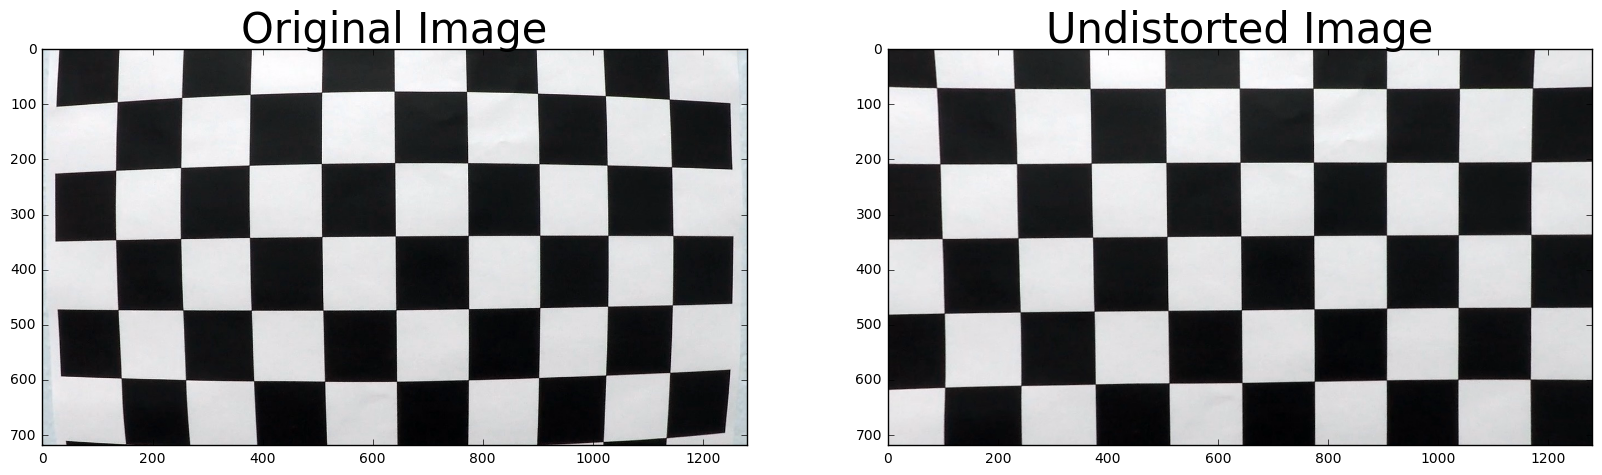

In [1]:
from Camera import Camera
import matplotlib.pyplot as plt
import cv2
img = cv2.imread('camera_cal/calibration1.jpg')
calibration_path = 'camera_cal'
camera  = Camera(calibration_path)
# Test undistortion on an raw calibration image

dst = camera.undistort(img)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Undistortion Example

In the cell bellow there is an example of camera calibration with one of the test image taken from the car camera. 

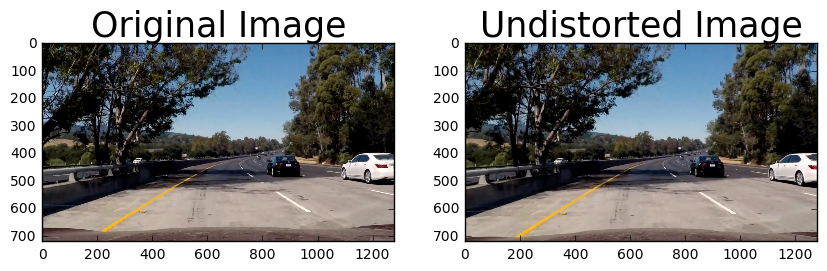

In [2]:
#Test undistortion on an test image
img = plt.imread('test_images/test5.jpg')
figsize=(10,5)
dst = camera.undistort(img)
cv2.imwrite('output_images/test2.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=25)
plt.show()

In the cell bellow there is an example of masking image to mask lane lines. In order to do tham several image processing teqniqques were tested and combine at the and image masked based on the sobel trshold on x direction and image converted to HLS color space and only S component extracted and tresholded. After that bitwise or operation is applied to the masked images. (sobelx and extracred S). In the masked image there are a lot of images seen other than lanes in order to clear them we need to apply perspective transform to get interested area and the image and transfor it to another view to find lane lines and caculate the propecties easily. 

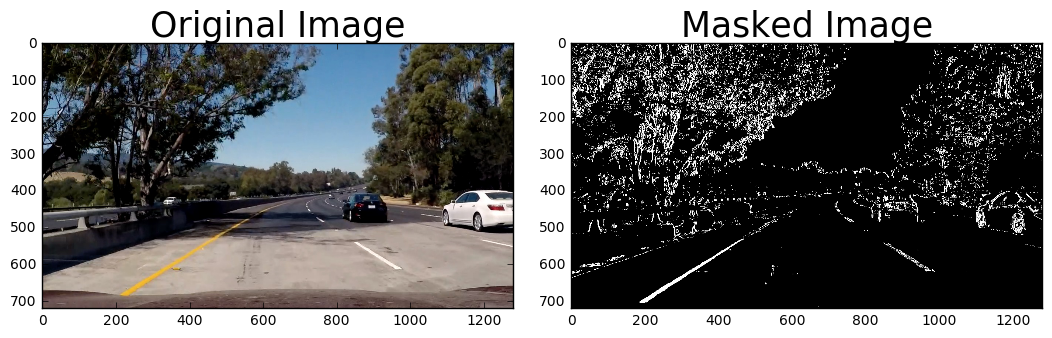

In [3]:
from ImageProcesing import combined_threshold

img = plt.imread('test_images/test5.jpg')

undistorted_image = camera.undistort(img)
combined_image = combined_threshold(undistorted_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined_image, cmap='gray')
ax2.set_title('Masked Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In the cell bellow there is an example of perpective transform to birdseye view with one of the test image. 

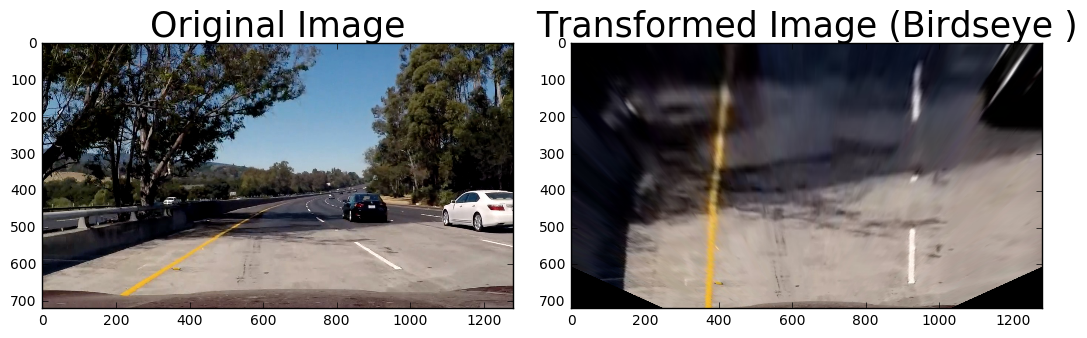

In [4]:
from PerspectiveTransform import PerspectiveTransform
perspectiveTransformer = PerspectiveTransform()
img = plt.imread('test_images/test5.jpg')

undistorted_image = camera.undistort(img)
transformed_image = perspectiveTransformer.get_perpective_transform(undistorted_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(transformed_image, cmap='gray')
ax2.set_title('Transformed Image (Birdseye )', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In the cell bellow you can see and example of output of implemented teqnies so far (camera calibration, perspective trasnfor and lane masking). As seen on the left image still is not perfecly masked there are some noise and non lanes pixels we will deal with that with the Lane detector module to detect only the lanes and put it on the image.  

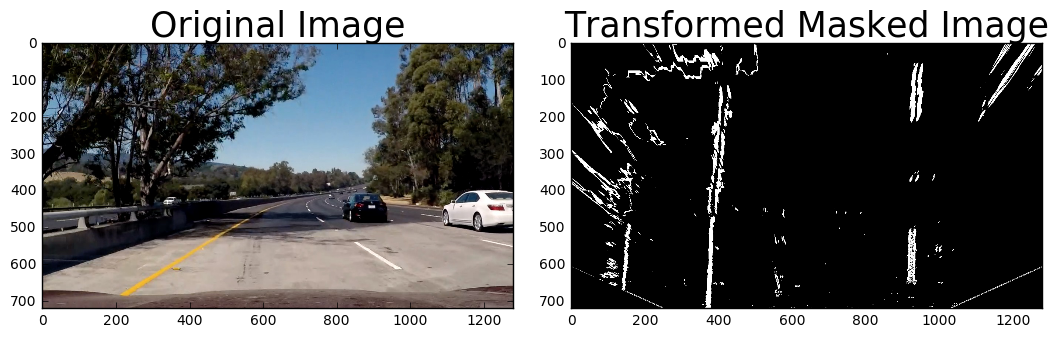

In [5]:
img = plt.imread('test_images/test5.jpg')

undistorted_image = camera.undistort(img)
perspectiveTransformer = PerspectiveTransform()
transformed_image = perspectiveTransformer.get_perpective_transform(undistorted_image)
combined_image = combined_threshold(transformed_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined_image, cmap='gray')
ax2.set_title('Transformed Masked Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2




    #plt.xlim(0, 1280)
    #plt.ylim(0, 720)
    #plt.plot(left_fitx, ypoints, color='green', linewidth=3)
    #plt.plot(right_fitx, ypoints, color='green', linewidth=3)
    #plt.gca().invert_yaxis() # to visualize as we do the images
    # Draw the results
    #template = np.array(r_points + l_points, np.uint8)  # add both left and right window pixels together
    #zero_channel = np.zeros_like(template)  # create a zero color channle 
    #template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)  # make window pixels green
    #warpage = np.array(cv2.merge((transformed_iamge, transformed_iamge, transformed_iamge)),np.uint8)  # making the original road pixels 3 color channels
    #output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)  # overlay the orignal road image with window results

combined_thresold :  (720, 1280)


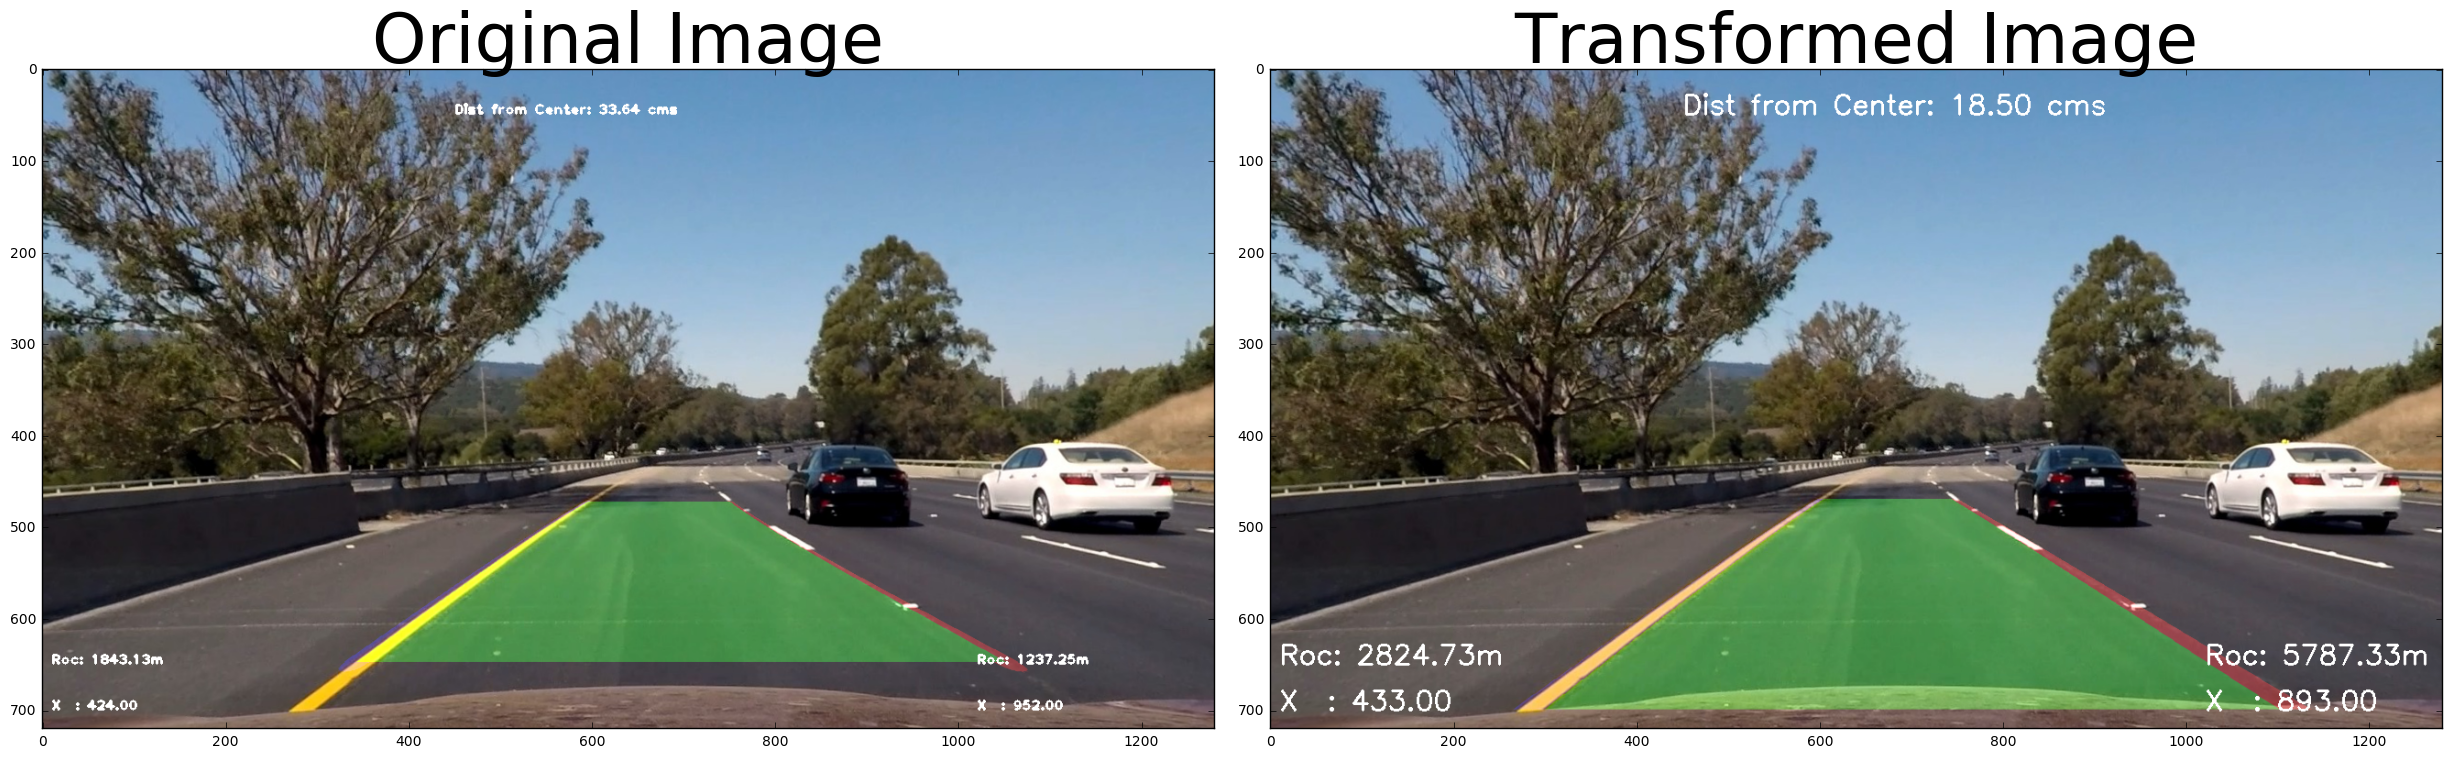

In [7]:
from scipy import signal
#np.set_printoptions(threshold=np.inf)
class Lane:
    # Frame counter (used for finding new lanes)
    frame_number = 0
    # Lane locations from previous frame
    last_left_x = 0
    last_right_x = 0
    # Lane locations from current frame
    left_x = 0
    right_x = 0
    # Lane persp image
    left_lane_img = 0
    right_lane_img = 0
    # Lane persp debug image
    lane_debug_img = 0
    # Frames since lane last detected
    # Init with large value to trigger full scan
    left_last_seen = 999
    right_last_seen = 999
    # Lane fit coords
    sleft_fitx = 0
    left_fity = 0
    right_fitx = 0
    right_fity = 0
    # Lane radius of curvature
    left_curverad = 0
    right_curverad = 0
    # Lanes found in last frame?
    left_lane_found  = False
    right_lane_found = False
    # Lane polynomial fits
    left_fit = []
    right_fit = []
    # Debug Mode
    debug_mode = False
    # Debug Mode
    show_plots = False
    
    def full_scan(self, hist):
        if self.debug_mode:
            print("Running full scan...")
        num_pixels_x = len(hist)
        left_side = hist[0:int(num_pixels_x/2)]
        left_peak_x = np.argmax(left_side)
        right_side = hist[int(num_pixels_x/2):]
        right_peak_x = np.argmax(right_side)
        right_offset = int(num_pixels_x/2)
        right_peak_x += right_offset
        return left_peak_x, right_peak_x
    
    def get_two_peak_x_coords(self, hist, prev_left_x=-1, prev_right_x=-1, start_y=0, end_y=0, found_last_left=False, found_last_right=False, left_trend=0, right_trend=0):
        num_pixels_x = len(hist)
        left_window = 40 
        right_window = 40 
        found_left = True
        found_right = True

        if not found_last_left:
            left_window = 60
        if not found_last_right:
            right_window = 60
        if start_y == 720:
            left_window = 100 
            right_window = 100 

        left_offset = 0
        if self.left_lane_found:
            new_left_peak = int(self.left_fit[0]*start_y**2 + self.left_fit[1]*start_y + self.left_fit[2])
            if self.debug_mode:
                print("    LEFT USING POLY : {}".format(new_left_peak))
                cv2.rectangle(self.lane_debug_img, (new_left_peak-left_window,start_y), (new_left_peak+left_window, end_y), (0, 255, 0),  thickness=2)
        else:
            left_side = hist[prev_left_x+left_trend-left_window:prev_left_x+left_trend+left_window]
            if self.debug_mode:
                cv2.rectangle(self.lane_debug_img, (prev_left_x+left_trend-left_window,start_y), (prev_left_x+left_trend+left_window, end_y), (255, 0, 0),  thickness=2)
            new_left_peak = 0
            if len(left_side) > 0:
                if self.debug_mode:
                    print("    LEFT MINI SCAN")
                new_left_peak = np.argmax(left_side)
                left_offset = prev_left_x+left_trend - left_window
            if new_left_peak == 0 or len(left_side) == 0:
                if self.debug_mode:
                    print("    LEFT USE PREV")
                new_left_peak = prev_left_x+left_trend
                left_offset = 0
                found_left = False
        left_peak_x = new_left_peak + left_offset
        if self.debug_mode:
            cv2.line(self.lane_debug_img, (left_peak_x, start_y), (left_peak_x, end_y), (0, 255, 255), thickness=2)

        right_offset = 0
        if self.right_lane_found:
            new_right_peak = int(self.right_fit[0]*start_y**2 + self.right_fit[1]*start_y + self.right_fit[2])
            if self.debug_mode:
                print("    RIGHT USING POLY : {}".format(new_right_peak))
                cv2.rectangle(self.lane_debug_img, (new_right_peak-right_window,start_y), (new_right_peak+right_window, end_y), (0, 255, 0),  thickness=2)
        else:
            right_side = hist[prev_right_x+right_trend-right_window:prev_right_x+right_trend+right_window]
            if self.debug_mode:
                cv2.rectangle(self.lane_debug_img, (prev_right_x+right_trend-right_window,start_y), (prev_right_x+right_trend+right_window, end_y), (255, 255, 0),  thickness=2)
            new_right_peak = 0
            if len(right_side) > 0:
                if self.debug_mode:
                    print("    RIGHT MINI SCAN")
                new_right_peak = np.argmax(right_side)
                right_offset = prev_right_x+right_trend - right_window
            if new_right_peak == 0 or len(right_side) == 0:
                if self.debug_mode:
                    print("    RIGHT USE PREV")
                new_right_peak = prev_right_x+right_trend
                right_offset = 0
                found_right = False
        right_peak_x = new_right_peak + right_offset
        if self.debug_mode:
            cv2.line(self.lane_debug_img, (right_peak_x, start_y), (right_peak_x, end_y), (0, 255, 255), thickness=2)

        if start_y == 720:
            new_left_trend = 0
            new_right_trend = 0
        else:
            new_left_trend = left_peak_x - prev_left_x 
            new_right_trend = right_peak_x - prev_right_x
        return left_peak_x, right_peak_x, found_left, found_right, new_left_trend, new_right_trend

    def locate_lanes(self, img):
        #histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        #histogram_smooth = signal.medfilt(histogram, 7)
        #peaks = np.array(signal.find_peaks_cwt(histogram_smooth, np.arange(1, 5)))
        #print(' peaks : ',peaks)
        #plt.plot(histogram_smooth)
        #plt.show()
        if self.debug_mode:
            print("Frame # {}".format(self.frame_number))
        # Is this the first frame of video?
        if self.frame_number == 0 or self.left_last_seen > 5 or self.right_last_seen > 5:
            # Generate histogram over bottom half of image
            histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
            # Find X coords of two peaks of histogram
            est_left_x, est_right_x = self.full_scan(histogram)
            if self.debug_mode:
                print("est_left_x : {}, est_right_x : {}".format(est_left_x, est_right_x))
                if self.show_plots:
                    plt.imshow(img)
                    plt.show()
                    plt.plot(histogram)
                    plt.show()
        else:
            est_left_x = self.last_left_x
            est_right_x = self.last_right_x

        fallback_left_x = est_left_x
        fallback_right_x = est_right_x
        left_trend = 0
        right_trend = 0
    
        # Run a sliding window up the image to detect pixels
        self.left_lane_img = np.zeros(img.shape[0:2], np.float32)
        self.right_lane_img = np.zeros(img.shape[0:2], np.float32)
        temp_img = img*255
        self.lane_debug_img = np.dstack((temp_img, temp_img, temp_img))
    
        found_last_left = False
        found_last_right = False
        left_window = 40
        right_window = 40
        left_conc_sections = 0
        right_conc_sections = 0
        for i in range(10, 0, -1):
            start_y = int(i * img.shape[0]/10)
            end_y = int((i-1) * img.shape[0]/10)
            img_sect = img[end_y:start_y,:]
            histogram = np.sum(img_sect, axis=0)
            left_x, right_x, found_last_left, found_last_right, new_left_trend, new_right_trend = self.get_two_peak_x_coords(histogram, est_left_x, est_right_x, start_y, end_y, found_last_left, found_last_right, left_trend, right_trend)
            left_trend = int((new_left_trend + left_trend) / 2)
            right_trend = int((new_right_trend + right_trend) / 2)
            # Store the left/right x values for bottom of image
            if i == 10:
                # Set the new last values
                self.left_x = left_x
                self.right_x = right_x

            if not found_last_left:
                left_x = fallback_left_x
                left_conc_sections = 0
            elif left_conc_sections > 1:
                fallback_left_x = left_x
            if not found_last_right:
                right_x = fallback_right_x
                right_conc_sections = 0
            elif right_conc_sections > 1:
                fallback_right_x = right_x

            if found_last_left:
                left_conc_sections += 1
            if found_last_right:
                right_conc_sections += 1
          
            if self.debug_mode:
                print("i: {} Start_y: {} End_y: {}".format(i, start_y, end_y))
                print("    est_left_x : {}, est_right_x : {}".format(est_left_x, est_right_x))
                print("    left_x : {}, right_x : {}".format(left_x, right_x))
                print("    left_window : {}, right_window : {}".format(left_window, right_window))
                print("    left_trend : {}, right_trend : {}".format(left_trend, right_trend))
                if self.show_plots:
                    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
                    f.tight_layout()
                    ax1.plot(histogram)
                    ax2.imshow(img_sect, cmap='gray')
                    plt.show()
    
            # Fill in the left lane image
            left_mask = np.zeros_like(img_sect)
            left_mask[:,left_x-left_window:left_x+left_window]=1
            mask = (left_mask==1)
            self.left_lane_img[end_y:start_y,:] = img_sect & mask
    
            # Fill in the right lane image
            right_mask = np.zeros_like(img_sect)
            right_mask[:,right_x-right_window:right_x+right_window]=1
            mask = (right_mask==1)
            self.right_lane_img[end_y:start_y,:] = img_sect & mask
    
            # Set the new last values
            est_left_x = left_x
            est_right_x = right_x

        self.frame_number += 1    

    def fit_lane(self, img):
        # Extract the list of x and y coords that are non-zero pixels
        xycoords = np.nonzero(img)
        x_arr = xycoords[1]
        y_arr = xycoords[0]
        
        # Fit a second order polynomial to each fake lane line
        fit = np.polyfit(y_arr, x_arr, deg=2)
        fitx = fit[0]*y_arr**2 + fit[1]*y_arr + fit[2]
    
        # Find RoC in pixel space
        #y_eval = np.max(y_arr)
        #curverad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) \
        #                         /np.absolute(2*fit[0])
    
        # Ensure we have points for min(0) & max(719) y
        # This will extend the lines in cases where the lanes
        # dont have pixels all the way to top/bottom of image
        fitx = np.insert(fitx, 0, fit[0]*0**2 + fit[1]*0 + fit[2])
        fity = np.insert(y_arr, 0, 0)
        fitx = np.append(fitx, fit[0]*719**2 + fit[1]*719 + fit[2])
        fity = np.append(fity, 719)
    
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        y_eval = np.max(y_arr)
        fit_cr = np.polyfit(y_arr*ym_per_pix, x_arr*xm_per_pix, 2)
        fitx_cr = fit_cr[0]*(y_arr*ym_per_pix)**2 + fit_cr[1]*y_arr*ym_per_pix + fit_cr[2]
    
        # Get radius of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])

        return fit, fitx, fity, curverad

    def fit_lanes(self):
        self.left_lane_found = False
        self.right_lane_found = False
        # Get new lane fit for left lane
        left_fit, left_fitx, left_fity, left_curverad = self.fit_lane(self.left_lane_img)
        # Only use this new lane fit if it's close to the previous one (for smoothing)
        if self.frame_number == 1 or self.check_lane(left_curverad, self.left_curverad, self.left_x, self.last_left_x):
            self.left_fit = left_fit
            self.left_fitx = left_fitx
            self.left_fity = left_fity
            self.left_curverad = left_curverad
            self.left_lane_found = True
            self.left_last_seen = 0
            if self.debug_mode:
                print("Frame : {} Left Lane found! RoC : {} Prev X : {} Curr X : {}".format(self.frame_number-1, left_curverad, self.last_left_x, self.left_x))
            self.last_left_x = self.left_x
        else:
            self.left_last_seen += 1
            if self.debug_mode:
                print("Left Lane NOT found! ({})".format(self.left_last_seen))

        # Get new lane fit for right lane
        right_fit, right_fitx, right_fity, right_curverad = self.fit_lane(self.right_lane_img)
        # Only use this new lane fit if it's close to the previous one (for smoothing)
        if self.frame_number == 1 or self.check_lane(right_curverad, self.right_curverad, self.right_x, self.last_right_x):
            self.right_fit = right_fit
            self.right_fitx = right_fitx
            self.right_fity = right_fity
            self.right_curverad = right_curverad
            self.right_lane_found = True
            self.right_last_seen = 0
            if self.debug_mode:
                print("Frame : {} Right Lane found! RoC : {} Prev X : {} Curr X : {}".format(self.frame_number-1, right_curverad, self.last_right_x, self.right_x))
            self.last_right_x = self.right_x
        else:
            self.right_last_seen += 1
            if self.debug_mode:
                print("Right Lane NOT found! ({})".format(self.right_last_seen))


    def draw_lanes(self, img, warped, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.left_fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.right_fity])))])
        pts = np.hstack((pts_left, pts_right))
    
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Draw lane lines only if lane was detected this frame
        if self.left_lane_found == True:
            cv2.polylines(color_warp, np.int_([pts_left]), False, (0,0,255), thickness=20)
        if self.right_lane_found == True:
            cv2.polylines(color_warp, np.int_([pts_right]), False, (255,0,0), thickness=20)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

        # Write the radius of curvature for each lane 
        font = cv2.FONT_HERSHEY_SIMPLEX
        left_roc = "Roc: {0:.2f}m".format(self.left_curverad) 
        cv2.putText(result, left_roc, (10,650), font, 1, (255,255,255), 2)
        right_roc = "Roc: {0:.2f}m".format(self.right_curverad) 
        cv2.putText(result, right_roc, (1020,650), font, 1, (255,255,255), 2)
    
        # Write the x coords for each lane 
        left_coord = "X  : {0:.2f}".format(self.left_x) 
        cv2.putText(result, left_coord, (10,700), font, 1, (255,255,255), 2)
        right_coord = "X  : {0:.2f}".format(self.last_right_x) 
        cv2.putText(result, right_coord, (1020,700), font, 1, (255,255,255), 2)

        # Write dist from center
        perfect_center = 1280/2.
        lane_x = self.last_right_x - self.left_x
        center_x = (lane_x / 2.0) + self.left_x
        cms_per_pixel = 370.0 / lane_x   # US regulation lane width = 3.7m
        dist_from_center = (center_x - perfect_center) * cms_per_pixel
        dist_text = "Dist from Center: {0:.2f} cms".format(dist_from_center)
        cv2.putText(result, dist_text, (450,50), font, 1, (255,255,255), 2)

    
        return result
    
def histogram_lane_detection(img, steps, search_window, h_window):
    """
    Tries to detect lane line pixels by applying a sliding histogram.
    :param img: binary image
    :param steps: steps for the sliding histogram
    :param search_window: Tuple which limits the horizontal search space.
    :param h_window: window size for horizontal histogram smoothing
    :return: x, y of detected pixels
    """
    all_x = []
    all_y = []
    masked_img = img[:, search_window[0]:search_window[1]]
    plt.imshow(masked_img)
    plt.show()
    pixels_per_step = img.shape[0] // steps

    for i in range(steps):
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        histogram = np.sum(masked_img[end:start, :], axis=0)
        histogram_smooth = signal.medfilt(histogram, h_window)
        peaks = np.array(signal.find_peaks_cwt(histogram_smooth, np.arange(1, 5)))

        highest_peak = highest_n_peaks(histogram_smooth, peaks, n=1, threshold=5)
        if len(highest_peak) == 1:
            highest_peak = highest_peak[0]
            center = (start + end) // 2
            x, y = get_pixel_in_window(masked_img, highest_peak, center, pixels_per_step)

            all_x.extend(x)
            all_y.extend(y)

    all_x = np.array(all_x) + search_window[0]
    all_y = np.array(all_y)

    return all_x, all_y

def highest_n_peaks(histogram, peaks, n=2, threshold=0):
    """
    Returns the n highest peaks of a histogram above a given threshold.
    :param histogram:
    :param peaks: list of peak indexes
    :param n: number of peaks to select
    :param threshold:
    :return:
    """
    plt.plot(histogram)
    plt.show()
    print('peaks : ',peaks)
    if len(peaks) == 0:
        return []

    peak_list = [(peak, histogram[peak]) for peak in peaks if histogram[peak] > threshold]
    peak_list = sorted(peak_list, key=lambda x: x[1], reverse=True)

    if len(peak_list) == 0:
        return []

    x, y = zip(*peak_list)
    x = list(x)

    if len(peak_list) < n:
        return x
    print('x : ',x)
    return x[:n]

def get_pixel_in_window(img, x_center, y_center, size):
    """
    returns selected pixel inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    """
    half_size = size // 2
    window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y

def process_image(image): 
    camera = Camera('camera_cal')
    undistorted_image = camera.undistort(image)
    # Plot the result
    binary_image = combined_threshold(undistorted_image)
    print('combined_thresold : ',binary_image.shape )
    pt = PerspectiveTransform()
    transformed_image = pt.get_perpective_transform(binary_image)
    lanes = Lane()
    lanes.locate_lanes(transformed_image)
    # Fit polynomials and set lane x/y arrays
    lanes.fit_lanes()

    # Check curvature sanity

    # Draw lines back onto road
    combined_img = lanes.draw_lanes(undistorted_image, transformed_image, pt.Minv)
    #print('what it is : ', (250, binary_image.shape[1] // 2))
    #x,y = histogram_lane_detection(transformed_image, 10, (250, transformed_image.shape[1] // 2), 7)
    #print(x)
    #print(y)
    #right_x, right_y = histogram_lane_detection(transformed_image, 10, (transformed_image.shape[1]// 2, transformed_image.shape[1] - 250), h_window=7)
    #print(right_x)
    #print(right_y)
    return combined_img

from Lane2 import *


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('test_images/test1.jpg')
processed = process_image(image)
processed2 = process_image2(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(processed2,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [8]:
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip

VIDEOS = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]
white_output = 'willBeDeleted2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video willBeDeleted2.mp4
[MoviePy] Writing video willBeDeleted2.mp4


  7%|▋         | 91/1261 [08:44<1:50:52,  5.69s/it]

KeyboardInterrupt: 

In [ ]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

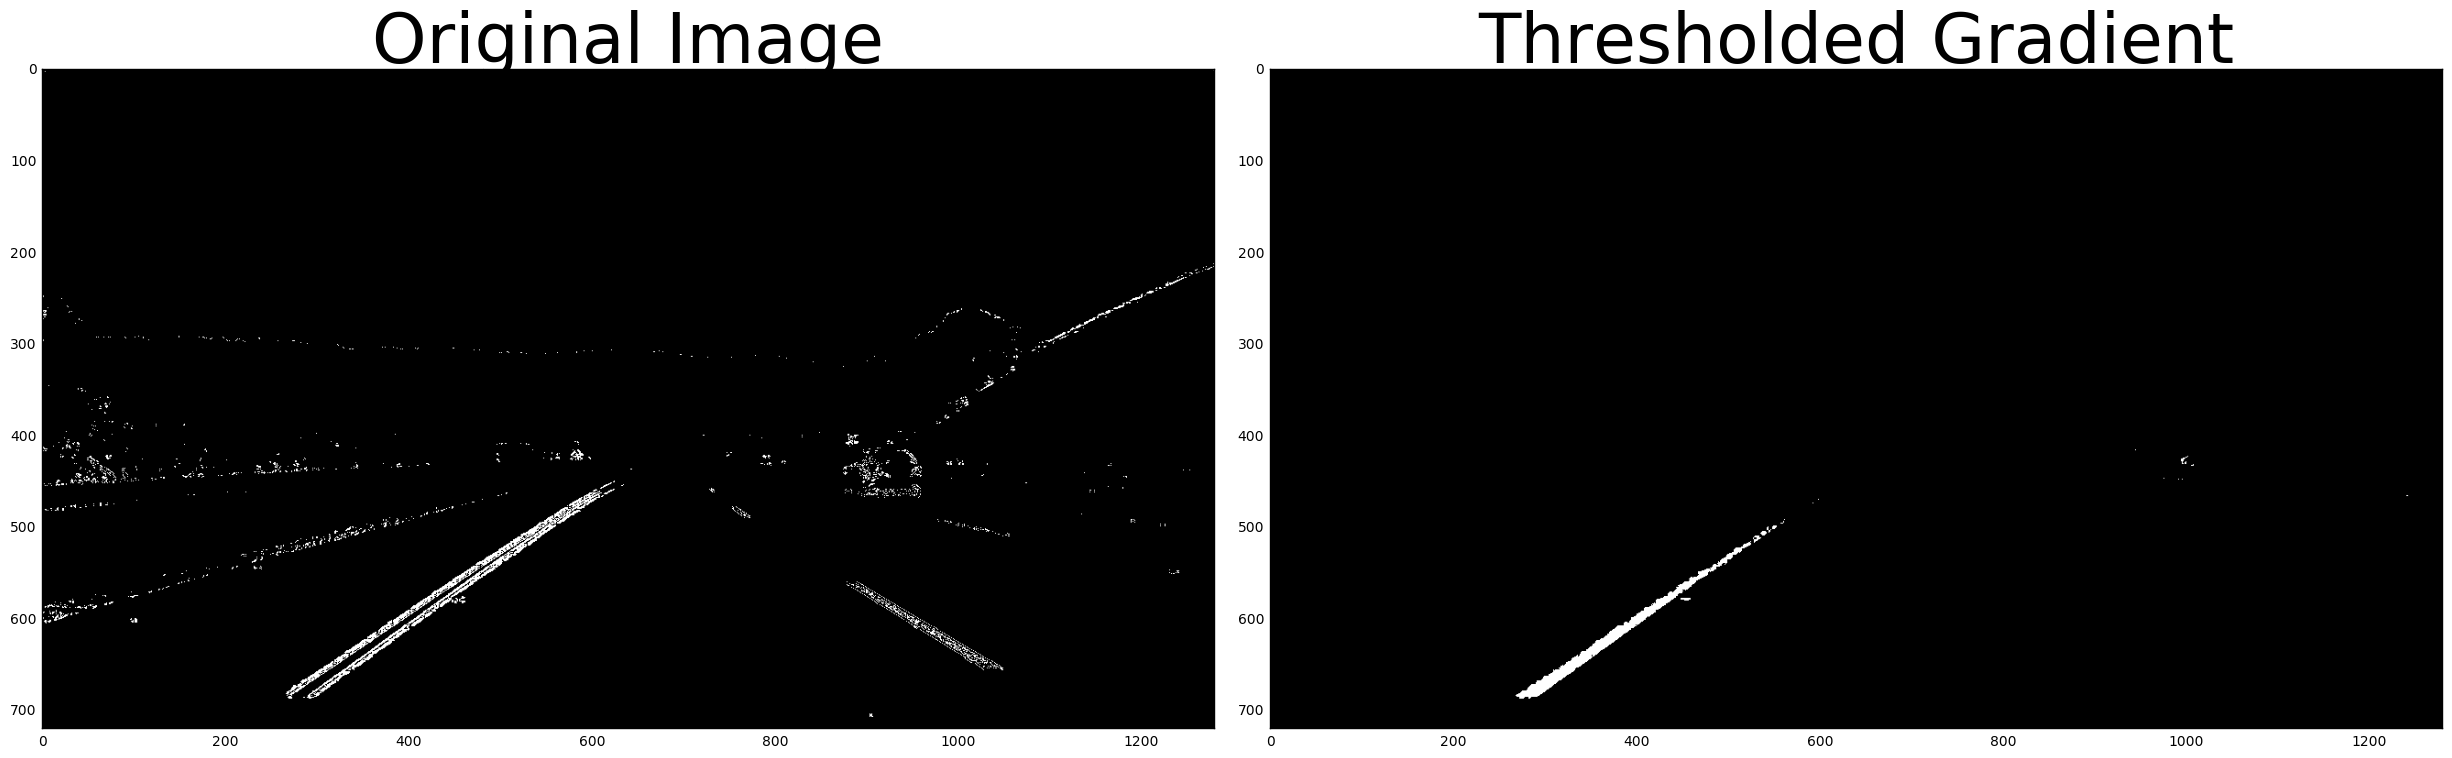

In [9]:
import os
images = []
for i in os.listdir('test_images'):
    img_path = 'test_images/' + i
    img = mpimg.imread(img_path)
    images.append(img)

for idx,image in enumerate(images):data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACZQAAAL2CAYAAADc0oEpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAIABJREFUeJzsnXe4LEXR/z/FBS7hknMOkkFyEAQJShADKKIYUARfs6L4mgAxoGIWRX4qJgQDiogivCA5CkhGgiTJOUeBC7d+f9QMZ3bOzJ4NPXv2nPP9PM88Ozu7W13T09PbXVNVbe6OEEIIIYQQQgghhBBCCCGEEEIIIYQQQggx23grIIQQQgghhBBCCCGEEEIIIYQQQgghhBBiOJBDmRBCCCGEEEIIIYQQQgghhBBCCCGEEEIIQA5lQgghhBBCCCGEEEIIIYQQQgghhBBCCCEy5FAmhBBCCCGEEEIIIYQQQgghhBBCCCGEEAKQQ5kQQgghhBBCCCGEEEIIIYQQQgghhBBCiAw5lAkhhBBCCCGEEEIIIYQQQgghhBBCCCGEAORQJoQQQgghhBBCCCGEEEIIIYQQQgghhBAiQw5lQgghhBBCCCGEEEIIIYQQQgghhBBCCCEAOZQJIYQQQgghhBBCCCGEEEIIIYQQQgghhMiQQ5kQQgjRIWa2tZnNqtheHG/dBoGZnV1z/geNt25iBDO7reY6vXu8dRNCCCGEEEIIkYapbqMQzWJmv6lpX0eMt24THTO7q6Zu3zHeulVhZgfX6HvqeOs20TGzfWrq9sbx1k2IpknZF5rZ+TWy9m9CdyGEmErMPt4KCCGEGH7MbC5gRWBhYF5gTuAZ4GngPuBOd/dxU3DwFM/Vxk2LweO0nrsYTnSdhBBCCCGEEGLqMFVtFKJZvPQq0jFR7TYTUeeJwpSoWzNbEFgOmB+YB5gOzASeBR4D7gcecPdZ46akGCQp+8KJ2q8KIcTQI4cyIYQQozCz1YCdga2ATYGlaW+UfN7MbgYuAM4BTnL3xxtXdHwxpuYkpXjeU7UOJhpDd53MbAXg1pqPz3b37QapjxBCCCGEEGLqYWaLAFuOtx4dcoe7X9Hm86Gb94lJh9pYc0y0up1o+k40JoVjsJktBuwEbEY8X1gDmNHBT2ea2S3A9cAlwIXARe7+XFO6iqGh375Fzy2EEKIB5FAmhBACADObDuwD7A1sWPiok4jEOYA1gbWA/wGeM7OTgR+6+9nptRVCTBI0sRdCCCGEEEKMF+sAx4+3Eh1yJGGvEUIIIYaSbJWTPbNtC2C2wsedZpCaHVidcEB7U3bsaTM7AzgOOM7dn0mmtBBCCCHaMtvYXxFCCDGZseDDRLagHxHOZE5vaYLz38wJ7AqcaWbnmdmmCVUWQkwurPQqhBBCCCGEEIPEJ8AmhBBCDCVmNreZfRG4C/gpkf0zzxDV6/9Y8bfzAG8Efg3cb2Y/zVZYEUJMIMzsN2Y2q2I7Yrx1E0LUI4cyIYSYwpjZWkTa6B8BS1A9wbMutiK5rFcC/zCzH2ZRSpMFGXSFEEIIIYQQQggBndlJepUrhBBCDCVmtjtwI/BFYCH6f74w1rOGeYgVUq43sz+a2Srpz0oI0RDF1ZAUOCHEBEEOZUIIMUUxs92Ai4BNaF1bnsJ+OZJorGjZ8mQv/70BHwXON7PlGjidQZPSODwRmcrnLoQQQgghhBBictHrg+5ObAMp5Gr+LYQQYqjIspL9AvgDsDTVTiHF/7JeMnO2cy4DeAtwrZmtlOCUxORAzy0mFrpWQkwAZh9vBYQQQgweM9sX+F7xUPbqpf2ZwGnZdgVwM/AY8CwwA1gMWJ3IQrYzsF5Bnhfk5fsbAv80s+3c/fomzm0AVE2Op1IUxVQ6VyGEEEIIIYQQk5tUc9y6B2Kp5GsuLoQQYigws0WAU4CNaHX+Kget5++vBc4DLiGeL9wBPAr8N/vOvMACwErAy4DNiOcNaxXklWXmzA7MneC0xMRHYyUhhGgAOZQJIcQUI3Mm+z7VE7x84vcU8G3gJ+7+UI2oJ7PtP8DJwIFmtj6wP7BbjVwnltY808y2cfcbEp5a47j7OcC08dZjvHD3bcdbByGEEEIIIYQQIgWp5vhmtjVwFq32j/z11+6+d79lCCGEEMOAmS0JnA2sxujgdBj5/3sY+AnxP3jLGGKfyLY7gXOBX2VlLQ/sDrwHWLsgv1ieELj7VuOtgxBCTFa05KUQQkwhzGwXIjNZO2eyk4BV3f2rbZzJKnH3K939rcB2xASwbEzNy1oCONHMFuzjdIQQQgghhBBCCCGEEEII0TBmNg/x7KCdM9mzwNeAFdz9oA6cyWpx9zvc/bvuvi6wIyPO23lZQgghhGgYOZQJIcQUwcxWB44qHspei05fB7v7G939gX7KyqJ81wcuLh6mdaK3MnBMP+UIIYQQQgghhBBCCCGEEKJxfgtswGhnsnxJypuBzTJHsv+mLNjdT3f31wCvA65DGcqEEEKIgSCHMiGEmAKYmRGpomfkh7LXojPZ5939S6nKdPdHge0Jp7KiI1kxY9n2ZvbBVGUKIYQQQgghhBBCCCGEECIdZrYPsAvVmckArgRe4e7/alIPdz+FcGr7JvBCk2UJIYQQQg5lQggxVfgI8Ipsv8qZ7Gfu/q3Uhbr708AbgTsKZb30cXbsG2a2VOqyhRBCCCGEEEIIIYQQQgjRO2a2BPA9Rtv2Iez7twCvcfdHBqGPu8909/2B1wB9rbQihBBCiPbMPt4KCCGEaBYzmwf4AtXOXBApovdtqnx3f9DM3gOcQWt2slyf+YADCac3UYGZLQusQNSVA08Ad7r7XeOqmBBCDAgzmx9YBVgYmBN4CngYuNHdZ46nbkIIIYQQQgghhBCTmC8xYpcu2vUNeA7YbVDOZEXc/Vwz2xB4ftBlCyGEEFMFOZQJIcTk5+PAYrQ6keU48H53f65JBdz9HDP7BfA/VDu27W1mhzTtIGVmswFbADsA6wOrA4sSS4G+ADwI/Bt4x3hMggt6zgG8CXgbsC2wYM33ngTOAo4Hjqm6jma2GyNLnRY5391vSab0ADCzJYmMd9sA6wBLE8aMWcDjRCa8K4Ezgb9lGfKa1mlBYMtMnzWJNrU4MD8jhpb/Em3rLuAa4J/Aqe6uCLpxJLvPtgVeC6wHrErca9OJ9nQvcAlwKnC8u3dtnMqcoHYFts7KWCYrw4DHiAjOCzP5F/R5Sp3oMyeRrXJ9or2ukek0f7bNTrTXx4C7if7wcuB0d/930/pV6Ls+sBewE7BazddeNLOrgb8BR7r7bRVy1iPOucx97v73NNqOKnMVYDtgc0L3FYg6npswtj4B3EY4dZ8PnOTuDzahixBCCCGEEDmZXWRL4PXAhsQcdkFgLuAZ4H7gJmKe8temly4bi2wOszWwPfByYmy9MDAvMa6+H7je3d/QZzmrMjJ+X5X24/fziPH7Q/2U2aFes2d6bcyIHWvBTLcZhBPFM8Q87n7g9kzP64GLgOvc3UcJbk7fhYHXEVmDXg4sR9hGAJ4E7gSuBs4m2tejg9It028Voi1tQbSl5TP9phN1+Dgj9Xc+8Hd3v3+QOqbGzDYh7vdXEDaAhYnzfQp4iDjXfxJ2tKvHS88yw3pPlnRci7BTbknYWBbL9HsaeIQRm8qJ7n7RIHVLiZmtCOxDq00fRhzLvj2ebcfd7x1UWVkftwNhT1wTWJmRdvkU0cf9yd2/0qXcJYh2tDZxn64OLMKIffkFRv6j8370IsJe93jfJ9YlZjYX0a/sQNg7V8p0ncVIX38tYaM/0d0fHrSOgyCzN24NbEb0U/l/3lyM2Ff/A/wLOBc42d2fHB9tRzCzlYnla19JPNNYnBhTzCR0vg24FDiN+B/sKZDXzBbNyiiybM3XVzCzXbos4jp3v6l7zYQQXePu2rRp06Ztkm7ExO4O4MVsm1V6PXaAuixBTKzqdPlql/JWyH5btS1f+u5cwGcJw1rxey+WtvzY8jVlbl1T3osJ6+m9xKSrTscqnWcRzi8frJB3a5W+wLt70O3smvM/qElZxET698SkZqzrl29PAN8A5mugLW8BfAe4jJjQV9Vvu2uVf+cMYNcG9Lu1pl13fc2b2gr3b1VfcGYf8jrpD+Yk+oO7O7hu+WcPEc65s3Woz3LAz4Bnu2izlwNbN1DXqwCfz9rbMz2211mEkfZjwFwDaB/rAH/vQMeyrjOBI4FFS/K+WNM2um5rY+g9J/ABom/opJ5nlXQ/AdhsvO9Pbdq0adOmTZs2bd1tjNgKquY3vxyPciu+OxvwISKopZtx6oXAdon1HdOmQjhNfZ1YymxMO06P+kzP6uSKHsbvzwN/ATZt6NquChxOBKf1OoebRTwY/hPwVmCeLnU4ulRevn9ExXeXA44gHqB3Ogf+L/BjYLGG78/ZgD2JgLFur/MLxNz0NYl1urOqHRMBrqnK2LWibY91vhcDr6+QdXBNWzg1cb0M7T1Z0vNVhHNIN/pdR4VdjnDUKv9+FpGNvdHz6OJ8v1XQsdwO7mcAdqKGzutgRrezWVXtmnAeO5qx7Xwd3RfANMIZ6/CsbVT+N3bY7v9MA/bEGr1nAF8jVgzotK9/Fvg5sEKFvGR9IeEEXFWP+yeug/kJu/INHV6z4ufPAEcBayTU566a8x5Vh4SD7sld6nw/8Glgjh50e3WNbqm2pNdWmzZt9dtsCCGEmMzsxIjXfzk7GcSEcCB4RPQdVaFHnqXsPWZWpeOYogsblKKlzGw7ItruEKIuyt/vhRQyWjCzhc3sZOAXROatTuXn31sc+H9mdpqZLdCQvl6zNSbLzA4kso69jTACtiu3+Nm8wGeAa81s0x51LOox3cy+Y2a3ExPU/YANGInG66Q+yt/ZFvizmV2URTWK/hmrP9gQuIroD5as+H6dvIWAQ4FzzWyRdgqY2QeIKNR9gDnGKKP42frAmWb25bZn2CFm9kEzuwy4kTD2bEsYZ3tpr05ER/4AuNHMdk2hY43enySi4LbvQMec/HuzAe8GrjOzbdp8L2n/DWBmexBRhz8m+oZOyip+PhsR3Xmhmf12rHYmhBBCCCFEp2TzzUuIB9cr0t04dTPgdDM7PMuWlYK25ZvZ24gHtZ8jMrQ0YYN5BxGMdTiwLt2P36cRmYkuMrOjsqw1KfSabmZfJbKZfIjIJtXrHM6JTClvBo4BfpdCxwqdP0hkonkfEWTT6Rw4D8i53sx2aki3rYhM8b8GNqL762zE3PRUMzsjy3A21JjZomZ2IuFkUm7bVRQ/3wQ4wcyOrbAtNsqw3pMlHecxs18SQbJbdqnfGsCRZnaWmS2TWremyLL7v4fR55jbQ3/g7s8OXLG01LY1M5tmZocQtul30t7ON+ZzDTNbzMx+QgSGn0L086tX6NBpXz+NcB49y8xONLOlx9KhV8zs1cR/8+cJp+9O+/o5gL2BazKbaVNU1WHKccNsZvZxImHBIUQAb7f91HTgXURdfNfM5k6g2pjnnY0tDieeaezYpc6LAt8ELssym6XQsZvzaLcJIQaEHMqEEGJy8/bS+9wYAnCZu18yYH0OL70vTrSWJpYy7IXKCVs2STmFSGHvpe9XbX2X2QtmtjzwD0YG9GX5dfqWdXci8uOCJgwnNXo1IsvM5jKz44GvMDJZz7831vUr1seyxKT6VX3quiDhRFbnlNjJNapypnRgU+BSM3trnzqKoK4/2Bk4h1jWotf2tAVwvpktVCHfzOznhEPRXB2UUdY5//4XzOzbnZzoGOzLaMemYnndtlcYuaf+nEjHFszs/wHfZeSer6qnTvrBRYFTzOyNdUUl1HmGmf2JeDizFPVGxW76hLcDl2dLfgohhBBCCNEzZrYjYW9Yn+7mQfn38jHqh4A/ZUtmJlGtRt+DiQzli/ag79iFms2X2Rp+Q2TSr3og2e34/V3Eg9Z1u9WnpNsM4HRgf1rtIJ3q1m4e5yR+FpQ9XP8p8P+IoL5e59kLA38zs7ck1u8AwvGn6KzR8pUO9Mx1dCJI6woz2y2lnikxs9WJjNk7U21fzN+3m087sBth+1hqADoP7T1Z0nNJImPjXoVyeqnbrYlAsjVT6dYw2xFLeUKr7QoiQ9AvB65Rc7RcTzObl8jm9Flgdrqz89WxGvB+Wp2lyzr02sfvDFxtZlt2qEvHmNlHiGyNeXBurmsneuc6zgP82My+l1q/kh5V+/0JDUe9c4lg4/npv58y4JPAP7LnQikpt+NFif/CDxXKb6dvlSwnVpO40MxWS6xvLyS7tkKIzpBDmRBCTG6KDkpFHPjDgHXB3a8l0jjnOpRJFpFoZu8ijFrT8kOFbWiiGjLHr1OJ5QzyCYVV7I+1FQf4awHHZ1FkE44s6vk4YBdGT3LaXbty3ZHtz03Ux+Ip1aSzNlWnYxEnHJB+l2U5EonJopKPI4wX0F97Wi2TVebXRMRdp222bFgptov9EhnT65zI8s866VfKxpj8s09l0W1JMLPvAB+ktf46rcuyvk5Eu//WzDZKpWOFzksCFxER/+2MgN3UMdnx5YCzzWyTpvQXQgghhBCTmyxj+1+ILFXQ2Xyg3TzlDcBXG9T3AOAAqufPfdtxsgfC/6TV1vDSx/Q3fl+BGL9v0I1OBd3mIJzJXknr+XejW1nHbh0duuXnwP8w+np1OmcrXttpwNFmtkYKxbIMQAcXD5X2O7UHFHHCce6PDWfZ6Qkzexnh8JAHQhbPE8Y+7/L9tjbwf5mjY1M6D+09WdJzYSJA8eWkqdtlgb8PwmEvAa+rOJaf6znuft+A9RkImW36z8Br6L6P66ooOm/rVX18ESccdE8xsy261KNeQbOPAYcVyiuPEbrpTx3Y18y+kEq/pjGztYmVFLYgfT+1HrEaxgoN6T4/cBqRbbbcdrodBzrh7H+CmU3vVhXq223dd9ptQogBkypNtRBCiCHDYmm3xaifzJwwWI1e4q+Ew1PVAHxHIuqnX14O/KwkOy/vZiJr2e3AA8CzRPapNYjsXsmi1zrk94xkTKobrJ8P/IkwDN0HPExEMi0FvIqIHNyS1uu8JZBPzornPxE4DHgto+vhMcLAegXwYPZ+EcJItCORjQlajZP5eS9IOBimcNIp6gTwFLEcxVXAHcDj2fY8sACxXOK6wMZEO6uS4YSj/y/M7Dp3vzqBniJYGjiecDCCkXbxIhFdejZwD3FfLUBkNNyJWA6jbOzOX7c2sw+4+08BzOxzRARsVZs9hWgb9wPPEMvTrk0sxbAUo+/PXMahZnaKuz/Vx7kX+4S8jJnEkpxXATdlOj4OPA3MyOpg9ez8NyTmC+W+KZf1QTO7yt2P6ENHzOydRAbAcv3l5+DAnYQj39+A24jlAaYTdbgm0Q++gXhYlv9mHiJz2J/70a9G50UIg3Ke4r5sTM7P4QngPMJI/iDRzuYlIq83AXYg6r2qT5ifMOBv5O53pD4HIYQQQggxecmW5vsLo+dBTswFziDG2A8QY/7FifHpjsT8uW6e8ikz+6O7X5lY39cQDkDleQDEkoWnAncR86oXCVvA2sRyhGMuQ2hmixHj95UZe/x+LjF+f4gYv8+gdfw+L9Xj9wWJB/kbuftdHZ988Fkie3mVbSgv4zZibnEzcDcxv5xJzBvmJ2yAaxM2sZUKcpI/gM2c//aq0Pdp4Cyi/h4AHiFsIssQ12ozwvZRZbeZE/gF4VTXj26HEBmAqtpSvj+LqMvzCHvAI8Q9sCxxjdev+G1+jgYcbmaPuvsf+9E1FWY2H/B/xMN+qLcv3kvYZW8hznsu4tqsRzgOzUXrOa8L/BT4TwM6D/s9mes5jaizYiAwFfuPEn3ujcT9aUTdrkXYf+an9T5cBvgjcFQveg2QHai3Kf99kIoMmK8SfVb5Or9A9BvnE/9HDxIZJZck7NLdBMuX+5dHgauJ/+h7GLEvzyJsdYsSfdOmhC28SkZuCzvezNZ19/u70Ge0grHaw/dp358CXEyMK+4m7tHFiP50e8K2WPy+AV8ys4v70W0QZFkfz2Qka2rd+T9E2JevyPYfJa7ZksQzmm0IG2bV9VqeWFZ5Y3d/MqH604Bjif693I7vJ+zV1xNt+Cnimq1CPJNZndF9Xf66KvBlYlnyTqjqP6rGJBPp2ZUQUw9316ZNmzZtk3ADPkBMOF4svOb7d4+jXju10et5YHqHclaokJO/3lFx7G/A2h3I3RiYr+azrevK7LEuPl6SU5Z9HbBVh7K2JpxEXixszxETgnI9vwi8uwd9z6qRdVBCWZdX1MONhCPYbB1cu4tLMsuyXtPjtVqipO9lhMPeul3KWRv4UdbW63S8tM977NZSO+j5mje1jXH/nplY3lWlY88RKcoXGUPmZhW/LdbpA4SxdQvCoFT8zu3EsoW1bZYwon+idI+WXw/po46vL+h7G/ADYqmC2bts958ljCHlOsjfPw4s04eey2Qyyu01338a+DwwrQNZixLLZJTvrUcq5PbU1rJyZicM2u367yuB3QEbQ9YcwMdq6jjf/2e7tqRNmzZt2rRp06ZtfDfa2AqAX45TueW59fOEY8iyY8icDhxEOCvVyT6/AX3LdpwXgCOBFTqQ++oxPp8DuGCM8fvlRJBKJ+P3T2RzjLrx+4VjySnJXDyb95Tl5K9/ANbrsq4XAd5NPEzOZZ/QpYyja87vKsKRrXjsLmAfYI4xZK5OOAe2s9vs1cc9sWvNdS62q8OApcaQsxrhHFR1PfL9J4A1e9TzzoKsoux39Cjv6Jrzzl9vBnYaQ8YM4H9r2uJlNW3h1B71Hep7siT/4DH0vA/Ygza2FsJZ8r2Eo81YdZt/dmOv90GqjQjYq2qn+esm461jn+d3MNXt5S5a7Xz5/f55ap4ZFGTOThtbPuEwm5czk7At7Qes0qXuWxBB6lXXJX/9Y5/1swQjTtx17f/3wIpjyFmNcMosy7iNcGaqugZd94WEo1+VrP17PP8FiWcSdfbKF4nnG23HIJmsGcBXiP616n7v+XpR/39S9YzlYmC7DmTuCNxQ8fvimPJlPepbN7Y4op/2qk2btmY3LXkphBCTl6qU3nk0wXhGgJTLLkYkTKP3DGHFyMtlGImaeA54m7u/wWPJzba4+6WeNhqkkmz9+i9THenoRJTehu5+Xify3P0cIkrpXEbqYnZal/gbVorXbn1a6+EIwkD3J3ef1U6Iu18KbEWkcq7Lyvb+PvR8DvgVsI67b+TuB3uXmcTc/Vp3/yjhrHRzfpjWSJ8NzOytfegpWttUcUmCB4BXuPsn3P3hdgLc/WKiPV1B6/XJWYRY4vIntGYy+yuwurv/vl2bdfdZ7n4oYSB9Pj9ceDVgLzPrdbzuREa/ndx9RXff193PdPcXOhbgfr+7f5OIqD2l8FGxHmYQy9L0yrdpXYKnGOn3JLCNux/i7i92oO9D7v4uwlmXgqwFKvTuhy8REYbFezfffxH4gruv7+7HunvbCDt3n+nuhxF1XMzyUGxzGxEGciGEEEIIIdpRN7e+H9jc3T/gY2Tpcffn3P0rxLLuz+WHaR2fbm5maybWt2jHeQzY1t33cvfbxxLi7meM8ZWDgc2pH7/v7+4buvtxHY7fDyWyJP+rdC65zE2JoJFOeRMwd4UcBz7k7m9z96u6kIe7P+zuR7n77sByhJPgvd3IKFGeYxezjP0VWNXdf+HuM8fQ6wZ334F4oJzUbmNmCwA/Lskszi8fJtrVx9y9bV24+43uvisx58/PqWwTmJdY9nNcMbPtgXdSn93uGCIY8pRqCdkP3J9y9+8Q9uSbaL0+xRUBUjDs92QIiH7us9Tbbs8kgpePaWdrcffn3f1XwDrARTRbtynZgNZ7v1gPuXPpZKF4nkvTei9dSdj5DhnrmYG7v9CBLf8J4HvASu7+Knf/nrvfPMZvyuX8w93fTgTuP8jo/w4DdstWsOmV7xFZq2D0ffo88HZ3f7u73zaGrje6+y6MJD/I29FyhG01lz9s/ISRDKhle+V/CefnbTsYg+T960FEtrY7GH1f5dfrjX3q3O4ZywHuvpm7n9mBvn8n+uirSzrmTCOcyIUQUwQ5lAkhxOSlnXHvuoFpUcLdHyWMmVBtOFq73yKy19yZbFd3/1OfMpvgf2l1cigOzC8D3uDuz3YjMPv+G4gIlHKq94lCcaJziLt/qBNHkpd+7P484aBzd0FeUe4bzGzhHvR6lIi4ep+7X9/D78t6XkFki7qVaiPqp/otQwCtxo4HgC2zuu/sx+5PEJGmRQNyke8RBsH8Gv4ReEs39242Sf82rZP+nMWJVOO98Fp339HdT+vx9y/h7g8AuwAn0dpei45vC3Yr18zWAN5WkkcmcybwOne/pAd9DwcOpAGDlJmtA3yGap1fAN7s7l/vVm5Wx9sy0n+X6/jAbBkTIYQQQgghxqI4D7qLcCa7rCsB4XzyOerH1CkfJBbH1I8R2T46Cq4bCzNbj5hf18053pgF0XSFxzJiWxOOBlXj94PMbN4OxRUfIBdtIke6+xHd6lah6yPu/jV3/0C/snKRFHQEdnP3/3YpY2/CGaXKCWKzbK7YLV8gMupA6zUxIjP4zt22K3f/Na1tvazrK8xszx50Tcl3qXd4OgnY092f6VSYu99IZKe5lwZsixPknsz5FhGsm+tXtN1eCuwyVrBiScd7iaVFr6OBum2A1dt8dmtmg52M5NfZCBvNdmM5oXbBNcBy7v7psRy8OyGz+W1P2K0hkX3ZzDYi7KFV9+kswpmqqyV/3f3nwIdpHVcMZfs3s9cDb6W1P4WR4Net3P3obuW6+w1EgOpdVPdTXfd97YorlLGPu3+jqx+7P0KMT/L/j7Ku7zazYXQEFEI0gBzKhBBi8rIc9YPymwapSAU3Um+UXCaB/Hyw/LXMWWOoMLO5iKic8qQMwiFhb3d/uhfZ7v4UYezq2AlriChOdE5z9wN7EhJ1VzR8F9vanET0Vrcyn8+MU8lw97uB9xQOFY1TG5tZO8ON6Jy8Xt/XbcQfgLvfRGSmK7cnI5ZWyO/fW7Iy2mbSq+EbxIMTGN1v79qDPDqJ5O9S3gvAnsTSjGWmE45h3fJJquvVge+7+/k9yMw5BLiE+v+aXvkarQbl/NWB/dz9b70KLjgwVvX/CwAf6VW2EEIIIYSYMhQfeubLRt3Wo6zDiCWPinLzOWu/WTSC8hbyAAAgAElEQVTK5GPqj3cTBNQBXycyaeRlFMva191P7lWwuz8OvJ2Rh61FFgI+1KGo1ai23/24R9WapOhQcxXwwbEySFUKiXlzuyzMXbWvLHCwaGd76SNGHqZ3HawE4O6/Iebs5bllXhf79yI3BWb2OiLIDUYHK94GvLUXG0VmT3gz1e2yXybCPYmZrUU4f5UdSgAeJwKBO3bUK+j4WCa3WyfM8WC5imN5Xdw6YF0GRfE6P0PcQ4/Vfblr4e6Pj5XlrAeZVxPLZpYdtQzY1cxm9CC2yq6eX/tvu/sxPep6BCMrPRRlDxtfp9qZ7kUiM9vlvQrOHAn3JBzzyqxmZm/pVXaxGEau10/d/ciehLjfQX0Q9FLAJn3oKISYQMihTAghJi9Lt/nsvoFp0X35y/Yht2jY+jdh8BlG3sjoJdjyQf7h7n5NP8I9lkIoTs4mAsUJ+3PAXn3KO5Yw8JRlQywfNxRkDjN/ozpLWa+ZqURQnDwf6+4n9iHr920+y8v4cB+OoE8z0g7KsvtJT5+UzIh2CNV9S1ft1czmBHan2rH2XuArveiYkz3U+HA/Mspky128gdFR6bkT7I/6LSNzejyYakPg3v3KF0IIIYQQU4KifaHnII3MEeVIqsf/KyfKoFscU5+ROe8kwcxeTsxTqsbvJ7v7T/otI8s28nWqx++dZnFbsuZ4X7ahhnHgPT7GEpdtBbifQwRm5fKKdGu32YtYghJGX+vT3f3YHtXMOZhYpoyC7JzVzOw1fcrvlSoHqfy8/7fblQ+KuPvFwFEktC1OoHsSqu0Jua5fybKM96rj7UT2s2G327az0Y/3s4UmKV7nCeE4l2VTvLbio7mAbbqRZWaLE8GtVfa6+4Cv9qBikQOARypkDwXZspNFR938NXfO+r9+y8j+/35JdR/wvn7FF/bvJYJ5++GXVLcFGKJnLEKIZpFDmRBCTEKyFN5z5m8rvtLzpDcR7cpfKIF8B36YZdQZRtplHDo8URl9OzaMA/nk7Lfu3pdhIku7ni/PV2ZoHHQyjqs5/qqBajG5+X6fvz+PWCIDRkfmA1zn7qf3WUbZIJGXs7aZzV7+8jhSbq95PWzVpZxtgHyZzLKB5le9RPqWyZb1ubggt1/eXxRf2v9cAvk5P6U6S9nLsmUHhBBCCCGEqKI4Rp1F//MgaB3/W2k/9dz6u4nltRu/fz5hOT+hOiPSatnyfmMxV83xXrJfN0nR+edUd/9XApnHUe34023bemebz/brVqkymWPWAdQ7AA182UszW4hY6q7KRnGpux+foJj9GVkBoek59dDck2Y2G/AWqp0o7iGyN/bLNxlip5qMdjb6BwemxeAoXof/MpxZIttxPNV9VLf25bdSn0Xw4F6DaXPc/VGG26Gy6NBVzlh3cMJyvs/oftCAV2f9ez/k1+swd3+uH0Hufif1K0AM2zMWIURDyKFMCCEmJ3OP8XnfD+r7pF1a77F0r6M4AH+W9hmFxpvtGG3wceCfvSzJV0UWkXcp6RwpBskRieRcWXqf1/WaieSn4h+l97me646DLpOFoiH12iyytndhEZn/b6onzw78oh/5GcXo82I5cwCrJJCfhCzd+T0VHy1oZt1kmHx1m8+SZSUAjk4oq5hRDUb61/Pcvdzf9Ey2TEedIXD7VOUIIYQQQohJSdHh5/Z+hWU2inJwTU6/c+uivLuBU/uUV6boEAIjdXNWImcoANz9EeAEeh+/P1pzfJiXkmrCblOsv5XNbI5OBJjZEsAGjM56BXCZu1dl7emFPwFPZPtlm95Oicrohu0JewGMdsr7dYoC3P1e4HTSOX5MlHtyY2DxbL/sUPP7FAHMmZPisTU6Dgt1zq4QtvckmNkqZrZLgm3VFOoQ1/nPqZemHABl+3JOt/blnQv7xft1JtDTUpcVHM2I0/TQPLfIMq/uRHU/dYy735+qLHe/npEg2CKz0d5m2lZsaf/nPcopU2fzHLZnLEKIhpBDmRBCTE6mj/F5X5EJCWg36ezVoQxGBvgXuPsTY315PDCzFRhtlMg5KXFx/SzxN0iKk52ngMsSya1bHmLBmuPjRd1kdMUhy0w1EXHg3ESybmjzWYoybqQ+hXiKzI0puZ9qo+fqXcjYtLBfPN9bM4fYVCTpB81sXUaWki6f+59TlFGibmmiLRooSwghhBBCTD7OSSjrOqrH/ynmKbkd55Rs2fokmNmGwBKFMooM2/j9Nqrr9ytmNqzOJqnaV7tlPTu13Wxbc9xJGKyUZXkpOgAVr82i2XKOg6R43sV750XgjwnL+W0KIRPsnqxrU5A2gDlJ3TZIO4eylM8WdiOC6vrddk+o00SxqRcp25dzh9eObXVmNg3YkmqHqr+7+2P9KgkvOauezfA5VG4P5Lb4Ye+n6iiupvFwH3KKVP1XG8NnrxZCNIQeUgohxORkLCPceDsUtyv/xTafdcrlCWQ0xTptPkuW4aYheU1SzNKWalmH4qSpmKltDjOb3m/K5yqyifcywGLAAoRz5xy0nyCXlw3xwv6SwF2p9ZxiXJhITtFoUs6I2Pe95u4zzewZYJ6KjxfoV34dWTT3EoQRYC6izY5l0Jmz5vhSXRS9DtUGqqT9lrvfYWaPEg8j+nlAtWWbz8rLlabgn6X3uSGwkyVzhBBCCCGEuCChrLoHkvMnLCO1HWcijd/PIjIiQWuGrW2Av5rZB7KH7+NJcS51Y5YBKgXtHnbPT2fL6m3Q5rMzulNnTE4D9mmjR7IsWx1QXmosn8df7+4PJSzn7ERyJtI9WazbYtt/0t2v6FexAhcSjllz0p+9oina6dTEs4VhqoNxfbZgZnMyYl+ej7DVzU57e92SXR6vYjVgBq0ZH3PO7kJOJ5xNrOIyTBT7qXJ2ttMbKK/cT+X0a/tzmh0H5u0j5ThQCDHEyKFMCCEmJ+2WlISxM5g1TbsIp7F074SUk/vUrNjms6nsUJZzZ0JZ7VKTLwA80G8BZrYk8HrgVcRyFCszsuRA1+Iqji2CHMr65Y5Ecp6qOX5fQifIp6h2KEsyQTezeYEdCYPNZsAawLz9iKTVwLJIF3osQrWBqol+6yriYUw/xsniQ4qinOfc/ZY+5NZR7J+KdbSsmc3h7jMbKFMIIYQQQkweBjG3Thn4ktqOUzd+fybFUqAV1NkXljez2caYM/4e+HS2X54jvR642cyOIZYxPD/h/LNbcr0GabfphLUL++Xgr+u71qg97dppuwDSJliL0XNcJ+a/yXD3u8zsESIIrYk59TDek+W6zdv+1amUA3D3F83sOkaWbB022tnox/PZQnmJ17JdqRdaVs/IlnseGGa2MtHfbwlsBKxA7057ef3k5zSnmc3r7k938Nu12nyWtG9pQF4Kyg7KeV3e0pAdrtxP5e35ZQlkT7RxoBBiiJFDmRBCTE7GcsqaMRAteis/hUPZfQlkNEW7DD53Jy4rtbxB8GhCWY0ZPsxse2A/IhV2PsGvW66wI5E1x9s5X4rOSNWmykv15tcsZZutWw643/a6GvBZ4G20Oqw5vRvdqtpsp+11kP1gKpmrlt7n539TAtlVtGtXSwNNGNyFEEIIIcTkYRBz65QOBantOHXj9xsTl5NTrO+ic8NsxPyndk7i7lea2V+AXWmdo+Vy5gLem20PmdnpxJKT5xHZqAbtiDJsdpvlS+/za31Nauc7d7/JzJ4m5tXlel8uZVntMLOFieCwKmeaJpw0rqb/IK0Jc08SzjxVNFG3V9E+y9540u7+rAqG7JdhWf6w7wDkTjGztwEfBzYvHG7KvtyJQ1ld24ep4VC2KtWOuv9uqLy6/9NuVoDoVnYvDGIcKIQYYuRQJoQQkxB3f9bMnqLVuFCkm1THTbBEm89STNoeTyCjKYqRG+WIvKRGwCzS7b/EpHEYI92qeGJA5fRkpDCzZYCfE1meoD+HnE6oW1pQdE67iOd+8Ybl5/TaXucCDgE+CkxjeNpruwi2JvqAFDKXpfXBTs7LzazJDAFV134h5FAmhBBCCCHa4O5DO0+pIbUdp278vsE4jd/HCnJ5P7HMXu4cVZ675fuLAHtkG8ATZnYRsXTYWcCl7v5i92p3xbDZbZai2gGgqWDT+4GVavQYFO3suvc3UF4KmRPinjSzeahf8m9Y67Yp2i0528623wvd2KqacjzL5Tb+XMHM1gGOZGR51abt9p3a64p9S1GnWe7eboniXhiqtm9m02ht11Z4fdOA+qm8zmc3sxnuXrdaRicM4r96WJxAhRAN08Q610IIIYaDdsvkLTMwLapZus1nKZb3G5RxqxfqMvg0pfMw10UVQ+v4ZmZbEMvx7Ui9Y471uNUWm0j9qUzTbWoo26yZLQFcAOxLjPlTtte6dtlpe22XyWxYHcrqlvP0Brc6lLlQCCGEEEJMNlLPAybU+N3dHwJeDVzHiCNL3fyqWOZ8wA7A14ELgYfN7Bdmtp2ZNWVPGLY58Hw1x5uyhz3O6GtjbfRogvnbfKY5dX/35ESs26Zot2ReMgdKd/+mu0/rZCP6O2iuH3IaviZmthvwT0aWOi2fS2pbHWN8VqSu/Sd3Unf354Dn87ep5ffAgkQwLoyur2HrpzphGOpUCDFJkEOZEEJMXm6nfrKwxiAVqSm/blB7RwL5LySQMWianAiLPjGzDYCTgYUZMe6+9HFhSz15FKJrzGwB4AxGjFPQGlnXb3ttss02ITuFzLkTyOiWuvqeYxx0EUIIIYQQojFSL03I+ARh9DV+d/dbgM2AHwDP0epY1o2D2XuB04HrzGyPBh3LhoU88075PJt0KKtikG2u3TJjTZx3ioxNE+WenIh12xRVNvq8XyovYTqZaOy5gpm9HjiGkXZWZV+G8bPV1bX/qRAIPx52P5DtTwgxAdCSl0IIMXn5FyPL8pVZZ5CKFDGz5QkDV9kpJ+fqwWo0cJ6rOd4uAq4f2i0tJzogS3d/LJHyHkZP9vMJ343AuUQWs1uAe4CHiCiuZ9stO5Glza67J4Tolp8Ca9HapvL9vL0+QCyJchlwMxF5+gBhzHnG3WsNaGZ2FrA1vRur6vpBaKYvTNEP1s2bxuOeVT8hhBBCCCFEe6ZRPcce6vG7uz8N7GdmhwIfAd5Jayagqqwpo8Rkr6sDvwM+amZ7uHuKFQGE6JUJeU9Oca4pvS/alJYyswXcfZgd4oYKM1sGOIqRRC9V9mUHriJWHLga+A9wL/AwYV9+vs6+bGYvA25C9uVeaecvoX5KCDGlkUOZEEJMXq6sOJZPKDY1s9kaiADthC0rdMp5xt1vGKQy40Bxol2ciM+buiAzm0ZE15QdSUR3fBpYmXrnnF8D33b363sRbmbKGCuSYWavAt5KfXu9APiiu5/VRzHTxv5KW9oZHJtwKEsh81mqoxXVrwohhBBCCDF8PE9k9yg/WJ8Q43d3vwP4rJl9DtgK2A7YFtiUkYxcUH9uRRvQFsCVZra1u1/bnNbjxnNEnZSv7aADN59tqLwqJmKQ1kS5Jydi3TbFNdRfN4BXAH8ftFITmG8QyyqW7fQGzAQOBX7k7u2WGm1Hv7Y6GHwgfFNye6FdHz5s/ZQQQgwUOZQJIcTk5R+l92Xnpc2ACweqUbBNxbFct4sHq8q4cG/dB2a2jLvfnbCspRPKmpKY2RzARxm5d4qT/eeBPd392D6LWajP3wtR5NOl90VD1feAz7h7v4aQhejPmFLbDwLL9CG3jhR94VOMOJQV6/QG4HMJ5HdDOUpYCCGEEEII0cpTjMy1i+P364ADBqzLdb3+MJu7nZttXzKzOQmnsi0L23zZ18tLpRUz3iwMnGhmG7v7w73qM6Q8CSxScbxJh7LyfNgZ7NJt7coa1iCtiXJPTsS6bQR3f8HMLiccx6psQNsih7KOMLOlgD2oti8/Auzq7uf3WUwK+3Jd+5+v5njPmNl0RpyBhyEQ/qnS+6JeZxPLUQ+ShwZcnhBC1CKHMiGEmKS4+21mdgOwGtVRRLsxYIeyLBPTLtRPEE4eoDrjxW1tPlsfSOlQtkFCWVOV7QnDZHESmb9+IYEzGYRhV4i+MbMFiKWOiwaqvL2e7O5lZ7Ne6avNuvtTZvYI1Y5p6/cju4b1K8rplruBxUtyjHjGc0KfsoUQQgghhBBpuZuYt5TH77Mm8vjd3Z8Hzs+23M62OWFr24MI0KlaRg1geeALwCcGpe+AuBdYlNHXesmGylu8jR6Dol1ZSzRQXgqZE+KedPdnzOxJYAaj7QjDWrdN8n+EQ1mR3Nb0RgYfYDdR2Z3WZV+Lr/+TwJkM0tiXi31L8f9jNjNbJLFD8lC1/cxWWXfvPzVM/ZQQQgwaLbEkhBCTmxMZ7UiWT1jeOg5L7e0ILJbtV60Df9IAdRkv2mWWSe0A1oRjxlRjm8J+cTL5MPDdRGUsl0iOEK9kJGCk3Mfun6KALIJw0QSirmH0MhdG4n7QzJZnJEqz6n+nU24tvc/7g6pIeCGEEEIIIcT4MiXG7+4+y90vcPfPACsQTmW3MpKZ7KWvEvOhD5jZgoPXtFHuKL3Pz3ud1HZPM1uVcDaA0fPLXpep6xp3f5SRbDplx4d1Gyhy3YpyumUi3ZPlNpXTVN0OM38rvS+2+9XNTMHMnbFNYb8Y+H+5ux+fqIwU9uW6tg/p2+owtv1bqbYdDmM/JYQQA0MOZUIIMbk5qvS+OCBeBnjLAHUB2Lf0vjiButTd/z1gfQaOu98GPJi/LX38usTFpZY3FVm79D6Pzvqru89KVMYWieQIUWyvxf7lP+5+daIyNgHmyPb7cdD6Z2G/KGclM1u9D7llUvWDV9YcXyTLDCeEEEIIIYQYHurG74ub2YyazyY0HhwLbAT8i9YsODlzAq8eB/Wa5NrCfvFc5wLWSFxWu8DNdgGkTXA9o+fkRuLgUjNblpHMR/3YACbSPXkd1QFwSR1gzGwaYccZ76X+anH3q4CrqV+S8OOD1WjCUnWdHfhTwjJS2JfbLQebOnB9GAPhy/1Ufu+vMg66CCHE0CCHMiGEmMS4+7+AS6ie9BlwoJn1YwzoGDPblFg+sGry6cDPBqHHkHAmI4aJooFvUzNLMkHJHDI2YbTxUHTHMjXHb0pYxisTyhJTm3J7zfuXYWyvZ7T5bM9EZQC8O5Gciwr7xT51NmDbRGUIIYQQQggh0lA3fp9Ga6aYSYe7Pwa8p81XJltQ2xVtPtsucVmv6VGPJris9D63t65pZimyiudsnUjORLoni3Vb1HV+M0vpBPMKYHpFOcPGTyuO5fbmd5jZSgPWZyIyKPtyv86JN1Kf/TBVX9CUvBTU9VOLmdk6g1ZmklLXRoe5DxRiyiOHMiGEmPx8q/S+6Fy2NvA/A9Lje4x2osq5Dzh6QHoMA+1SWX80URkfSyRnqjMv1ROdh1MIN7OliejgoY1GFBOKeWuOJ2mvGXuSpr2eBTyW7Xvh1YC9zGzufgsws42BzUjjWHsu8GS2Xz7/nfqULYQQQgghhEjLWcDT2f6UG79nWYWuoTrAdInBa9QoZ9E6p8wx4F2pCjGzOYHda8p60N0HnaHs7MJ+2UHrrQnLeWciORPpnjy7zWfvSFhOsvbZMEfRutpGsb3NDhw2cI0mHvNkr2XbVCr78ubAy2rK6Bh3fxE4vyQjv+Y7ploy2cyWIoIzh80eflKbz4atn5qozKw5PtdAtRBCdIUcyoQQYpLj7scBVzHaiJRPBr5lZis2qYOZ7UdEQJYnnblOh7j7c03qMGScADye7ZcdKT7cb8SLma0HfIDhm5RNRJ6meiKeZAINfIQwvlBTjhDd8HTN8VQGn+2BtfK3/chy9+eBY2l1NM5ZCvhiP/Kz7Jv/rx8ZRTJ9T6DaqPYuM5tsD2WEEEIIIYSYsGQ2phOpHr+/x8wWGxfFBktd5puFBqpFw7j7A8DlVAexbmJmayYqajdG5tblsk5OVEY3nMbIg/my/S9J1m8zW5LIyta3fXGC3ZOXAg9k+2W77R7ZUpV9YWZzAW9hAthu3f1p4KtU2/QNeK2ZDSpgfaLyTPZavt6p7MufSCQH4P8K++Ulk/dIVMa7GPFPGBp7uLvfCVxM6/9I3s4/njkWi/6os10P29LHQogCcigTQoipwScYPQjOmQ/4k5nNM+pXCTCzrYCvMdqZLec64CdNlD2suPuzRLrwKkeKacCver0eZjYD+CVDOCmboDxUc7zvNNdmtgLhUDb0xiMxYSi317y/T9FepwFf71dOiUMZHd2d6/yJ7P+jV/YHNibt/VV0UCv2rXMDByUsRwghhBBCCNE/deP3eYADB6zLeDC95vh/B6rFYPhtm8++069wM5tOONTUzS8HvuqCuz9KOJWVndsM2NTMdk1QzNdJGwQ5Ie5Jd58F/Ilqu+0ypFkV4jPAIhXyh5WfANdSH7D+QzN71XgoNkFo0r78CuDNpLN/HQu8mO2XbXUH9PsMKcty9hmG1x5e108tQ9jxRX88WHHMAC2dK8QQI4cyIYSYArj7OcDPGBkE55OA/HUD4LgsOioZZrY+sbxjHr1RnHQaMTnZx91fSFnuBOG7wBPZfvl6bASc2O31yJaIO4m4njB6ki+6587S+/wa7ZwZFHsiy570a2D+/FCvsoQoUGyvxTa1vJlt1KfsLxF9U7I+xd2vB/7AaCOtE/8bfzOzTbuVa2YfAQ5m5H5Ncn+5+4XAObT21/nrB83s7SnKEUIIIYQQQvSPu58HXEB1ppGPmFnKZQGHCjObDVif6vnbbYPVZiAcRetyisW52k5mtkuf8vdn5GF32dZ2g7uf2af8XvlxxbH8vL/Tp91qU+A9pLUBTKR7sir4Odf1oH4yqpnZ8gy3Q80o3H0m8G5as+IVbTjTgZPM7NXjoN5E4E5G26aMyHzYM5lz19EkDCx39/uBvzDaVgewNP07f36VEWfKYeQY4Faq+6mvmdkrx0uxScJtpfd5Ha+W+tmkECIdcigTQoipw6cYiSSCVgMLwI7A6amW7cqWRjuLkVT6VWmxv+Tu/0xR3kTD3R8kMtpUXQ8HtgGu6DS6y8y2Ba4EtirImkl9Sm3RGWcV9otteFHC+NM1mWH3Z8CrGJ0xUIh+OKvNZ9/sVaiZ7Q18nlaH4FR8Gngy2y8bJOcDzjaz/c1s9qofl/RczMx+AxxGq9HnscJ+v+wHzCrJy/X+pZm9IUEZozCzxc3snU3IFkIIIYQQYhKzH6PnAU48FznSzHZuolAzW8LM3tHB915hZt8xs2UTq/Au4sE/jJ6/XZy4rHHH3R8hnKvK55rP1X6dBb12jZntARzA6HaU2/C+1ovcFLj7ScA1BV2K578S8IcsoLErMoen44qH+tGzxFDfky8p5H4NsfRfVd0uAJyQBfZ2q8cCxNKf+W8njE3Q3a8APstoW3a+Py9wipl9NrN9ihHK9uX8Hliv1+DErP0dD7ysIDcV3yrsl21fnzGz3XsRamb7AB8uyBq69p85T1bZ/B2YC/iLmW3SRNlmtlKi7JLDzNWF/eL1nw5M9nMXYsKiP3UhhJgiuPvTwC7AI9RP/LYArjazt/VajpnNZ2bfBU5hdPalotPUn9193Iwuw4C7/5DW9PTFyZQDqxPOFOeY2UfNbL3MqWD2zBCyvpl93MzOBc4AVqG1jr9BfUpt0RmnUb8k30HdRk+a2fzAH4G9K+QK0RfufgdwQ/6WVsPntmb2g27kmdlsZvZ54OeMXkYjCe5+N2FMKvaDFN7nS4vckj1o2drMVjSzucxsfjNbzcx2NbOjgJuBd5Rk3EQsMZxK3ysI57wqJ+k5gb+a2Q/6iQQvYmabZOd2B7BvCplCCCGEEEJMFdz9EmLJwypHo+lEVuTvmdmco37cA2a2mZkdDdwOfLSDn8xLONjcYma/NrPNEuiwLaODbHKeBk7ut4wh5WvA/Yx2AHLCPvl3M9uiG4Fm9i4iu3zdfPhCd2+33OYg+HRhv2wHeANwdDdL1JnZasCptDokprQBDPs9WeQztC7917KsKOFU1nGmJTNbinBSy5c5nHArS7j7ocDhtNqvKezPBhwCXJYFmychs0/tCfwolcwB8/eKY3lbOqLbrFdmtjRwOrA9DdiXs/u0bkWB2YCjerCJ701k/isvmTp0uPtxxNKfVf3UIsD5qRwnLXi1mf2VsGEOU6bGJvgXowN/i5k1NxwXrYQQbZFDmRBCTCHc/T9EJrJHqZ/4LQr83swuMbM9O422MrPlzOxLwC3AJ4sfMZJ1K98/lYiWFPB24EZar0c5W9lWwA+BK4D7gOeBe4HLgUOBLRnthHE+seQbVE/OhnLCNmy4+72EA1jdBPr3ZvZDM1u8nRwzm9vM3k9MDN9Mq3HzvIJMIfrlUOozUX7MzE4zs3Uqf5mRGTN2IPqcr9HavzwEXF+Q3zeZAf67tEYnlh8ALEs8aDkL+A+RffEx4N/An4n/lBklXZ8hHMyerSu6R5UPyvQoO8Hl+x8DbjezL5vZMt0INrN5zWwHM/uRmd1OZA94FzBHj7oKIYQQQggx1TkAOJf6TCifIMbvX8we0ndMNn7f0cwON7M7gQuBd9L9+H12YE/gQjO7LQum2aIbpxozW8HMDiccF2bkhwuvDvzY3Z/qUrcJgbs/DnyweKi0vxhwrpl938yWbCfLzFY3s+OJpTTzbNllG+rTwPtS6N4P7v534HfU2wHeAVxlZju1y1ZmZjPM7H8JO8Cq+eFMzpUF2SmYCPck7n4drQFl5bp9NXCtmb3d2mRVN7PpmTPNNcDmJTmp63YQfJwIPCzbbSjsr0c4cf7LzD5lZi+jSzLb1OZm9g0igPDXRPA1TDBnPHe/ALiUaofXeYEzzexAM5uvnRwzWyAL/LyB1rYE6e3LnwQeZnTflwdUHmNmvzOzFcfQefXMWernhC091/cOIvFBSp1T8n7C5lgVUDo74Th5k5ntZ2YLdyPYzBY0szeZ2a8IR+jTCAfgocvYlhp3n0Vk1qt61rI0cImZnW1mXzWzvc1sdzPbpWZbtaoMIUR6xlw6RgghxOTC3fMIoZOAxU8GGy4AACAASURBVGl1XHrpa8BGxETtCDP7B2FQuBl4nHg4P2/2+9WJzGZrF35bFWmSl3MSsLu7P5f85CYg7v5Idj1OBVaj/np0Qv7ba4Fd3f2FNraimb1pPCX5IvAWYtJbbs8QEY7vN7MzCEPVncBTwMLAksS9tD2Rzr58bR8H3gPc2uwpiCnEL4go2pVodVAl2381kYnyYsKAexPhmDUv0V5XB15HGNuL7TVv8x8gjIdJcfdPZw7MH6LaIFn1vor8t88Bb3f3y61+Gcqe+kF3f9EiBf1ZwAZUG9cWA74AfMHMbgH+QRiiHs22WcQyGQsQfcWawMuBlWk9/2E0qgkhhBBCCDFhyGwjuxDj9/UY7YjghH3ri8AXzexmWsfvjzGS5ao4fl+XmHelGr/nv12OCKbZD5hpZtcClzHy8P1RRuxyixBzuM2A9Utyyvu3EtmfJy3u/tfM+eRz+aHstejEsS8RbHU2cAFwD1GvixGBTDsAG9b8Pt+fBezt7v9u7GS648NExqx85YKyHWBlIjPWPWb2FyJI6x5i+balibbzOkbsVjByzsdk398glbIT6J4E+BKwDWH7rqrbxYDfAodldXsDUbcGLJPptWumazmI+ALCafGIPnUcKO7uhB30QeJeq3MqA1gL+DbwbTO7F7iEsEPdSdx3z2bfnZFtCxDteA2i7hYoyKu6lsWy7+z33BrmQGJFFxh9n80OfIVYTvJUIrjwPuC/RPD/ksArga2z75br41bCEfPyVMq6+31m9l7gL4zYxMtB8HsAe5jZhcCZwN2EE9piRPvfHti4dM457ydsmENp93L3x81sR8JRbzmq+6kViYyL3zaz64h+6hZG+qnZGLH9LUo8P1uX+K8pyhnKOmiQHwB7ZftV/7OvyraxOBD4elLNhBCVyKFMCCGmINkD9o2IaICNaT/xmxPYNttqRVI/8C3K/qa779+T0pMYd7/TIrX1b4gMckUvsLEmFOXvnkE47D2eHZt/9E+AcLYQHeDuN5rZfsRkB6od/uYAXpttlWJKvzHiGrzZ3W9v4/gnRFdkhtk9gHMI43CVUxjEA4e65VSq2qsDX3D3480suUMZgLt/NDMUH0L899Q5lpUp94MPE/3gOdmx5P2guz9pZtsQhrVtaf8/ujLQSTSul16LqJMQQgghhBCiR7IHw9sAfyUeUrYbv7+McGgYU2yFDEgzds9lzk44+6zf5rvl31Tp8igRePhkAt2GGnff38wWIpwV6q6zAdtlW6WYivdFWR9292PTaNw/7v6Eme1MOCgtlh/OXovOH0sRzmeVYkq/AbiaqMfPVf6iP50nxD2Z2Vh2Jeo2z4ZTVbcLAXu30atct3cBbwN27lW38cbdDzCzi4BfEk59YwUHLgm8sZsiKmTBaBvQ1cQ9eWEXsgeOu59qZocRWe2h2kFrXmJlizfXiWF0W3qEcAh9oQGdTzSzTwHfK+kJrTbGzbOtTuec/DdfzOojtcpJyZ7ZbEE4Aq7N2M6TazM27dr1lHAsc/erzewHhBPkS4dr9oUQQ4CWvBRCiCmKu99DRLZ8iZFooOJyYy1fH2MrY4XNicxm2zfoTDYeg8ykZbr7I+6+M7APYVQoTirbbfn37icmzzsUnMmg3pFi0hsRS/R1vdz9MGLZ0V7vk5z8t08SzmRnp9RzgtLOiaYfeU0ztNfK3S8hIr1mMnoZSQr7nbZXB77s7o1Hfbn7ocAmRLr3TvtBsu+9QET3rlVwJgNYsKa4vvrBbKmYHYhouBfpvX+o+i+t6uuFEEIIIcTwM17jtok2Xhy4vu7+BPAaYgm7JsfvVHw+FuXfd6tLnT5OZK55lbtf06VOgyZZm3D3DwEHEZnE6q5zt3UJsczl7u4+dBml3P1mwjHrTlrPucq5p+6ci7+5BtjZ3Z+uKi6RzsN8Txb1fIio23/Re93mOkHYfXdy93t71WlYcPe/AesQtpjy/dZPf9bueuaf3wC80903SORMNoj/pU8CJ9BbOyrfpxDZ8HZw9xsqZCTB3XPHn1nU31Od6uzAoe4+YbJlZs/QXgEcyWg75aivd7AVaXevTHb+l+g36my/7ZiK9SXEuCKHMiGEmMK4+wvufjCxzNbRhPNB3cP7OsZycvoM8HJ3P7Oh0xiPgXdjZbr7kUQ2m3cQUXp5Gveq7QngRCICbgV3/2mLkmbzAdMKOhe5vw81U577IK5dkuvl7p8APkJkNepkolN3b1wBbOHuJzehZwOymqSbvqZbeU2RUt+x5PeMu/+RiLa+h84n5lXt9QHCYP6VNt9Pirtf4+47EcvF/ohYDqGuH3yBSOn/FWBVd39vZuwtUudQ1k8/mOs6y92/QGT7PIt6Q0i3/6MUZN0HfJ/6aGchhBBCCDEclMdzg5qPDWr+l+rcxm2+6u4vZsGOmxJZnZsYv98LfBd4Xwcq3UPMZ4pznCr5vdjlnge+Bazr7td2oMtY8qG5a5a8Tbj714jl4f5Ndw+s62ycZwLru/ufE6nYxDnfQMyjT6H6nDvRw4kVLbaqcHhKbg8ZwnuyTs/7iQxMR9fo2IleDpwLbO7u17f57oTC3e939/cSdpE/MPJ8odvrSM33i/fhC4Qt/HXuvqa7H5PgFJq2872Eu88C3kRk5q9ywKsqv65tnw5s5u7lZS6b6FsOA3Yi7qVedHbCIfcj7v6phvVNfh3d/Rl334dwgL2KZvqp/wBfBj7fg4qD6j+SlZPZU/cC3kJkGaxzQuy2DxFCNICWvBRCCIG73wLsZWYHAe8hnJlWK32t3WCtGF3xIvFQ/TfAH929yaUVq6Jtmo4marxMd3+BmID/AcDMlgOWB+bLynoSuNPd7xxD1MvbfHZ3r+r1+LumZXVTRs/luvtPzOxs4AAiNX3RYa/qHimWdQPhFPKLzIDQmJ59/nZQ1OnYq+6D6A/Gq4zeBLlfYGbrAp8ilrXIMxZ20l4fBn4KfKeU9TC5nnW4+5XAvgBmNj+xvMRCxHKYTwMPATe6+8wxRL2can177QerdL0KeI2ZbQp8CNgFWKDwlXZGjyrdriOMg6cAp1X0GUIIIYQQYrhIPb/pp9wmykxVznjYcUYX6H4FsJ2ZbUbMld5Ia4b3bsfv1xLj95OB0929o3PKnEo2NrMlgdcDOwJbEEvDlenULnc38DvgCHf/Tyd6dCi33bGhLCObE7+csHPuC2xY+LiTefEs4AxiXnx6Cp1qykknNAKsXmdmbyKytK1b+His870M+Kq7nzDG99od64lhuSfH0PEZwn7+S+BgYMuSfu30ugn4RhZI3O577Y4NNZkN5x1mthTwdsJx6hWMTmwylkNI+dwfA84jMnv9xd0fSaBuXVl1x9IVGG3xQDP7G/AF4LWFjzvpl/5J9EnHjfG9dse6xt1PN7PViSVwP8RI8OZYOs8Efk+sfHBbU/o1IGu0cPezgA3NbHvgg8R/9tyFr3TTT80iHMrPAE5y9wv6Ua2P3/ZTRop+9XjgeDNbm1gFYiPC/rs0YQOejpIjCTHuWIJxlBBCiEmIma0EbEVEiK0CrEQM4uYlHub/l3igfx9wC+EscwFwQY3zgRgwZrYf8B1aB/cGPOjuS4yPVpMHM1uGiM7alnBYWSTbAJ4i7o0bgUuBU939svHQUwgAM5tBGDq2JZaUXJxor9OJvvxhwsD5L2K5yXM6cNQaesxsYcLxLI8cLL6+viJTYKpypxH/oZsDGxD/ocsQjsFzEZkOnyQyTT5M9BXXZ9tF7v5AE3oJIYQQQgghRmNms9M6fl+R0eP3J4gx/EPE+P3fxPj9Qnd/MLE+yxOOGGsRNrmXAUtk+szIvlacT1xLZEO/NNHSb5MSM1uFeGC9ObA6sBzhtDQn8CzhuHI7EeBzAXBKlplqwpIFPb2eaE+rE3aAYpDW9YSDyomZQ9BQMGz3ZI2OaxHBZFsCawCLZbo9AzxC2MovJ5xF/tG0PsOImS1APFvYBFiTCJhelrjv5iFsUjOJ++8JIgPWPfx/9u493M7xzhv4994iiUi2OJQ4pUKEKZkQh6QUxSjVakaZ0o6K1pQR5dKh41JlqkVpp04jJkEpmcPrHGWm9TqNtx3nkEZKW0kTtBqRoCGaOj3vH3tlSyJEYmc/e+18Pte1L3s9z73W+q7sWLnyy3fdT9vP85dJJldV9VjnJ+88pZQhaXtf+njafh+tm7Z/g3kzbfPl36ft99IDaXtP+lU9Sd9WSumdtveVTyTZLm3/f7ZmkQ/Cp+2yuXen7b1lySsJdAuNX4c9k4xIMixtvw4bpu3P6V5p+/ezlxtfz6Xt57hw9neff0MDmkWthbJSyrFpu07ugLRtE3lcVVUP1RYIALqRxiedPpXFtwquktxVVdU+tQUD6CSllIOSXJelF8oGVlXVYbuUAUBHMCsDAAAAoCuobZvAUsohabtu+T+l7RMGv0hyWyllvboyAUB3UUr5cNq2zF5ac/z/dXIcgLqMWeT7Rd8PZyqTAdDVmJUBAAAA0FXUed3ZryUZX1XV1Y0tOv8+bVvBfrnGTADQXXwtb/85X5Y4d1snZwHodKWU7dO29fzCXcmSt3cn8z4IQFdkVgYAAABAl1BLoayUsnqSHZLcufBY1XbtzTvSdk10AGAFlVL2SPLVvL0bz5K78jzY+akAOk8ppXeSq7P0XRqT5P90YhwAWCazMgAAAAC6kh41Pe96SVZL8twSx59LstWSi0sp6ybZN8nMJAtWdjgA6GR9k7zSQY+1aZJL887deBb+98ellOEd9FwAHaUj3wdXS3JGkm2y+PvfwvfF3yZ5xXshwCqhd5LNktxWVdXcmrMsy3LNyhLzMgAAAACW2/uel9VVKFte+yb597pDAECTWrRcdkLjC2BVUJb4b5IMTjKphiwA1Odvk/xH3SFWAvMyAAAAAFbEMudltVzyMsmcJG8m2WCJ4xskmbWU9TMXfrPaaqtljTXWWHnJAAAAAGh6gwYNWvjtzBpjvF/LOytLmuN1AQAAAND1zFzWgloKZVVVvZ62XQH2XnislFIat+9dyl3at+0fMmRIjjvuuJWeEQAAAIDmNWPGjIXfdvnLQa7ArCxpgtcFAAAAQJe0zLlSnZe8PC/Jj0opk5I8mORrSfok+dF73emJJ57IE088sfLTAQAAAEDnWaFZGQAAAAB0tNoKZVVVXVtKWS/Jt9O2ff/kJPtWVfV8XZkAAAAAoA5mZQAAAAB0FaWqqrozLFMpZXjatv0HAAAAgOWxQ1VVj9QdoqOZlwEAAACwgpY5L2vprCQAAAAAAAAAAAB0bQplAAAAAAAAAAAAJFEoAwAAAAAAAAAAoEGhDAAAAAAAAAAAgCQKZQAAAAAAAAAAADQolAEAAAAAAAAAAJBEoQwAAAAAAAAAAIAGhTIAAAAAAAAAAACSKJQBAAAAAAAAAADQoFAGAAAAAAAAAABAEoUyAAAAAAAAAAAAGhTKAAAAAAAAAAAASKJQBgAAAAAAAAAAQINCGQAAAAAAAAAAAEkUygAAAAAAAAAAAGhQKAMAAAAAAAAAACCJQhkAAAAAAAAAAAANCmUAAAAAAAAAAAAkUSgDAAAAAAAAAACgQaEMAAAAAAAAAACAJAplAAAAAAAAAAAANCiUAQAAAAAAAAAAkEShDAAAAAAAAAAAgAaFMgAAAAAAAAAAAJIolAEAAAAAAAAAANCgUAYAAAAAAAAAAEAShTIAAAAAAAAAAAAaFMoAAAAAAAAAAABIolAGAAAAAAAAAABAg0IZAAAAAAAAAAAASRTKAAAAAAAAAAAAaFAoAwAAAAAAAAAAIIlCGQAAAAAAAAAAAA0KZQAAAAAAAAAAACRRKAMAAAAAAAAAAKBBoQwAAAAAAAAAAIAkCmUAAAAAAAAAAAA0KJQBAAAAAAAAAACQRKEMAAAAAAAAAACABoUyAAAAAAAAAAAAkiiUAQAAAAAAAAAA0KBQBgAAAAAAAAAAQBKFMgAAAAAAAAAAABoUygAAAAAAAAAAAEiiUAYAAAAAAAAAAECDQhkAAAAAAAAAAABJFMoAAAAAAAAAAABoUCgDAAAAAAAAAAAgiUIZAAAAAAAAAAAADQplAAAAAAAAAAAAJFEoAwAAAAAAAAAAoEGhDAAAAAAAAAAAgCQKZQAAAAAAAAAAADQolAEAAAAAAAAAAJBEoQwAAAAAAAAAAIAGhTIAAAAAAAAAAACSKJQBAAAAAAAAAADQoFAGAAAAAAAAAABAEoUyAAAAAAAAAAAAGhTKAAAAAAAAAAAASKJQBgAAAAAAAAAAQINCGQAAAAAAAAAAAEkUygAAAAAAAAAAAGhQKAMAAAAAAAAAACCJQhkAAAAAAAAAAAANCmUAAAAAAAAAAAAkUSgDAAAAAAAAAACgQaEMAAAAAAAAAACAJAplAAAAAAAAAAAANCiUAQAAAAAAAAAAkEShDAAAAAAAAAAAgAaFMgAAAAAAAAAAAJIolAEAAAAAAAAAANCgUAYAAAAAAAAAAEAShTIAAAAAAAAAAAAaFMoAAAAAAAAAAABIolAGAAAAAAAAAABAg0IZAAAAAAAAAAAASRTKAAAAAAAAAAAAaFAoAwAAAAAAAAAAIIlCGQAAAAAAAAAAAA3LXSgrpexWSvlxKeX3pZS3SimfWcqab5dSni2lvFpKub2UMniJ871KKWNLKXNKKS+XUq4vpaz/QV4IAAAAAHQ2szIAAAAAupsV2aFszSSTk4xJUi15spRycpKvJjkqyc5J5ie5rZTSc5FlFyT5VJKDkuyeZKMkN6xAFgAAAACok1kZAAAAAN1Kqap3zLne/51LeSvJX1dV9eNFjj2b5PtVVZ3fuN2a5Lkko6uqurZx+/kkh1ZVdVNjzVZJnkgysqqqB5fyPMOTTFrhoAAAAACsqnaoquqRzniizpqVNdaYlwEAAACwIpY5L1uRHcreVSllUJIBSe5ceKyqqnlJHkjy0cahHZP0WGLNr5M8vcgaAAAAAGhqZmUAAAAANKMOLZSlbUBWpe1Tlot6rnEuSTZI8lpjePZuawAAAACg2ZmVAQAAANB0OrpQBgAAAAAAAAAAQJPq6ELZrCQlbZ+sXNQGjXML1/QspbS+xxoAAAAAaHZmZQAAAAA0nQ4tlFVVNSNtg669Fx5rDMNGJLm3cWhSkjeWWLNVkoFJ7uvIPAAAAABQF7MyAAAAAJpRj+W9QyllzSSD0/bpyiTZvJQyLMkLVVU9k+SCJN8spUxLMjPJd5L8LsnNSVJV1bxSyg+TnFdKeTHJy0kuSvK/VVU9+AFfDwAAAAB0GrMyAAAAALqb5S6UJdkxyd1JqsbXDxrHr0ry5aqqvldK6ZNkfJL+SX6W5JNVVb22yGN8LcmbSa5P0ivJT5Mcu0KvAAAAAADqY1YGAAAAQLdSqqqqO8MylVKGp237fwAAAABYHjtUVfVI3SE6mnkZAAAAACtomfOyls5KAgAAAAAAAAAAQNemUAYAAAAAAAAAAEAShTIAAAAAAAAAAAAaFMoAAAAAAAAAAABIolAGAAAAAAAAAABAg0IZAAAAAAAAAAAASRTKAAAAAAAAAAAAaFAoAwAAAAAAAAAAIIlCGQAAAAAAAAAAAA0KZQAAAAAAAAAAACRRKAMAAAAAAAAAAKBBoQwAAAAAAAAAAIAkCmUAAAAAAAAAAAA0KJQBAAAAAAAAAACQRKEMAAAAAAAAAACABoUyAAAAAAAAAAAAkiiUAQAAAAAAAAAA0KBQBgAAAAAAAAAAQBKFMgAAAAAAAAAAABoUygAAAAAAAAAAAEiiUAYAAAAAAAAAAECDQhkAAAAAAAAAAABJFMoAAAAAAAAAAABoUCgDAAAAAAAAAAAgiUIZAAAAAAAAAAAADQplAAAAAAAAAAAAJFEoAwAAAAAAAAAAoEGhDAAAAAAAAAAAgCQKZQAAAAAAAAAAADQolAEAAAAAAAAAAJBEoQwAAAAAAAAAAIAGhTIAAAAAAAAAAACSKJQBAAAAAAAAAADQoFAGAAAAAAAAAABAEoUyAAAAAAAAAAAAGhTKAAAAAAAAAAAASKJQBgAAAAAAAAAAQINCGQAAAAAAAAAAAEkUygAAAAAAAAAAAGhQKAMAAAAAAAAAACCJQhkAAAAAAAAAAAANCmUAAAAAAAAAAAAkUSgDAAAAAAAAAACgQaEMAAAAAAAAAACAJAplAAAAAAAAAAAANCiUAQAAAAAAAAAAkEShDAAAAAAAAAAAgAaFMgAAAAAAAAAAAJIolAEAAAAAAAAAANCgUAYAAAAAAAAAAEAShTIAAAAAAAAAAAAaFMoAAAAAAAAAAABIolAGAAAAAAAAAABAg0IZAAAAAAAAAAAASRTKAAAAAAAAAAAAaFAoAwAAAAAAAAAAIIlCGQAAAAAAAAAAAA0KZQAAAAAAAAAAACRRKAMAAAAAAAAAAKBBoQwAAAAAAAAAAIAkCmUAAAAAAAAAAAA0KJQBAAAAAAAAAACQRKEMAAAAAAAAAACABoUyAAAAAAAAAAAAkiiUAQAAAAAAAAAA0KBQBgAAAAAAAAAAQBKFMgAAAAAAAAAAABoUygAAAAAAAAAAAEiiUAYAAAAAAAAAAECDQhkAAAAAAAAAAABJFMoAAAAAAAAAAABoUCgDAAAAAAAAAAAgiUIZAAAAAAAAAAAADQplAAAAAAAAAAAAJFEoAwAAAAAAAAAAoEGhDAAAAAAAAAAAgCQKZQAAAAAAAAAAADQolAEAAAAAAAAAAJBEoQwAAAAAAAAAAIAGhTIAAAAAAAAAAACSKJQBAAAAAAAAAADQsFyFslLKKaWUB0sp80opz5VSbiqlDFnKum+XUp4tpbxaSrm9lDJ4ifO9SiljSylzSikvl1KuL6Ws/0FfDAAAAAB0JvMyAAAAALqb5d2hbLck/5JkRJK/SrJ6kv9bSllj4YJSyslJvprkqCQ7J5mf5LZSSs9FHueCJJ9KclCS3ZNslOSGFXwNAAAAAFAX8zIAAAAAupVSVdWK37mU9ZLMTrJ7VVU/bxx7Nsn3q6o6v3G7NclzSUZXVXVt4/bzSQ6tquqmxpqtkjyRZGRVVQ8u5XmGJ5m0wkEBAAAAWFXtUFXVI531ZOZlAAAAAHRxy5yXLe8OZUvqn6RK8kKSlFIGJRmQ5M6FC6qqmpfkgSQfbRzaMUmPJdb8OsnTi6wBAAAAgGZkXgYAAABAU1vhQlkppaRtK/6fV1X1eOPwgLQNzJ5bYvlzjXNJskGS1xqDs3dbAwAAAABNxbwMAAAAgO6gxwe47yVJPpJk1w7KAgAAAADNzLwMAAAAgKa3QjuUlVIuTrJ/ko9XVfWHRU7NSlLS9qnKRW3QOLdwTc9SSut7rAEAAACApmFeBgAAAEB3sdyFssZwbFSSPauqenrRc1VVzUjbkGvvRda3JhmR5N7GoUlJ3lhizVZJBia5b3nzAAAAAECdzMsAAAAA6E6W65KXpZRLknw+yWeSzC+lLPxk5R+rqlrQ+P6CJN8spUxLMjPJd5L8LsnNSVJV1bxSyg+TnFdKeTHJy0kuSvK/VVU9+AFfDwAAAAB0GvMyAAAAALqb5SqUJfn7JFWS/1ni+JeSXJ0kVVV9r5TSJ8n4JP2T/CzJJ6uqem2R9V9L8maS65P0SvLTJMcub3gAAAAAqJl5GQAAAADdSqmqqu4My1RKGZ62rf8BAAAAYHnsUFXVI3WH6GjmZQAAAACsoGXOy1o6KwkAAAAAAAAAAABdm0IZAAAAAAAAAAAASRTKAAAAAAAAAAAAaFAoAwAAAAAAAAAAIIlCGQAAAADd0DnnnFN3BAAAAABoSgplAAAAAHQ7F1xwQd0RAAAAAKApKZQBAAAA0O3MmjWr7ggAAAAA0JQUygAAAABoGn369EmSDBo0KLfffvti53r27Jk+ffqkpaUl11xzTR3xAAAAAKDpKZQBAAAA0DQeeOCBJMmMGTOyzz77JEn69euXQYMG5fvf/34ee+yxDBs2LIccckidMQEAAACgaSmUAQAAANClrL322hk0aNBSzw0dOjQtLS3Zfvvt069fv4wcOTKnnXZa7rnnntx9993ZYost8uijj3ZyYgAAAADoPhTKAAAAAOgS+vTpk1GjRuWwww7LJz7xiXdd17Nnzxx11FHZeOONc/LJJ2fLLbfMSSedlIkTJ3ZiWgAAAADonnrUHQAAAAAAkrZC2X777ZfJkydn/Pjx7zj/+c9/Ptddd10WLFiQY445Jkly4IEHdnZMAAAAAOjWFMoAAAAA6BLmzJnTXhRLkj322COvvPJKJk2alCT50Ic+lFJKXfEAAAAAYJXgkpcAAAAArFSDBg3K2LFjc+ihh7Yf+8pXvpKxY8dm7Nix6dWr11LXzp8/PwsWLGg/d9FFF+X111/v1OwAAAAAsKqxQxkAAAAAK9Uf//jH3HHHHZkxY0b7sSlTpmTOnDkZO3ZsNtlkk4waNeodaydPnlxXZAAAAABYZZWqqurOsEyllOFJJtWdAwAAAICONXz48PTu3Tv33nvvynqKHaqqemRlPXhdzMsAAAAAWEHLnJfZoQwAAACADjd58uS0tLTkL//yL5d6/uKLL84VV1yRRx7pdl0vAAAAAGhqLXUHAAAAAKB7mDBhQkaOHJkk+djHPpZddtnlXdeedNJJLmkJAAAAAF2QQhkAAAAAH9h5552X66+/Pvfff3+S5K233krv3r0zffr07LzzznnllVdywQUXtK9fsGBB3nrrrbriAgAAAADvwiUvAQAAAPjA/uEf/iFJsuGGG6Z3796ZMmVKZs+enaeffjoPPvhg+vbtW3NCAAAAAOD9UCgDAAAA4APZeOONs+mmmyZJxo0bl7feeiuPPfbYe17yEgAAAADomhTKAAAAAFghAwYMyIgRI/K5z30uX/jCF/Lggw9mxowZOeaYYzJr1qy64wEAAAAAK0ChDAAAAIB3tc8+++Sxxx5brCDWr1+/fOELX8iwYcNyzDHHZNKkSRk3blwuvfTSPProozWmBQAAAAA+KIUyAAAA5QA4rAAAIABJREFUAN7VUUcdlQsvvDAHH3xw1llnnSTJ2muvnRNOOCG/+tWvcsYZZ+See+7J3XffXXNSAAAAAKAjKJQBAAAA8A777bdfDjjggGy//fZJkuOPPz5bbrllkmTOnDkZM2ZMZs6cmZ/85Cd1xgQAAAAAOphCGQAAAADvsOOOO2bMmDFJkjPPPDNnnnlm/vVf/zWHHXZYXn311dx22201JwQAAAAAVgaFMgAAAADe0zXXXJNrr702v/71r/PAAw/UHQcAAAAAWIlKVVV1Z1imUsrwJJPqzgEAAACwqlh77bWzzjrrJEl+//vfZ8GCBTUnWmE7VFX1SN0hOpp5GQAAAAAraJnzspbOSgIAAABA13DVVVdll112SZI888wzmT17dvu5/fffP/PmzcuYMWMyffr0TJ8+vZnLZAAAAADAclIoAwAAAFiF/OAHP8hBBx2UUkqSpKWlJX369Mkvf/nLJMl///d/p7W1NWeddVadMQEAAACAmrjkJQAAAMAqZN11101ra2v+8Ic/rCo7j7nkJQAAAAC8bZnzsh6dlQQAAACAzjNy5MjFbs+ePTu//e1vM3r06Bx88MEZM2ZMJk+eXFM6AAAAAKCrskMZAAAAQDey9957p2/fvpk4ceJixy+77LIcddRRNaWqlR3KAAAAAOBtdigDAAAAWFV85jOfyfjx4zNgwID2Y7Nnz86NN96Yn//85zUmAwAAAACahUIZAAAAQBMaMmRIttpqq9xyyy3tx9Zdd92MHz9+sXW///3vc9lll3V2PAAAAACgSSmUAQAAADSZgQMH5vzzz8+zzz7bXig78sgjc8899+TKK6+sOR0AAAAA0Mxa6g6wPE4++eS6IwAAAADUbv3118/+++/ffvvII49Mv3798uKLL9aYCgAAAADoDpqqUPbRj3607ggAAAAAtVl99dVzww03vOP4XXfdlQkTJmTu3Lk1pAIAAAAAupNSVVXdGZaplDI8yaQBAwZk1qxZdccBAAAA6DT//u//np133jlJUkrJwIEDM2vWrDz55JM59NBD8/zzz9ecsMvboaqqR+oO0dEWzsvqzgEAAABA01nmvKxHZyXpCB1VJrvrrrtyxBFH5Omnn+6QxwMAAADoSCeddFJOP/30JMkaa6yRHj3eHuE888wz+chHPpI333wzf/rTn+qKCAAAAAB0U01VKOsoe+21V90RAAAAABbT0tKS3r17Z/To0TnrrLPy+uuvJ0n+/Oc/589//nM22WSTvPTSSzWnBAAAAAC6u1WyUAYAAADQ1WyzzTaZOHFikuSUU07JeeedV3MiAAAAAGBVpFAGAAAAUJOddtopq622Wvvt/fffP7/+9a/fde1DDz3UWdEAAAAAgFWUQhkAAABAJxk6dGg233zzJMmdd96Z2267LWuttVZuv/327Lvvvrn11ltzwAEHLPW+xx9/fL74xS92ZlwAAAAAYBWkUAYAAADQSbbeeuucffbZefzxx/PAAw/kyiuvTM+ePXP66afn7LPPzmOPPfau91UmAwAAAAA6g0IZAAAAQCeZN29e/vSnP+W8887LrFmzcuKJJ7afO+aYY2pMBgAAAADQRqGsYYsttsjHP/7x/PCHP6w7CgAAANBNDBw4MCeffHL77Y997GMZOnRojYkAAAAAAN6bQlnDSy+9lH79+uXv/u7vcvnll9cdBwAAAGhy66yzTq688srstddeix0/77zz8stf/rKmVAAAAAAA762pC2VHHnlknn/++fz4xz/+wI81d+7cTJgwIa2trR2QDAAAAFgV/du//Vs222yzJEnPnj2z0047JUluvfXWfPe7302S/OY3v8mcOXPqiggAAAAA8J6aulB200035Y033uiwx5s7d27mzp3bYY8HAABA1/I///M/2WefffL666/XHYVuaMKECfmbv/mb9OzZM0kya9asDB48OEny8ssvZ/bs2XXGAwAAAAB4X0pVVXVnWKZSyvAkk+rOAQAAQHObOXNmhgwZktdee+0DP9bFF1+cW265JbfddlsHJKM7WGONNbLaaqu1366qKvPnz68xEQ07VFX1SN0hOpp5GQAAAAAraJnzspbOStIRHnroobz66qupqipjx45dac+z+uqrp0ePHunVq1daWprqlwgAAGCVVkpJ7969kyRf/epXU1VVFixYkE9+8pNJks0226xDymQLn+uGG27ILrvsklJKkqRPnz5ZY401OuTx6Zr69OmTXXfdNVVVpaqqnH322Tn33HPzyiuvZMcdd8wrr7zS/qVMBgAAAAA0o6ZqS02ePDmjR4/O/PnzM2fOnJXyHK2trfnmN7+Zgw46KBdddFGGDh26Up4HAACAjlVKyV577bXYjmEvvPBCRo8enZ/85Ccd/nzHHnts+vbtm3/8x3/MgAEDkiTz58/PlClTMmjQoKy//vod/pzUa8stt8z8+fPz85//fLHjJ598cvr27Zuf/exnNSUDAAAAAOg4TXXJyw996EO5+eabc/fdd+fUU09dKc910EEHpV+/fvnRj360Uh4fAACAD27zzTfP+uuvn6lTp+aVV17JiBEjMnXq1Nx+++2ZPHlyxowZk4MPPjh9+/bt1L/f3XvvvUnaPqz07LPP5qijjsrMmTM77fnpWFtuuWXWXXfdJMnDDz+cn/3sZxk5cmSS5MUXX8yvfvWrXH311Rk3blydMVk2l7wEAAAAgLctc17WVIWyPfbYI/3790+SzJgxI1OmTKk3GAAAAJ1u6623zoUXXpjW1tYcfvjhefLJJ3PNNdfkkEMOqTtau2233TZXXHFFZs2alRNPPDFPPvlk3ZF4nwYOHJjtt98+SXLiiSdmt912S5J88YtfzPz583P44YcnSSZNmpQzzzyztpwsF4UyAAAAAHhb9yqUTZo0KcOHD0+SXHLJJTn22GPrDQYAAECn+/a3v53dd989xx9/fJf+oNGOO+6YCy64ILfeemvOOeec9uOHHXZY1lxzzYwfP77GdCzNpptumu985zsZPXp0kuSOO+7ItGnT2s+/9dZbZhHNSaEMAAAAAN62zHlZj85K0hHGjx+fjTbaKEny0EMP1ZwGAACAOtx99925+eabu3SZLGm7ROKJJ56Y1VdffbHj66+/flpbW2tKxXvZZpttMmzYsJxxxhlJkuuvvz5Tp06tORUAAAAAQOdqqh3K+vfvn7POOiuPPvpoLr/88rpjAQAAwAq56KKLstpqq7Xffvjhh3PllVfWmIhNN900l1xySZ5//vl8+ctfXuqasWPH5qWXXsqpp57ayen4gOxQBgAAAABv6147lC1YsCB33HFHnn322bqjAAAA0MlGjhyZbbfdtuk/YHTppZfmyCOPzJe+9KVcddVVSZJnnnkmSZTKOtmVV16Z1tbWvPDCC7nkkkvy6U9/+j1/BnfccUcWLFjQiQkBAAAAADpfU+1Q9t3vfjennHJK3XGSJHvuuWeGDRuWCy64oO4oAAAAq4R11103ra2tmTFjRt1RPpAdd9wxPXv2zIMPPpidd965/fgf/vCHpn9tzWTChAk55JBD0tLSkpEjR+aJJ57IsGHDMnv27EybNq3ueHQsO5QBAAAAwNu61w5lF154Yd0R2q233nrZfPPN644BAACwypg7d27mzp1bd4wP7OGHH27//t57713qmssuuyznn39+Hn/88c6KtUo45ZRT2i9nuemmm2b11VfPm2++2f4zebefBwAAAADAqqSl7gDLY9asWXVHaHfTTTfl61//epLkX/7lX7LffvvVnAgAAKB72mKLLfLTn/607hidaqONNkqvXr3qjtGtnHDCCfnWt76VwYMHZ/DgwenVq1c222yz9O/fv+5oAAAAAABdSlPtUNaVvPHGG3njjTeSJMcdd1zNaQAAALqvUkpKKXXH6FSf+tSn6o7Q9Pr06ZNhw4a17zr22muv5fXXX89hhx2W6667ruZ0AAAAAABdl0LZcvjwhz+cp556qu4YAAAAq5Rp06Zl3333rTsGTaSUkvnz57fffvnll3PmmWfme9/7Xo2pAAAAAACaQ1Nd8rJul112Wd0RAAAAgCUMHjw4a621VvvthTvazZ8/P/fdd1/OPfdcZTIAAAAAgPfJDmXL4ROf+ETdEQAAAIBFbLvttrn44otz11135Re/+EWStkLZxIkT89vf/jYnnnhizQkBAAAAAJqLQhkAAABdwu67756nnnoqTz31VN1RaAJDhgzJnnvumYMPPjh77LFH9thjj1x77bV54YUXUlVVDjzwwLojAgAAAAA0JYUyAAAAuoS//du/zX/9138plL1Pe++9d+bMmdO+K1eSnHbaafnOd75TY6rOscUWW+Scc85ZrDQ2YcKEnHTSSZk9e3aNyQAAAAAAml9L3QEAAAAgSf7jP/4jU6ZMqTtGlzZkyJAcccQRSZL58+dnwYIFi51//vnnkyQbbrhhjj/++M6Ot1KNHTs2Z599dpJk8ODB7WWyG264IWPGjMk3vvGN9jLZxRdfXFtOAAAAAIBmZ4cyAAAAuoR77rmn7ghd3osvvpipU6cmSe6///53nB83blyStrLZI4880qnZVqYrrrgiX/rSl7JgwYJstdVWefbZZ/PZz342SfLYY49l2rRpi62/884764gJAAAAANAtlKqq6s6wTKWU4Ukm1Z0DAAAA6FxXXXVVDj300PTo0SO77bZbkuSll17K448/XnMymsgOVVV1n4Zlg3kZAAAAACtomfMyO5QBAAAAXdb222+f3XbbLXPnzs306dPrjgMAAAAA0O211B0AAACAVcesWbOSJJtvvnnmzZuXq6++uuZEdEVnnXVW5s2bl3nz5uXII4/MQw891F4mGzp0aPu5efPm5dhjj605LQAAAABA96JQBgAAQKeYOnVqBg0alH79+uXGG29Ma2trDj/88LpjdRtPPvlkWlqa76/5gwYNSlVVqaoqV111VZKklJKWlpaMGjUqDz30UKqqSpJssMEGue+++9LS0pL//M//TGtra8aOHVtnfAAAAACAbqcsHMp2ZaWU4Ukm1Z0DAACApdtss80yc+bMumPQRAYOHJgePXq07zz26quv5pJLLsnXv/71mpPRDe1QVdUjdYfoaOZlAAAAAKygZc7Lmu+jywAAAHQpO++8cy6//PK6Y9Ak/uIv/iIjR47Mo48+munTp+e1117Lfffdl0svvbS9TPbhD3846623Xs1JAQAAAABWTT3qDkBz+PjHP577778/CxYsqDvKUg0ePDhJMm3atJqTAADAqudrX/ta/uqv/qruGHRx22yzTQYPHpxvfetb2W677ZIkEydOzIsvvpgvf/nLWX/99TNq1KhMmzYtO+20U2bMmJF77rmn5tQAAAAAAKseO5TV7Ctf+Up69uyZQw455B3n9thjjwwcOHCxY0cccUT69++fAw44YIWeb8SIEdlqq62WuW7o0KHtA/4k2WWXXdKrV6/222uvvXY+/elPr1CGleGv//qvM2rUqA57vE033TR77rln++299torRx99dNZee+0OefztttsuQ4cO7ZDHAgCAun3+85+vOwJd2JZbbpmjjz46559/fiZOnJjtttsu1113XcaNG5cDDzwwDzzwQI4++uiceuqpOffcc7PVVlvlRz/6kTIZAAAAAEBNFMpqNmDAgLS0tCz1Uh5rrbXWYiWuJNlggw3So0ePrLPOOiv0fP369cuhhx7avqPXu1lzzTWz5pprtt8+++yz88c//rH99kYbbZQTTjhhhTKsDPfee2/uu+++Dnu8Xr16Za211mq/3b9//2y44YY57rjj0qdPn5x22mnvuM8uu+ySESNGvK/H79u3bz772c9mm2226bDMH8To0aNz+umnv+P3GwAAvJvPfe5z2WSTTeqOQRMYMWJExo0bl3322Sc33XRTzjjjjBx33HE55phj8k//9E/553/+52y44YZ58cUXc8opp+TGG2+sOzIAAAAAwCqtVFVVd4ZlKqUMTzKp7hzdxZ577pnp06fn6aefXuHHWGeddbLrrrvmlltu6cBkXd8hhxySm2++OUcccUTGjRuXJPnIRz6SY489NnPmzMkNN9yQKVOmvK/H2nXXXfPcc88t92U6TzvttPzgBz/IOeeck+OPP365X8PSjBo1KuPGjcvWW2+9WHEQAADezX777ZdHH300zz33XN1R6KI22mijnHrqqXnppZfyu9/9Lkly55135je/+U2+8Y1vZOONN87UqVPz6quv5qqrrqo5Ld3cDlVVPVJ3iI5mXgYAAADAClr2vKyqqvf9leTvk/wiyR8bX/cm2W+JNd/+/+zdeXyOV/7/8feVPXEThESiRKTWWEOJdAyKmmpV0RZdRPurKa3uVbqpbWovagzaWrr46kIn1b06KCHD1NIJilRqX2pLInvE+f1BM03RSNy5ryyv5+PxeYxc17nPed+aIU4+OZekI5IyJK2UdP3v7ntLmiPppKSzkpZJCixk3UhJZuTIkUYSVYrrpZdeMvXq1bM9hysrKCjI9OnTx0RERBR7jpkzZxqHw1HouLFjx5rBgwcbT09Pc8cddzj1fXTr1s14enra/vtJURRFURRFUVThddttt5k+ffoYSebFF180YWFhtmf6tZYtW2aWL19uVq5cabZu3Wratm17yZiuXbvm56coF1RkUfa/ilqyeb+MoiiKoiiKoiiKoiiKoopYhe6XFemEMsuybpWUJylRkiVpsKQRkloZY360LGukpJGSBknaJ2mCpOaSmhhjci7OMVfSLZJiJKXqwmZZnjGm4x+sGylpc2xsrO64446rzgvXa9q0qfbv36/09HS7o5QprVu31uTJk3XLLbfoo48+Ut++fS8ZM2bMGO3du1fLli1TZmZmgXsdOnRQp06dNGnSJFdFvqKYmBidPXu2WI+pWbp0qerUqaOsrCx169atBNIBAAAA5UNwcLDc3Nx0+PBhW/8d9sgjj+iee+4pcC06OlpnzpxRr169lJycrJ07d7o8F/A7JXpCmd37ZSXzrgAAAAAAAFCOFbpfds2PvLQs65SkZ40xiyzLOiJpqjFmxsV7VSQdlxRjjPnw4scnJA0wxvzz4phGkn6UFGWM2XSFNSIlba5Vq5aOHTt2TXmB0iosLEw///yzQkNDtX///kvuBwUFKTU19ZJmMkny8/NTpUqV1K9fP2VmZtr6uJhq1arp/PnzxXp0Zt26deXp6SljjJKSkkogHQAAAIBr0ahRIz3//PMaPHiwJCkgIEBVq1aVJH366adq0qSJGjRooHPnzmnfvn268cYbdccdd2jEiBE2pgZc/8hLV+6XueDtAAAAAAAAoHwpdL/Mo7gzW5blJuluSX6SNliWFSaplqR//TrGGJNqWdZGSR0kfSip7cU1fztmt2VZBy6OuewG2a9oJkN59vPPP0vSZZvJJOn48eNXfG1GRoYyMjK0cOFCXWuT6LU6c+ZMsV974MCBP7w/ffp0fffdd1qxYkWx1wAAAABQdCkpKfL395eXl5fuvfde5ebmasiQITp16pROnTolSWrbtq3c3NyUlpYmSYqIiNCoUaN011132RkdcCk79ssAAAAAAAAAZytyQ5llWc0kxUvykXRWUp+Lm1wddOE5m7/vejmuCxtnkhQkKccYk/oHYwAUU05Ojt0RStQzzzxz2ev16tXTggUL1LVrVxcnunA6XEZGhsvXBQAAAFzJ399fkpSQkCBPT8/Ljrnc18Xnz59XVlZWiWYDSgP2ywAAAAAAAFCeuBXjNbsktZTUTtJcSe9YltXYqakAoAj27dtnSzOZJG3atEn16tWzZW0AAACgNNuxY4d69+5tdwzAVdgvAwAAAAAAQLlR5IYyY8w5Y0ySMWarMeZFST9IekLSMUmWLvxU5W8FXbyni//rZVlWlT8YAwBlRrNmzfTWW2/ZHQMAAAAoMW3atFFUVFSBazVq1FBUVJSioqJUo0YNm5IBpQf7ZQAAAAAAAChPinNC2eXm8DbG/KwLm1z5xwRd3AhrL2nDxUubJZ373ZhGkurqwmMBAKDM6datW4GP69Wrp0aNGtmUpnA9e/aUJAUEBKht27ZXNRYAAAAVS2RkpAIDAyVJn332meLjC/6TvUePHoqPj9ebb76pZs2a2RERKO3YLwMAAAAAAECZVaSGMsuyXrUsq6NlWaGWZTWzLGuipE6S3rs4ZKaklyzL6mVZVnNJ70g6JOkTSTLGpEpaIOk1y7I6W5bVRtJCSeuNMZuc9J4AwFZ169bVgAED1KRJE7ujXNavjwetXr26WrZseVVjJSk8PFzR0dFOyRATEyNJCgkJse1xpb/XokULPfzww2rYsKHdUQAAAGzXvHlzBQQESJLeeecdzZs3r8D9xMREzZs3T08//bTWrFljQ0Kg9GC/DAAAAAAAAOWNRxHHB0p6W1KwpBRJ/5V0szFmlSQZY6ZYluUnab6kqpLWSbrFGJPzmzmekpQnaZkkb0lfSXr0Wt4EAJQma9eulbu7u/z8/C65N3r0aJ0+fVorVqzQ4MGD9Z///EdffvmlS/M988wzki58EzAxMfGqxkqSj4+PqlT53xNYBg4cqDVr1qh///56/fXXdf78+avOEBQUpJo1a2rIkCHavn17Ed9ByahUqZKCg4Pl6+trdxQAAIAiGzJkiIKDgzV+/HgZY655vrfffjv/1yNHjrzk/qZNm7RpE30uwEXslwEAAAAAAKBcKVJDmTHmoasYM0bSmD+4ny3psYsFAOXS6tWrL3v9xIkTSklJUW5urk6cOKG0tDQXJyu+HTt2aMeOHfkfp6Sk6Ny5czp9+nSR55oyZYqqVaumrVu3asWKFc6MWWzx8fGXPMrpWrVr1061a9fWP//5zwLXJ02apFGjRjl1LZRdr732mp5++mm7YwAAyrgzZ85oypQpqlWrlh555JFizXHDDTdo8ODBki6cSrZx40YnJgTKL/bLAAAAAAAAUN4U9YQyAMA1mDt37mV/XRZ98cUXki58s7E4zpw5U2qayUrK0aNHlZGRccn1tWvX2pAGV6t79+4KCAjQ+++/f9n7gYGBevLJJ/XCCy84Zb0rNaCWBU2aNFHPnj01ffp0u6MAQKl16623ysvL65IGc2dbtmyZ0tPT5ePjU6zXt2jRQnPmzNHRo0e1ePFiHT161MkJAQAAAAAAAABlheWMR2GUNMuyIiVttjsHAABlzS233KIXX3xRr7/+uj788EO745Qac+bM0aRJk3Tw4MFL7gUFBcnLy+uy9yTJ29tbDRs2VEJCQknHLFXeeOMNNW3aVDfddJNyci48nalKlSoKDg7W7t27JUnPPfec1q9fr/Xr19sZFQBKleDgYLm5uenw4cMuX7tNmza69dZbNW7cuELH+vv7KyIiQkeOHNG+ffsK3Pvkk0/Uu3fvEkoJuEQbY8wWu0M4G/tlAAAAAAAAKKZC98vcXJUEAACUjLffflsNGjS47GOp4uLiFBMTo7Zt26pXr15XPedrr72mxMREhYeHOzPqNfntI1evVfPmza94gsvx48ev2EwmSdnZ2RWumUySxo0bp5iYGOXm5uZfS01NzW8mk6RFixZp69atdsQDgFLr6NGjxWome/PNN9W0adNrWnvnzp2aP3/+VY1NSUnRhg0bLmkmk6QnnnjimnIAAAAAAAAAAMoWTigDAKCM8/X1VXZ2tnx9fZWenn7ZMd7e3srLy9O5c+euak4fHx95eHgoIyND58+flySFhIRo6dKl6tSpk1Ny79+/X6GhoVc93uFwKC0tzSlr+/r6KisrS2Xh6yAAQMX069/vv/49DOCacEIZAAAAAAAA8D+cUAYAQHmXmZmp8+fPX7GZTLpwqtbVNpNJUlZWltLS0gp8E/vIkSNOayaTVKRmMklOayaTLvye0UxWOjVs2FBpaWl6++237Y5SJvj6+todAUAJ+fXv96LgzwQAAAAAAAAAgDPQUAYAAIBSY8+ePXI4HIqJiSl0rKenp8LCwhQYGOiCZKXTmjVrSmxuLy8v1apVq8Tmxx+rV6+e3RFQioSFhV3xXs2aNRUWFiYvLy/99NNPuv76612YDAAAAAAAAABQHtFQBgAAgDIpJCRES5Ys0fDhw4s9R+PGjVWpUiUnpiqoTZs2JTa3JLVv377E5g4NDdXIkSNLbH78sTfffNPuCChF3nnnnSvemzJlipKSkhQRESFJSkxMdFUsAAAAAAAAAEA5RUMZAAAAyqT9+/crOjpao0ePLvYcd955p4KCgpyYqqBHHnlElmWV2PwlKTExUU899dQV799yyy0uTFPxdO/e3e4IuKhXr17q2bOnrRk6dux4xXtbtmxRbGysUlJS9NVXXyk2NtaFyQAAAAAAAAAA5ZFljLE7Q6Esy4qUtNnuHAAAAAAumDJlip577jm7YwAlbvbs2crJydEzzzxjd5RC3X///XrvvfdUFv6dD7hYG2PMFrtDOBv7ZQAAAAAAACimQvfLOKEMAAAAQJHRTIaK4IknntCJEyfKRDOZJAUGBtodAQAAAAAAAABQDtBQBgAAAAAuVq9ePT388MNOmWv69OlOmQeXOn36tF5++WW7Y1y16dOnczoZAAAAAAAAAOCaedgdAAAAAACuJDIyUh06dNCcOXPsjuJUKSkp+uGHH5wy15o1a5wyDy717rvvKjU11e4YAAAAAAAAAAC4lFUWfnrZsqxISZvtzgEAAADAtapWraoaNWrop59+sjsKAKDsamOM2WJ3CGdjvwwAAAAAAADFVOh+GSeUAQAAACi1kpOTlZycbHcMAAAAAAAAAACACsPN7gAAAAAAAAAAAAAAAAAAgNKBhjIAAAAAuAxfX1+7IwBX5OHhIT8/P/n5+cnd3d3uOAAAAAAAAACAcoSGMgAAAAD4HS8vL33zzTd2xwAuq1KlSnrllVeUnp6u9PR0de/e3e5IAAAAAAAAAIByxMPuAAAAAABQ2uTk5Khjx452xwAuKzo6Wl27dlV8fLwkKTk52eZEAAAAAAD14I2MAAAgAElEQVQAAIDyhIYyAAAAAADKkB9//FGTJ0/O/zgoKEj+/v5KSUmxMRUAAAAAAAAAoLygoQwAAAAAgDKkY8eOGjVqlPLy8tS6dWtJUmRkpLZu3WpzMgAAAAAAAABAeUBDGQAAAAAAZcj27dv13HPPqXPnztq/f79++OEHHTt2zO5YAAAAAAAAAIBygoYyAAAAAADKkISEBCUkJCglJUWLFy/W7t277Y4EAAAAAAAAAChHaCgDAAAAAKAM+ve//213BAAAAAAAAABAOeRmdwAAAAAAAPDHPvvsM7sjAAAAAAAAAAAqCE4oAwAAAACgFPvxxx/Vs2dPu2MAAAAAAAAAACoITigDAAAAAMDJOnbsqIULFzplrhtuuEE///yzU+YCAAAAAAAAAKAwNJQBAAAAAFACBg4cqJkzZ171eA8PD/n5+cnDo+Bh4mlpac6OBgAAAAAAAADAFdFQBgAAAACAk61bt0533XWXcnNzFRYWJofDoaCgIHl5eV3xNffdd58SEhLUu3dvFyYFAAAAAAAAAKAgGsoAAAAAACgBn332mTZt2qQlS5aoU6dOGjFihMLCwq44fvHixQoPD9fy5ctdmBIAAAAAAAAAgIIsY4zdGQplWVakpM125wAAAAAAAECZ08YYs8XuEM7GfhkAAAAAAACKqdD9Mg9XJQEAAAAAoKIICQlRr169JEkbN27Utm3bdMstt+g///mPTp48aXM6AAAAAAAAAACujIYyAAAAAACcrGHDhpo3b54k6dtvv9W6detkWZa2bdtmczIAAAAAAAAAAP4YDWUAAAAAADjB66+/Lnd3dx07dkwLFizQggULVL9+fX388ce67777dObMGQUGBurFF19UcnKy3XEBAAAAAAAAALgsGsoAAAAAAHCCVatWybIsnT17VkeOHNGYMWNUvXp1NW/eXCEhIYqOjtaIESOUlZVld1QAAAAAAAAAAK6IhjIAAAAAAJwgNjZWlStX1ty5c3Xq1CnNnj1bkhQaGqrrrrtOI0aM0Ny5c2koAwAAAAAAAACUamW+oWzcuHFau3atvv32W7ujAAAAAAAquPT0dC1YsECffvqpateuLUmaNm2a5s2bp6NHjyojI8PmhAAAAAAAAAAA/DHLGGN3hkJZlhUpafPl7nl7eysvL0/nzp1zcSoAAAAAAAqqVq2aDh48qEqVKmnZsmV64IEHlJOTo5ycHLujARVZG2PMFrtDONsf7ZcBAAAAAAAAf6DQ/bIyf0JZdna2y9d0c3OTp6ensrOz5enpmf/rvLw8l2cBAAAAANjP19dXKSkpysnJ0a5du9S2bVu7IwEAAAAAAAAAUCxudgcoi2688Ua98847kqTHHntMCQkJ6tSpk82pAAAAAAAlxdPTU8HBwZdcDwoKUlhYmFatWqWDBw/K4XDQTAYAAAAAAAAAKNNoKCuGs2fPas+ePZKk1157Td27d1dGRoYqVapkczIAAAAAQEkIDg7W5MmT1aBBg/xr9evX1/LlyxUbG6vevXsrPDzcxoQAAAAAAAAAADgHDWXFsG3bNr388sv5Hz///POaMWNG/k+r9+rVy65oAAAAAIAScODAAU2ePFm333676tevrwYNGuiWW27RiRMn1LdvX/3yyy92RwQAAAAAAAAAwCksY4zdGQplWVakpM1257iS++67Tz/88IMSEhIkSbNnz9Zjjz1mcyoAAAAAQEno0qWLvL299dVXX9kdBcDVaWOM2WJ3CGcr7ftlAAAAAAAAKLUK3S+joQwAAAAAAADlGQ1lAAAAAAAAwP8Uul/GIy8BAAAAAAAAAAAAAAAAAJJoKAMAAAAAAAAAAAAAAAAAXERDGQAAAAAAAAAAAAAAAABAEg1lZcrOnTvtjgAAAAAA5UZYWJiWLFlidwwAAAAAAAAAAEoVGspKkT/96U9atGjRFe9ff/312r9/vwsTAQAAAED5sn37dnl5eenAgQPy9PTU3XffrcWLF9sdCwAAAAAAAACAUsPD7gAVlY+Pj7Kzs+Xr66uMjAxJUlxcnOLi4q74Gi8vL1fFAwAAAIByZ82aNapXr54kqW7dupIkb29v+fj4yMvLSzk5OTamAwAAAAAAAACgdOCEMpssXbpUtWrV0ubNm+2OAgAAAADlVrVq1VS5cmVJUufOndWkSRPVrl1boaGhki6cFH38+HGNGjXKzpgAAAAAAAAAAJQaNJTZpE+fPjp69KiaNGlidxQAAAAAKHeqV6+uqKgoPfnkk+rSpUv+9VmzZumnn37Stm3bJEmpqal699139c4779gVFQAAAAAAAACAUoWGsjLI4XDoxhtvtDsGAAAAAJRajRs31siRI5WQkKAVK1bkX+/bt6+WL1+uzz//XA6HQ6GhoUpLS9Ps2bPVsGFDGxMDAAAAAAAAAFA60FBWBvTt21eVKlXK/9jhcOiGG26wMREAAAAA2O8vf/mLAgMDde+998rd3b3AvQ0bNqhPnz5atmxZ/rU+ffrI4XDom2++0YMPPqinn35asbGxGjFihEJDQ1W/fn1XvwUAAAAAAAAAAEodGspKUEBAgGJiYq5pjoEDB+r111/XuHHj5ObmJh8fH/Xt21czZ850UkoAAAAAKJuqVasmT09P1axZU5ZlFbjXtGlTjR49Wh07dsy/VqNGDbm7u6tWrVry9fXVY489prFjx2rZsmVKT09XWlqaq98CAAAAAAAAAAClDg1lJSgvL0/JycnXNEdKSor+9re/6aeffpIkGWN0+vRpZ8QDAAAAgDJt6dKlOnz4sGbOnKlz584VuJedna0TJ04oIyMj/9qbb76plJQUTZgwQZmZmXr88cf13nvvqXLlyoqKitKf//xnV78FAAAAAAAAAABKHcsYY3eGQlmWFSlps905SlpERIR69Oih1157rcD1KVOmKDw8XJLUr18/O6IBAAAAQLkTEhKipUuXyt3dXdOnT9fOnTu1e/duu2MBcL42xpgtdodwtoqyXwYAAAAAAACnK3S/zMNVSVC4GjVq6Pnnn1deXp5mzZqVf71Lly5q27atjckAAAAAoHxYtmyZBg4cqNzcXJ0+fVrPP/+8Tp06RSMZAAAAAAAAAAAX0VBWimzcuFFRUVFKSUkpcL1Pnz7atGmTbrrpJpuSAQAAAEDZt2zZMr322mvKzc2VJGVlZWnDhg02pwIAAAAAAAAAoHRxszsALmjYsKF++eUXbd26VSNGjChw79ChQ2rQoIF27dplUzoAAAAAKHsefvjhAv++GjRokOLj421MBAAAAAAAAABA6WcZY+zOUCjLsiIlbbY7x7UaPXq09u/fr7ffftvuKAAAAABQ7nl4eMiyLFmWpby8POXl5dkdCYA92hhjttgdwtnKy34ZAAAAAAAAXK7Q/TIeeelC48aNszsCAAAAAFQYQ4cOlb+/v0JDQ7VixQp99tlndkcCAAAAAAAAAKDUo6GslGvcuLEOHjyo9PR0u6MAAAAAQJly7NgxpaWlKS8vT2fOnLE7DgAAAAAAAAAAZQINZaXctGnTtHr1av3jH/9QZmam3XEAAAAAoMxYtmyZ3REAAAAAAAAAAChz3OwOgD/25Zdf6vrrr5ePj4/dUQAAAAAAAAAAAAAAAACUc5xQVsrNmTPH7ggAAAAAUGrccMMN8vHx0bp16+yOAgAAAAAAAABAucQJZQAAAACAMqF169aaNm2aOnXqZHcUAAAAAAAAAADKLRrKAAAAAABlQv369ZWWlqaPPvpIQ4cO1fLly9WgQQO7YwEAAAAAAAAAUK7QUAYAAAAAKDOSkpLUsWNHvfLKK+rbt6+qVatmdyQAAAAAAAAAAMoVyxhjd4ZCWZYVKWmz3TkAAAAAAPapVKmSfH199fjjjys7O1vvv/++Dh06pOzsbLujASjd2hhjttgdwtnYLwMAAAAAAEAxFbpfRkMZAAAAAKBM8fLykjFGubm5dkcBUDbQUAYAAAAAAAD8T6H7ZTzy0iY+Pj6yLKvQcd7e3nJzK/ifydfXV5Lk7u4uPz8/eXp6lkhGAAAAAHAlLy8vubu7FzouJyeHZjIAAAAAAAAAAEoIDWU2Wbp0qWrVqlXouDlz5qhp06b5H/v7+ys2NlaSdOedd+rIkSP6f//v/5VYTgAAAABwlVdeeUVdunSRJNWpU0dhYWE2JwIAAAAAAAAAoOLhkZdlWLdu3dSsWTPNnDmzyK9t3Lixqlatqs2bN/OT/QAAAABKhfr16yswMFDbt29XQkKCjh8/rqioKLtjASj7eOQlAAAAAAAA8D888rI8+/bbb4vcTNa0aVPVrVtXd955p7788kvVrFmzhNJd6rrrrlNERITL1pOk3r17u3Q9AAAAAMXXo0cPjRw5UiEhIfrmm2/05z//2e5IAAAAAAAAAABUOB52B6hIbrjhBp09e1a7du2yLUPDhg11/PhxTZgwQXl5eUpPT3fZ2iEhIapTp4527NjhkvUGDRqkxYsXy82NvkkAAACgLJg7d67mzp0rSXr44YdtTgMAAAAAAAAAQMVEp40LVa5cWX5+fhowYIBCQkL05JNPurzZKTY2VvHx8ZKkiRMnKiUlJf9ezZo1df/995fY2pmZmUpNTS2x+X8vMDBQY8eOddl6AAAAAAAAAAAAAAAAQFnHCWUutGrVKklSrVq1lJubq1OnTrl0/S5dusjT01PffPPNZe+fO3dOycnJJbZ+VlaWS09EmzZtmsvWAgAAAAAAAAAAAAAAAMoDyxhjd4ZCWZYVKWmz3TnKuvDwcMXExGj16tVavXp1gXuVK1fW+PHj9eSTT9qUDgAAAAAAoES0McZssTuEs7FfBgAAAAAAgGIqdL+MR1662MiRIxUdHW3L2nv37tWCBQu0Y8eOS+55eXlpyJAhmjlzpg3JAAAAAAAAAAAAAAAAAJQGPPLSxRYuXKj09HQtX75cjz76qI4dO+bS9ffv33/Z62fOnFGLFi2UmZnp0jwAAAAAAAAAAAAAAAAASg8eeWkTPz8/ZWZmyhij/fv3KzQ01O5IAAAAAAAA5RGPvAQAAAAAAAD+p2QfeWlZ1ijLss5blvXa766PsyzriGVZGZZlrbQs6/rf3fe2LGuOZVknLcs6a1nWMsuyAq8ly7W4/vrr9fXXX7t0zYyMDP3azEczGQAAAFB0fn5+dkcok/z8/JSQkKD27dsrLS2tWI+99/Lykru7ewmkA4CyrbzslQEAAAAAAKBiK3ZDmWVZN0j6q6Qffnd9pKThF++1k5Qu6WvLsrx+M2ympFsl9ZP0Z0khkpYXN8u1+umnn9SjR48Sm79SpUoKCAgosfkBXJ169erZHQEAADjR2rVr7Y5QJmVkZKh58+bauHGjHA6HnnzyySLP8fLLL+umm24qgXQAUHaVp70yAAAAAAAAVGzFaiizLMsh6T1JD0lK/t3tJySNN8Z8ZozZLmmQLmyC3XHxtVUkPSjpKWPMd8aYrZIekHSjZVntivc2SreePXtq9OjRTp83ICCABhmgCBYsWGB3hDLJ19dXTZs2tTsGAACXaNu2rUvXq127tqKiovhhEV1oKFu5cqXdMQCg1GCvDAAAAAAAAOVJcU8omyPpU2PMqt9etCwrTFItSf/69ZoxJlXSRkkdLl5qK8njd2N2SzrwmzHlRkBAgEJCQvTf//5XTZo0cerjLZs0aaKuXbs6bT6gvOP/L8UTEBCggQMH2h0DAK5ZjRo11Lt3bzVr1szuKEUWERGhOnXq2B3DaQIDA9W6dWu7YxRZTEyM4uPjLzmZy83NTb179y5QTZo0sSklAMAm7JUBAAAAAACg3PAo6gssyxogqZUubHb9Xi1JRtLx310/fvGeJAVJyrm4eXalMeVG9erVlZ6ero0bN6p///5auXKl9u/f75S54+LiFBcX55S5AOBKDh06pJdfftnuGABwzapXr66//OUvWrVqlbZv3253nCJp1KiRDh8+rIMHD9odxSlq1qyp5s2ba+vWrXZHKZItW7Zo3rx52rt3r26//XYFBwdr0aJFkqTY2FhJ0r59+/TVV1/JGKMff/zRzrgAABdhrwwAAAAAAADlTZEayizLuk7STEndjDG5JROpfElMTFRiYqLat2+vf/3rX1q/fr3dkQAAACqkPXv2aNiwYXbHKJaPP/7Y7ghOlZ2drZSUFLtjFNlXX30lScrKytLTTz+tTp06KTQ0VFlZWZo5c6buuusuvfDCC1q6dKnNSQEArsJeGQAAAAAAAMqjoj7yso2kmpK2WJaVa1lWrqROkp6wLCtHF35y0tKFn6z8rSBJxy7++pgkL8uyqvzBGJeZNm2aS9bZuHGj1q1b55K1gPKqf//+atWqld0xAAAo9WJiYtS4cWO7Y1xRTk6OUlN/fwhL2dCzZ09FRERIksaOHauDBw/q2LFjmjFjhg4fPkwzGQBUPOVurwwAAAAAAAAo6iMvv5XU/HfXFkv6UdIkY0ySZVnHJHWV9F9JurgZ1l7SnIvjN0s6d3HMPy+OaSSprqT4or+Fa7NmzRpXLwmgmHbt2qUTJ07YHQMAgFJvx44dOn36tN0xrujAgQM6cOCA3TGuycsvv6ytW7fqH//4hwYNGiRfX1+NHDnS7lgAANcrd3tlAAAAAAAAQJFOKDPGpBtjdv62JKVLOmWM+fHisJmSXrIsq5dlWc0lvSPpkKRPLs6RKmmBpNcsy+psWVYbSQslrTfGbHLS+7pqn332Wf6vu3Tpori4OMXExLg6xmWNGjVKHTp0sDsGUGr88MMPOnLkiN0xAAAo9b7//nv98ssvdscot8aNG6ezZ88qLS1Nc+Zc6AXIzMwsVz+s8sEHHyguLs7uGABQ6pXHvTIAAAAAAACgqCeUXY4p8IExUyzL8pM0X1JVSesk3WKMyfnNsKck5UlaJslb0leSHnVClmuyadMmxcTElJrTHBYsWKCZM2fq7Nmz2r59u91xAAAAgApv3LhxmjVrlqZOnarmzS8cSNO0aVOtXLlSnTt3tjXbddddp9WrV2vlypV65JFHrmmuESNGyNPT00nJAKDCKTd7ZQAAAAAAAKiYLGNM4aNsZllWpC4c/19iOnTooKFDh2r9+vWqWrWqpkyZUpLLXTVfX19lZ2fr/PnzdkcBKqxevXqpc+fOeuaZZ+yOAuAaTZ06VQ8//LB69OihOXPmqFOnTjp79qzdsQCUIVOmTNHQoUPl6+urdu3aadWqVQoKClJmZqbS09MLjJswYYLLcvn6+uqXX36Rw+FQbGys+vTpo1GjRunkyZN66623XJYDAEqpNsaYLXaHcDZX7JcBAAAAAACgXCp0v6xIj7wsy1588UU98MADV7wfHx+v2NhYNWrUqEAzmY+Pj/z8/HTy5ElJUsOGDWWM0fLly+Xl5VXiuTMzM2kmA2z26aefXraZzNfXV35+fjYkAgry8fGRZVny8/PL/5x0c3OTn59fsf+u8vb2lptbwS8TLMuSj4/PNee104gRI1SlShXFx8fLsiwdPXrU7kgAyoDbbrtNxhgZY/JP7srOztb333+viIgISRf+3K1cubIqV66c/+eyK2VmZiooKEi+vr7q06eP/vrXv2rixIlyOBxyd3d3aRYAAAAAAAAAAFC2VZiGsr/97W9atGjRFe/7+Pho/fr1lzSNLFmyRMnJyapdu7YkKTc3V0eOHFHfvn01bdq0Es2MaxcWFmZ3BJRjX3zxhRISEuyOgQrK399f/v7+kqQ333xTDRo00L59+7Rt2zZJUpMmTZSQkFDs03EmT56sdu3aFbgWEhKiuLg4+fr6KiwsTNWqVbu2N2Gz1q1bq1mzZnbHAFAGZGRkKCkpSadPn5YkDRo0SA6HQ6tWrdKBAwckSUlJSfk1depUjR8/3qUZfXx8lJCQoHfffVeSlJqaqqSkJD322GPq1q2bS7MAAAAAAAAAAIAy7teftC/NJSlSkimp8vHxMUOHDjUffvihCQoKMrVr1y5w/+OPPzZeXl75H7dq1cps2LDBPPXUUyWWiXJOrV+/3vYMVPmsZs2amaioKBMVFWVuuOEG2/NQFa/uu+8+M2DAgALXPv/88xJds2bNmmbhwoUmOjrabNiwwQwdOtT234drrZUrV9qegaKoslMxMTFmw4YN5qabbsq/9vXXX9uei6Ioiiq0Iu3e2yqL+2UURVEURVEURVEURVFUua1C98usixtQpZplWZGSNl/t+FtvvVWff/75Vc/foEED7dmzRx999JG+++47RUdH64UXXtD+/fsvGetwONSqVSslJSUpICCA04mACmrSpEkaPny4KlWqpLNnz6pKlSp2RwIAAC7Stm1b/fzzzzp16pTdUQAAV6eNMWaL3SGcraj7ZQAAAAAAAMBFhe6XlalHXvbo0eOqxhX1kS4pKSn65JNP8j++55571L1798uOrVSpktq1a6datWqpSZMmRVoHQPkxatQozZgxQ/PmzdOCBQvsjgMAAFyoVatWql69ut0xAAAAAAAAAAAASkSZOqHsX//6l959910tXrz4mud8/PHHVbVqVY0bN07Vq1fX8OHD9eOPP2r//v2aOnWqkpOTNWLECO3Zs+ea1yqNBg4cqNWrV+vYsWN2RwEg6bbbblNiYqJ2795tdxQAAFCK+Pv764knntDu3buVmJioKlWqaM2aNXbHAoCyhhPKAAAAAAAAgP8pXyeUvf/++3r11Vc1Z84czZkzR7fcckux53rqqaeUnJwsScrLy9N///tfffTRR9q0aZNGjBihr776Sjk5Oc6KXuqkpqbq2Weflb+/v91RypzJkyfbHQHl0NmzZ5WdnW13DAAA4GI33nij5syZo06dOl32/vnz53XixAmlpqYqKytL6enpLk4IAAAAAAAAAAAqmjJ1QpmPj0+BJrIff/xRu3btKtacPXr00MqVK3X+/Pmrfo2fn58mTZqkuXPnqmfPnpo+fXqx1i4tunTpovj4eGVlZdkdpcyYMWOGhg0bJh8fH7ujAECpMnbsWL3xxhs6fPiw3VEuq1u3bqpRo4bef//9/GuzZ89WSEiI+vXrZ2MyABXJu+++q/vvv7/AtXr16ql169b64YcflJSUZFOy/xkxYoSioqL0yCOP6Pjx43bHAQBn4YQyAAAAAMA1W7Jkie699167YwCAMxS6X1amGsomTpyo//u//9PcuXP18ccf67XXXnNpDnd3d7Vo0UIOh0PDhw9X//79Xbo+7NeqVSv5+flp4sSJVzxFAgAqooiICCUlJSkzM9PuKJcVFBQkb29v9evXT1u3btWaNWu0e/duNWzYUKtWrVLXrl3tjgigAmjfvr02btx41ePj4uIkSTt27NDDDz/stBy/zpuQkKBhw4apd+/eGjFihCSpcePGCggIUHh4uObPn6/u3bs7bV0AsBENZQAAAACAaxYVFaV///vfdscAAGcoXw1ltWrVUnJysmrXrq3U1FSdOHHCljw+Pj7y9/cvsz+xP2nSJH355Zf67rvv7I5SZp07d04eHh52xwAAFMGjjz6qCRMm6KGHHtLy5ctVt25d7dixQ35+flq7dq26dOlid0QA5dyWLVsUGRkpSWrZsqWWLVsmSZozZ45mzpx5yfjw8HBJUnZ2tg4dOuS0HL/Om5WVpcOHD6tKlSqqWbNmfpYFCxbon//8p+rWrauPP/5YrVq1ctraAGATGsoAAAAAAACA/ylfDWV25ygvfHx8lJubq7y8PLujlFkOh0NpaWl2xwCAMuv7779Xt27dlJycfMm9Z599VmlpaZo3b57T1ouJidH8+fPl7e2tzMxMde3aVfHx8XI4HDp79qz27dunsLAwp62HiunRRx+Vp6dnfmPQunXr1LJlS/n7+6ssfM2NkudwOJSUlKS2bdtq586dqlSpkhYtWqShQ4cqJyfnkvHHjx9XUFCQSzP6+PgoJydHW7ZsUf369RUSEsLXvQDKAxrKAAAAAAAAgP8pdL/MzVVJSgtvb2+5uRX9bfv5+ZVAGntkZWXRTHaN+Kba5Xl4eMjPz0/z5s3TnXfeaXccoFx77rnnZIzRPffcY3eUYmnbtu1lm8kkybKsS675+fkpKytLderU0Zo1a656HTc3N911111avHixLMvSww8/rGrVqmnq1Klq2bKlzp8/L0mqV6+ejDH69NNP5eXlVaz3BPx6ypSXl5fc3d3VsWNHValShWYy5EtLS1NgYKAOHDggh8OhW2+9VWlpaZdtJpPk8mYy6cK/Fc6fPy83Nze5ublp7969atq0qTIyMhQbG8ufkQAAAAAAAAAAVAAVrqFs1qxZat68eZFfd+rUKYWGhpZAoqtTt27d/JNTPD09FRYWpsDAQNvyAJfTr18/JSQkqHv37kpPT7c7DlCuJScnKykpSX5+fvLx8bE7jlNNnTr1ktPJ1q9fL0k6ePCgOnfufNVztW3bVh9++KFSU1M1atQovfHGG5o+fboiIyO1bds2bd++XT///HP++Ntuu02zZ892yvtAxePv76+wsDD93//9n7p162Z3HElS7dq1C5y+5+XlpbCwsPzHG8JeX3zxhR5//HG7Y1xWixYt5HA4VL9+fX3xxRe6++671b59ey1cuFBVq1a1Ox4AAAAAAAAAAChBFa6hbMaMGdq7d69at26tqKioq37dxo0b9eabbxZrzYCAAEVFRal27drFen3z5s21adMmJSUlyd3dXf369VNSUpJmzZpVrPmAkvLBBx8oPDxc4eHh+vLLL+2OA5Rrb7zxhsLDw1W7dm1FRETYHafEtW7dWv/+97+L/Lq0tDTFx8drwYIFio+PV1RUlN577z3t3r1bkjRkyBA98MADysrKUnx8vOLj45WUlOTs+KggHnzwQa1evVohISFXPIHPlZo0aaI1a9YoKSlJHTp0UJs2bdS4cWMlJSXp7bffVt26de2OWGF5e3urWbNml1xv2LChKleubEOiKzt//rxOnTqlV199Va+88oo6dOhQapvgAAAAAAAAAFy9Ro0aqVKlSnbHAFBKVbiGssmTJ6tp06b6+Fyj5RsAACAASURBVOOP9cILL/zh2Pbt26t3797y9fVV586ddfPNNxd5vYCAAI0cOVLx8fGKiYkpVuZBgwblf2PJ19dX/fv3V2xsrL7//vtizQcAKD/Gjh2rzZs32x2jxPXs2VMzZsxQ79699ec///mqX7dz505FR0fryy+/1MiRI7VkyRLFx8fr7NmzSktL07fffqs1a9bo2LFjio6OVnR0tCZPnnzJPN26dVPv3r2d+ZZQDu3du1dPPfWUoqOjtXHjRrvj6O67784/iWzDhg169NFHJUm//PKLsrOz1aVLFzvjVWi1atXSW2+9lf9xw4YNFRYWpt69e+u6666zMdmlMjMz1bNnT505c0aDBw/W/PnzZVmW6tWrZ3c0AAAAAAAAAMXQpEkT9e7dW48++qiCg4PtjgOglHIfM2aM3RkKNXbs2GBJDztjrqpVq+qHH36Qp6enHnnkEZ0/f/6KY2+//XZNmzZNlmUpPj5expirXsfLy0sPPfSQ2rVrp+DgYGVlZal69eratm2bTp48WaTMK1eu1NChQ+Xv768DBw7op59+0tq1a7V48eIizYOia9mypYKCgnT8+HG7o+AyHnzwQW3dutXuGACKqFevXvrll1+UlZV1yb3GjRsrLCxMR44cyb/Wv39/LVmyRPfff78GDBigiIiIAo0YfyQwMFAdO3bUgQMHtGnTJm3ZskUnT57UqFGjdPvttysgIEBvvfWWWrZsqZSUFNWoUUN79+69ZJ6YmBjNmjVLR48e5c8dXNHu3bu1a9cuu2Pk++677+Th4aE9e/aoTZs2ioyMlIeHh3x8fLRkyRLFxsbaHbHCcnd3l6+vb/7jfIcNG6Y6depo5syZRf63giukp6dr7dq16tatm5o0aaJ9+/apWbNmOnjwYKk4jQ8ArsIbY8aMOWp3CGdz5n4ZAAAAAKB8Cw4O1r333qu2bdsqKipKrVq10vz580vVnjYAlyp0v6zCnVA2b9487du3Ty+99JJyc3P/cOzcuXP10ksvydvbW5ZlFWkdNzc3BQcH69SpUxo2bJieffZZVa9eXZMmTdLo0aMVEhJSpPlmzJihvLw8zZgxQ8HBwapevXqRXu9Mfn5+Gjp0qG3r/yooKEijR4/WHXfcUWJr3HzzzeratWuJzY9rExQUpOeff97uGIAtoqOjNXr06Ms+Mq20CwgIkIeHx2Xv3XjjjZo2bZratWuXf61mzZqaOnWqxo4dq5kzZ171Ov7+/powYYJmzJih/v37y+Fw6IMPPtC//vUv5eTk5I8bNmyY3nvvPc2bN0/Dhg277FyvvPKKxowZo9dff/2q1wdKgwkTJmjYsGEaO3asJOnw4cOaP3++qlatanOyiu306dOaMmWKJCkyMrLAaXGDBw+29Wv9K0lKStJTTz2lNWvWSJJ69+6tiRMnlroT1X7vhhtuUMeOHe2OAQAAAAAAANjC29tbo0eP1oQJEzRv3jw9+OCDWrVqlYYNG6aEhAS74wEoxS7/3Vzku9oTUH7PsizVrFkz/yf2N27cqGeffVZt2rTRsGHD1Lx5cw0ZMuSqf6J/xowZysjIUG5urhYuXFisTM5y/vx5nTlzxtYMknTu3DmdOHFCZ8+eLZH527dvL4fDoY8//rhE5v+tl156STNmzFB6enqJr1VejBkzRhMnTtSgQYPsjgLY4k9/+pPGjh2rP/3pT3rssce0e/duuyNdtcJO2MzIyFBmZmb+x3//+9/zf+1wONSjR4+rWicvL09bt25VXl6eateurdWrV0u6cOLZsWPHNGbMGC1YsECWZckYo0ceeUT79u274nwTJ04slScHAVfj14Yy6cKjOS93Eh9K3rRp0zRq1CiNHj1ao0ePliRlZWVp2bJlWrdunSQpOTlZeXl5kqSZM2fqySeftC3vb4WFhWn48OFat26dGjdurJ9++klNmjTRddddp0OHDtkd74oyMzP/8FRqAAAAAAAAoDzz9vbO3x/esmWLnnnmGcXFxdmcCkBZYBXlMY52sSwrUtJmu3MUhaenp2677TadPHlSeXl5euaZZyRJ//jHP5SRkaF33nlHXbp00fTp05WVlaWYmBibE+P3Bg0apIiICI0cObLE1+rWrZvWrl1b4MSciszLy0tLly7Vnj17rngC2c0336xVq1bp3LlzLk4HlA4NGjRQs2bN9OSTT2rs2LFatWqV3ZGcIjQ0VJUqVdLOnTudNmetWrUUHByc/6jKdu3aae/evTp16pR69eqlzz//XN27d9fXX3/ttDWB8igmJkZJSUm66aabtGjRIh04cMDuSGXK7NmzFRcXp379+unTTz9VRESERo0aJUm68847lZ6eri+//LLAa26//XatWLHiqub/9esnSdq0aZMmT57s1PzVq1dXp06d9PPPP+uOO+7Q0aNHtW3bNj3wwAN65ZVXSvUj4gcOHKgTJ07o22+/zb/2/vvva8CAATamAuBibYwxW+wO4Wxlcb8MAAAAAOBaVapUUUpKiiTpo48+0t13321zIgClROH7ZcaYUl+SIiWZsloBAQFmxowZZv78+SYwMNBIMi1atDBeXl6mQ4cOJjc317z33nu256QKVs2aNU1oaKjtOUpb/f3vfzdxcXHG4XCU2Bq+vr7GGGPi4+Ntf78UVdrrvffeMwkJCSYsLMz2LBRFld+65557zKFDh8w999xjVq5cabZs2WKqVq1qe66yVJGRkcbd3d1ERUUZb29v06JFi/x7L730knn00UfN+PHj869//fXXRZrfzc3NREdHm+joaNO4cWOnZg8JCTFxcXEmLi7OPPPMM6ZOnTomKCjIvPrqq2bgwIHG29vb5b+fDz30kImLizM33nijkWSWLVtm4uLiLju2bt26JigoqMC1rKws2z8nKIpyaUXavbfFfhlFURRFURRFURRlR7m7u5sBAwaYrVu3mkaNGhlJZsiQIaZXr162Z6MoytYqdL/M9s2virJB9thjj5kXXnjBSDJvvPGGad68ef698PBwU7duXdszUtTVVO3atc3evXuNv7+/kS58gzExMdHMmzfPaWtYlmXCw8PNddddZ/v7dVWNHz/edO3a1fYcVNmroKAgEx4ebry8vGzPQlFU2agbb7zRJCYmmueee+6qXzNixAjz6quvGofDYUJCQkx4eLhxc3Oz/b2UtmrRooVJTEw0EyZMuOKY7du3m9q1a5tly5aZm266yYwfP95Uq1bN+Pv7m1q1ahkfHx8jqUCjcMuWLc3cuXP/cO3ExESTmJhoPvzwQ6e/Lw8PD3PXXXcZY4xJTk42iYmJZuDAgaZWrVpmxYoVpk6dOi7/va5evboJDw837777rmnZsqXZt2+fadq06R++Zv78+SYxMdGEhISY+vXr2/75QlGUS4uGMoqiKIqiKIqiKKrCVsOGDc13331nJJn777/fnDp1yjz00EO256IoytaiocxZ9csvv5gqVaqYzZs3F+v1np6eZvz48WbQoEHm008/NW3bts2/l5qaav7zn//Y/clSpuvxxx83qamppn///rZnqQjl5+dnJBlvb29z9uxZY4wxn3zyiYmJiTEvvviiU9YIDQ01qampJjU11cycOdP291zS5e3tbdzd3V2yVtWqVc33339f7NePHj3apKammptvvtkleX/9PFixYoXt/50oiqLKQk2YMCH/z86IiIj864GBgWb9+vWme/fuxhhjsrOzzfDhw69qTk9PT+Pp6WkkmU8++aTQxp2KVl5eXiY1NdV89913xuFwXPHEroMHDxqHw2EsyzJ+fn7G3d09f+zUqVPz/7uFh4cbScbHx8ckJCQYNze3/EYzSWbatGnm9ttvLzB3enq6cTgc+V+nObvc3NyMw+EwDofDvPrqqyYzM9PcdtttZsOGDbackvniiy+a1NRUk5uba9q1a2f27dtnUlNTrzj+9ddfN7m5uaZz587Gsixz4sQJc+DAgRLL17BhQ/PZZ5/Z/rlJuaaefvppM2zYMNtzUH9YNJRRFEVRFEVRFEVRFbYaNmxocnNzzdtvv22GDx9ujDE0lFEURUNZaSsvLy/j5+dn3NzczK5du/K/MSdd+CaNn58fp8yUovL09Mz/Zp/dWUqifvv5WNw56tSpY9LS0szy5cvNX//6VzNu3Djj4eFR7PmOHDli0tPTja+vr2nfvr3Jzc01aWlpTmtUK80VGxtrOnXqZCzLsj3L5eruu+82OTk5Ji0tzaSlpZkePXpc03y/fjP9ah6T1bhxY5OWlmYWLlxo++8DRVFUWaukpCQjXWgoi4+PNzfddJN54403jKen5zX9nV3Ry8fHx+zevdv4+/sbLy8vk56ebjZu3GgkmcGDB5uXX37ZTJ8+3aSlpZmuXbuaPXv2mODgYHPy5EkTGhpqzp07Zz744INC1/n178u+ffuaWbNm2f6+S1O9/vrrJi0tzbRt29bs3LnTpKWlXXHs7NmzTVpammnTpo2RZE6dOmUOHTpUYtkaNWpkvvjiC9t/j6iSq9/++50/T8tE0VBGURRFURRFURRFUYWUn5+fadWqlVmzZo3tWSiKKvGioay01auvvmr27t1b4JGXv1b79u3NsWPHzKJFi0zVqlVtz1q9enXjcDhsz3G5CgsLM7Vr1y7xdYYMGWL27t17yQkQ5aVmzZpljDFmwIABJiwsrNinS3h7e5t77rnHzJ4927z88svm/vvvN5JMcHBwgabJ39b/Z+/e43K8/z+Av+5Od92dVSqH0oFEiNBNDjMTX6fEnE8rksPM4ovlTDHHIaUcdrADsoWNMd+ZYTnNYQ4zrOVs5BBSqVTv3x9+7u1eIaYuh9fz8Xg9Hu7r8Lnf15Xd09W7z8fS0lJsbW2L3Zeamirbt28Xf39/2bJli9jb2yt+r0orVlZWuv/e169fLyIirq6uitdVXLp166b7fLK3t9f9nXlYw+Xfr624VK1aVVJTU1+JGegYhmGex4SFhcmAAQMUr+NFiEajEXt7e7GxsRErKyspX768rFu3TnJzc6VOnToCQLRaraxdu1Y0Go24ubmJra2t2NnZibm5uaxatUpyc3PlzJkzAtxfQjwpKalE7/1gufFnubx4aaRKlSqiUqkUWf6SYZSIj4+PpKamysyZM2Xw4MHy1ltvKV4T88iwoYxhGIZhGIZhGIZhHpPU1FRJTU2VlStXKl4LwzClHjaUlXYqV64s5cuXf6JzvLy8RKvVFpmJzMrKSgYPHiynT5+WyMhIAe7PymNubq7Itc2cOVP69++v+D0uLvv375fDhw+XyXu5urqKVqsVKysr3TatVvvQ4z09PfWOfZ4TEREhu3fvltu3b8sDTzNOw4YNZefOnTJjxgyZNm2aAPebhT7//POH/lCxY8eOEhYW9shxa9asKbt375YxY8Y89BgDAwOpW7eu4vfyadO5c2d56623xN3dXXbs2CFHjx4VJycnxeuqV69ekZnSWrZsqft8GjdunOzevVt2794tDg4OxY7RrVs3XXMhwzAMw7yIMTExEa1WK//9739l2bJl0r9/f3nzzTclKipKfH19ZfXq1bJ7924xNjaWtWvXCgAJCAiQ3bt3y6BBg2TkyJHSokULASCrV6/W/flBbG1txd3d/ZE1qNVq0Wq14uXlpfj9+Hvc3NxEq9Xqsn37drGwsJALFy7oLbXKMAzznIQNZQzDMAzDMAzDMAzDMAzzV9hQVtqJiop64pkdxo8fL+np6VKpUiW97TVr1pQPPvhAIiMjpUuXLrpjPTw8JDAw8F8tg1exYkXx8fGRGjVqiIuLS4nO6du3b5Efej0vsba2lvnz5z/zcYtbwi8kJETOnz8vr7/+um7bo2aUiIiIKHYGuuc50dHRsm7dOlm3bt1TnV+1alXd+T179hQAsmbNGmnSpEmp1t2uXTvp1q2bpKamFru/YcOGUq5cOXnjjTd0s2hpNBpp2rTpQ48ti/ttbm6uuzdubm5SrVo1GTJkiKxbt04GDhwoZmZmiv+dWLZsWbHL9rRv3173+cQwDMMwL3sqV66sa7pftmzZE59fu3ZtqVChggD3G7P/ucRlhw4dZMmSJY8cw9XVVURE1q9fL8D9X0552llln2UGDx4sly5d0t0fjUYjpqam8r///U+Sk5MVr49hGOYfYUMZwzAMwzAMwzAMwzAMw/yVxz4vMwA9NR8fHxQUFODkyZN62wcOHPjI86ZPn47Zs2cjKytLb3t6ejrS0tJgZmaG06dP645NTU3Fa6+9hvDwcLz11ltPXGeFChXQt29fdOvWDd26dUPFihVLdN5nn30GEUHlypWf+D1Lom3btrCzs0Pfvn2f+Nzbt28jIiLimdajUqnQokWLIts//vhjTJ48GZcuXdJt69Kly0PHmT9/Po4dO/ZMaystAQEBCA8Px4ULFxASEoJvvvnmqcZJSUlBcHAwgoODcerUKdSsWRPff/89rly58tS1WVpaIjw8HK1bt9Zta9KkCcLDw+Hk5AQAWLVqFT7//HOsXLmy2DF8fX1hY2ODZs2awcjICAMGDIBGo4FWqy1ybN26dWFjY1Pi+jp16oTw8HAYGRk94ZUBGo0G/v7+AAAXFxd4eHggPj4ewcHBKFeuHMzMzJ54zGctLCwM+fn5RbZv3LgRSUlJClRERCXRunVrhIeHw9LSUulSiF54BgYG6NSpExISErB58+Zij+nevTtMTEweOkZYWBgmT54MZ2dnNG3aFDt27ND7XuHcuXPYuXPnQ883NDRE79699bZ169YN//nPf57wap6dGjVqIDw8HCKCq1evYt26dUhISED//v2Rk5OD3r17Y/369YrVR0RERERERERERERE/x4byv4FjUaDbdu2YdeuXXrbHzS7PMrMmTNx8+ZNvW3VqlVDnz59UFBQgI4dO8LX11e37+rVq3ByckJcXByGDh36RHWq1Wqo1WoUFBRg69at2LNnT4nP7d+/P2rWrPlE71dS5cqVg7GxMRwdHUtl/Cf14Idixfn4449x6tSpMq6o9FlZWcHZ2RnOzs4wMjJ66q9FxYoVMWnSJLRv3x4WFhZ48803sWvXLvzxxx9PNV5kZCTs7OyQkJCAwYMH67ZbW1vD2dlZ94Pb999/HzNmzMC9e/cQGhpaZJybN2/i3r17mDRpEnJzc+Ho6IiCggKYmZmhW7duescuWbJE18hZEnZ2dnB2doZKpXri67t27RrmzZsHANixY4feD6lnz56N9PT0Jx6TiAgAbG1t4ezsDENDQ6VLIXrhqVQqGBkZYciQIXj33XexYcOGIsc4ODjAwODh31Jt3rwZAQEBiI6ORkxMDKysrLB48WK88847qFixIry9vXHixAm89tprxZ4/ZcoUTJ8+HRcvXsTq1asBADt37sT+/fufyTU+qerVq2PWrFno0aMHnJ2doVarcePGDURGRmLOnDkA7v87Z+7cuYrUR0TPJyMjIwwfPrzYfV27di21X2IjIiIiIiIiIiKip/fkU+uQzs8//1zs9ujoaN2fPT09ERERge3bt+PLL7985HgpKSlYvHgxjh49ivz8fOTk5GDIkCH49ttvcePGDcTExCAtLQ1qtRojRozAwoULS1SnsbEx1Go1srOzodFoSn6BAD799FOkpqY+0TklZW1tDSMjo+fqB043btxQuoQytXnzZr1mppkzZyIuLg7p6emYOHHiY883MjLC5MmTsWHDBkydOhXLli3DoEGDICLIzc1FREQEvvjiC12jXrly5RAVFYWjR49iyZIlemONHDkSn332Ga5du4YJEyZg1apVAIA6deqgZ8+euHXrFjIyMjBlyhTdOe+//z7MzMxw/vx5hIeHF6kvIyMD9+7d072eMWMGrKyscO3aNWRkZDzRvfqnDz/88F+dT0RUGh40nBDRv1dQUID58+cDAH7//Xf8/vvvRY6JjY195BibNm1Cfn4+PDw8UFBQgJkzZ+L27dswMTHBwoULYWxsjMjIyIfOeHrt2jXcuHEDCxYsgLW1NYD7zehK8fb2hpWVFUaNGoUDBw6gdu3auHnzJgoLC3WzBzs4OKBv37744IMPFKuTiJ4/D/ulmX9+z0ZERERERERERETPicetifk8BEA9KL9+6FPF3t5e5syZIwsXLizxOe3atZPOnTsLAGnUqJEsXbpU7OzsdPstLS1l8ODBkpSUJKGhoY8dz8HBQRo0aCAeHh5SrVo1xe/JgwQEBIi1tbWiNUyePFlcXFwUvxdlnZYtW0qvXr0EgIwaNUqSkpIkKSlJNBqNBAcHS5s2bcTT01MiIyMfOc66devk7Nmz0rBhQ/n555+lbt26un2jRo2Sa9euSdWqVXXbNBqNjBkzRi5duiSDBw/WG+unn34ST09PASAdO3bU1RIcHCy+vr5SvXp1cXNzK1KDoaGhBAYGKn5PGYZhGIZ5OePh4fHYfxOVNJ999pkkJSXJihUrJDg4WIYPH17k30R/j4GBgbRu3VpsbW1Fq9Xqtg8cOFCSkpKkevXqZXovgoODZfHixQJABg0aJO+8846UK1dOtz8pKUk++eQTadasmeJfN4ZhmH+kntLPtvi8jGEYhmEYhmEYhmEYhnmO8tjnZYo//HpZH5BZWFjIF198IQDEzs6u2EaYh8XZ2VkqVaok7733njRq1Ehq164tJiYmsn37drG0tJTk5GRZsWKFNG7cWMaMGSN9+vR57JhvvPGGvPPOOwJAIiMj9X4g9SqnZs2aotFoFK/jUenTp48kJydLy5YtJSYmRlxdXWXTpk0CQMqXLy/Lly9/4jFDQ0MlOjpaAIiXl5c0btxYGjduLIaGhpKcnCzJycly+PBhuXHjhowdO1YAyLvvvistWrSQ2NhYSU5OFgsLC8nJyRE/Pz+xsLAo8gPNB+OamprqbbewsJDGjRuLh4eH3nYfH58ixzIMwzAMwygVY2NjSUpKkvr168uNGzckOTlZwsLCnmiMiIgIadGihe61v7+/vPbaa3LmzBkBILa2thIRESHJycm6XygBIKtWrZLk5GQxMTGRL7/8ssi4sbGxIiJy9OhRqVSpUpndk3Llyom7u7uEhobKyJEj9ZrJgPvfc6SkpCj+tWMYAKJSqWT9+vWK18E8N2FDGcMwDMMwDMMwDMMwDMP8FTaUPctYWFhISkqKLhMnTnzosQYGBsXOfDV9+nRp0aKFJCUliZOT0yPfb/ny5XLp0iVJSUkRJycn8fDwkEOHDklgYKBs27ZNAIi1tbVER0dLly5dHlu7vb29APebkFauXCk1atRQ/J4qkbCwMElJSZGOHTsKANm4cWORH4YB92dgePC17tChQ5nUZmhoKD/99JPudZcuXeT69esiItK9e3epUKGCGBsb6xoUjYyMnuqHiJaWlnrX/MUXX4i7u7sA92fh8PDwkM6dO8sPP/wgDg4OAtyfbc/CwkIqVqwoHh4eYmBgoDuHYRiGYRjmZUyjRo3k/PnzIiKSmJhY7L8ZH5VFixbJm2++qbdNpVKJq6ur1KlTRxISEiQsLExERIYNG6Y7xsXFRTw8PPSOTUlJkWnTpsmwYcPk3Xfflc2bN0v37t3F2NhYDh8+LCkpKbrvEUozPXv2lEmTJomVlZXExcWJr6+v3rW9irP/Ms9vqlSpongNzHMTNpQxDMMwDMMwDMMwDMMwzF9hQ9mzjJWVlfz+++/SunVrERHJzc2VjIwM6devX4nOnzhxouTm5kq7du1Eo9GISqV65PFqtVosLCzk4MGDuqahypUry8GDB8XMzEwAyODBgyUyMlKMjIweOdabb74pM2fO1L02MzOTXbt2ibOzs+L3tSzTo0cPycnJ0btn//xa1KpVSzIyMiQ7O1vmz58vixYtkuzsbGnevHmZ1Ghubi4ApFWrVnL37l2ZO3euWFhYiJGRkWzcuLFUli01MzMTAwMDvW0GBga6v2cMwzAMwzCvYlQqlTRv3lw2bdokarX6ic9Xq9W6f3MeOnRIrKysBLjfMLZ9+3YxMzMTY2NjiYqK0msoO3TokGRkZEhGRoYcO3ZMDAwMpHv37pKbmytTp06VmJgY6d69uxgaGgpw/5dHREQKCgpk69atpXIvGjZsKBkZGRIbGysmJiYyf/586dq1q/z444+6Wi9duqT410zJ/Pbbb4/9voxhGMXChjKGYRiGYRiGYRiGYRiG+StsKHuW0Wg0UrVqVfn++++lT58+kpeXJ5mZmdK/f/9ij/1nM86kSZOKPba4GBsbi0ajEUNDQ9m5c6dUrFhRt8/Ly0u35CEAmTJligwcOFD3A6Xi8uabb8oHH3wgxsbGum2mpqaPbWp7UbN3714pLCwUjUajS7t27WTp0qV69xaA7Nu3Tzd7G3C/kSooKEg++eQT3Ta1Wl2iJsDiYmBgIL///rsAkMDAQMnMzJSpU6cqfo8YhmEYhmGY0s9nn30mAQEBAkAuXbokmZmZUlBQIDt27JDg4GCJiYmRsWPHyqBBg4qc+8/vKUJDQyUzM1Pv2MOHD0tmZqY8sHv3bgkKCpKEhIRndg0qlUpMTU3F0NBQTExMiuw/duyYaDQasbCwkIKCAvn+++8Vv+9lmS+//FIyMzP1vmdjmMdFrVbrfolHo9EoXs8rEDaUMQzDMAzDMAzDMAzDMMxfYUPZs8zRo0elUqVK0qBBA7ly5Yp88sknYmNjo3dM5cqVBYCIiJw4caJE47q6uuq9frB8jIhIaGiouLm56ZY4LC62trYSFxcn3bt3L/YHPA/y1ltvSWRkpFhYWAgA+frrr8XR0VHRe1qxYkXdtbm5uT3TH8Ls27dPUlNTRUQkJydHPv74YwHuL3l58+ZN6d27d7HneXt7S2pqqsyZM0cASLly5WTp0qWSmppaKrODMQzDMAzDMK9GXF1dRa1Wy4ULF6Rt27by+eefi729vdjY2OhmL3N2dhY3NzdRqVSSmpoqO3bsKNHYqampcu7cuVJpKHNxcZEvv/xSAgMDZdq0aQ89ztzcvEyW3WSYlyELFy4Uf39/2bJli+Tn5ytezysQ/wSKPgAAIABJREFUNpQxDMMwDMMwDMMwDMMwzF9hQ9mzjLm5uaxevVoAyOuvvy67d++Wt956S7ffx8dHvv32WzE2Npbdu3fL+vXrRavVStWqVfXG8fLyEq1Wq2v+2rJli97+rl27yoULF+TvDhw48NAZyAYPHizt2rWTuXPnipeXV7HH2NnZiaurq7z//vt6NT8szs7OotVqxcHB4anvl1arFT8/v0ces2LFCtm9e7cA95vwjhw58sy/brt375YVK1bobRs+fLi0bt26ROcPHz5cAgMDFf/7xzAMwzAMw7zYuXXrlqjVahER2bt3r3To0EHWr18vEydOlC5duggAWbx4sezevVs3Y5FarRatVvvQf+f/Pc7OzrJ06VJp2rSpjBkzRvHrLev4+/srXgPDPE3++UyAKZWwoYxhGIZhGIZhGIZ54VKpUiUpX7684nUwDPNShg1l/yb+/v5ia2tb4uNnz54tvXr1EgMDAwHuN46JiCQmJuqO8fX1lZ9//llERAYMGPDQJRR79+4t69atk8uXL8uPP/4ovXr1kqCgoEe+v1arFWtra71tlpaWEhAQIE2aNJHQ0FDp27evvP7660XONTEx0dveoUMHWbdunbRo0eKp719SUpJu2UgHBwcJCgqSmjVrPvT4devWyfz585X+j4ZhGIZhGIZhSiVffPGFGBsby7p162TWrFnSoUMHEZEis361bNlSgoKCpH379uLg4CDr1q2TyMhIxet/3vP377sYhmH+ETaUMQzDMAzDMAzDMC9cevbsKa1atXqqcwMDA3V9CxYWFtKkSRPFr4dhmOcqbCgDIDVr1pTw8HDx9vZ+ovO+/vprmTlzpm6JyJCQEN0+d3d3CQ8Pl/DwcKlevbpu+7lz52TYsGESHh4ukydPLtJQtmzZMtm0aZPEx8fLnTt3xNjYuNj3btiwoVSvXl2GDRsmLi4ucv78eVmyZMlDa23evLkcO3ZM6tWrp7fdyclJ3n33Xd1rf3//Ymc3MDc3l4kTJ+pt8/f31y3x2KVLF90sCU+Sfv36CQCpXr26xMfH62ZeYBiGYRiGYZhXOeXLl5cxY8ZIfHy8dOjQQQBIq1atJDw8XK5cuSIiIjExMYrXyTAM85KEDWUMwzAMwzAMwzDMK5Xp06eLkZGRABBHR0cZOXKk4jUxDPNc5bHPywzwkvP29sasWbOQkJCAmTNnwsvLq0TntW/fHtWqVcPYsWNRrlw5jBs3Dq6urhg2bBgAwM/PDwkJCbpxq1WrBgBYsGABHBwcsGDBAqhUKkydOhVfffUVGjZsiEmTJuHixYvYt28foqKicPPmTQDAmDFjiry/paUlzMzMEBcXh8DAQFhZWene++8aNmyIgIAA2NjYICkpCZcvX9bbf+XKFSxYsKDIuAAQFhYGS0tLAEBhYSGuX78ONzc3dO7cWXesRqMBANjb28PQ0LBE9+7vHB0dAQAnT57EkCFDkJSU9MRjEBERvQpsbW0REhKidBlEVIrGjh2LcePGAQCMjY1x4cIFDBkyBBs2bAAADBo0CAkJCXB0dMTMmTPxzjvvKFkuERERERERERERvaDGjx+P/Px8AEBaWho++OADhSsioheNkdIFlLYaNWqgXbt22LhxI7777jvk5uaW6Lw7d+4gLy9P9/r69ev45JNP0KVLFwDAoUOHMHToUN3+0NBQxMfHY/78+QCA8+fP46OPPtLtr1WrFho1aoSvvvoKly9fxr179wAAMTExOH78OCZOnIioqCgAwGuvvQYjIyP88ssvGDJkCMzMzFBYWAgA0Gg0GDVqlO5YrVaLnj17YuTIkZgyZYreNZibmyMiIgLR0dG6bVu3btX9+ebNm7pxRQTp6enIy8tDRkZGkWOXLFlSovv2T3PmzHmq84iIiF4larUaMTExcHd3x8cff6x0OURUCiZPnozIyEiICGbMmIFLly5h1apVescsW7YM27ZtAwAsX75ciTKJiIiIiIiIiIiIiIhe7oay6tWrY/To0di8eTNGjx6NkydPlvhcb29vLF++HG+//TaWLFmCjh074t69e1i1ahW8vb11TVorV65EUlISGjVqpGvEAqDXTAYAx44dw6hRo9C/f38cPnwY165dAwBs27YN69evR/PmzXXHXrhwAf369UN+fj7atWuHyZMn47fffsOqVavQq1cv7NmzR29srVaL6tWrF9l+79497N2796HX+NVXX+n+nJOTg8TERADApUuXSnyfiIiI6OnFxcXByckJ3bp1w9q1a5Genq50SURUSnbv3o38/Hz07t37ocf873//K8OK6FU1YcIE1K1bFwMGDMCtW7eULoeIiIiIiIiIiIiInkMqEVG6hsdSqVT1ABx0cHDA1KlT9WYGGz16NPbu3Ys+ffpgypQpeks+Wlpa4p133oGzszPefvtt3falS5eiRo0aAIAmTZqgcuXKeO+99/SWlPTw8EB6ejoqV64MCwsL7NmzBw/ulZWVFXx8fADcn4ns4sWLmDVrFj755BOcOHHikdfyYNybN2+ifv36OHjwIIr7Gri4uCAnJwd2dnY4f/48srKy0KhRoyJNY87OznBzc8Mff/yBq1evlvCOEhERkZKmT5+O5s2bo169eujQoQN++OEHpUsiojLg7++Pffv2FbsvIiJCNxvyA02aNCmLsugVU6NGDdjY2GD//v26mbOJXgF+InJI6SKetQfPy5Sug4iIiIiIiIiIXjiPfV72QjWUGRkZwdHRUW8GLQcHB2RnZ8PW1hZXrlzRrQMMAH5+ftiwYQM0Go1uRrDBgwdj+vTp8Pf3fzA2qlatig8//BDNmjV7qvqmT5+O48ePIykpqcRLahIREdGrpWfPnpg2bRoAwMnJCQMGDMDBgwdx+vTpYpvLH+bw4cPw9fUtrTKJSAHDhg1DdHQ0bGxsAACtWrXCmTNnkJqaqnBlRfXs2RN2dnYoX748fvrpJ4SFhWHUqFG4cOGC0qURET0KG8qIiIiIiIiIiIj+8nI1lAH3l3ccNmwYduzYATs7O8yaNUt33NGjR+Hv74+7d+8CAAICAvDf//4Xffv2xfjx4/Hnn39i8eLFUKvVMDAwAABkZmZCpVLB1NRUd96TUqvVyM/PR0FBwb+8UiIiInrZNGjQAD/88AOMjY1hamqKiIgILF++HNnZ2SgsLCzxOEeOHIGbmxsqVKiAzMzMUqyYiMrSW2+9hYSEBIwfPx5LliwBAGRlZT1Ro2lZ6dChA1q3bo2RI0dCpVKhoKAAO3fuRK1ateDo6Ijs7GylSyQiehg2lBEREREREREREf3l5WsoIyIiInoRaDQauLm54ciRI8jJycHy5cvx7rvvKl0WESlIo9EgOzsbZmZmul9mCQkJQcWKFREdHa1wdSVjZGSECRMm4L///S969uyJDRs24NixY3Bzc0P58uXZVEavDF9fX0ycOLHIUrUlYWJigoKCAv5SWtliQxkREREREREREdFf2FBGREREVNaqVKmC1NRUnD17FocOHULXrl2VLolKyNXVFefOnVO6DHpJHT58GA0bNsT333+P5s2bP/LYKlWqAAAuXryI8uXL488//yyDCh+vV69esLOzw6pVq2BpaYk///wTubm5AIBjx46hbdu2XP6S6DEWLFiAPXv2IDExUelSXiVsKCMiIiIiIiIiIvrLY5+XGZRVJUREREQvo0qVKsHR0VFv2/Lly7F9+3Z4eHiUqJnMwMAAWq0WNWvWLK0y6THq1asH4P7SolqtFjVq1FC4Inqe2Nrawt3dXW9bjRo1YGpq+kTj+Pr6Ii8vr0gzWcWKFXWfIzVr1oRWq8Wvv/6Kjz/+GBUrVsSWLVug1Wrh5uZW7LgNGjRAw4YN9erVarWoVKkSAKBatWqwtLR86LX981itVgu1Wg3g/udT3bp1dcf/8MMPWLduHUJCQnDgwAH07dsXWq0WWq0W/v7+mDdv3hPdE6JX0dmzZ3Hjxg2lyyAiIiIiIiIiIiJ6KDaUERERET0FJycnBAUFYfbs2Zg6dSqcnZ11+9544w20bNnysWO88cYbCAoKQteuXbF161b06dOnNEumRxg6dCiCg4NhZmaG6OhorFq1Cn5+fkqXRc8BGxsb9O7dG23atNHb3qtXL3Tr1g1GRkZPPKaZmRmaNWsG4P6seAMGDNA1Nfbq1Qtjx47F999/j5YtWyIwMBA+Pj5Yu3YtWrduXex4ERERGDlypO511apVER8fj4EDB6J27doYOnQoKlasqNvfvn173Z+rVauGsWPHIiAgAAAQHByMsWPHwsbGBsD9pfkiIiLQtGlTAPeb4ho3bow5c+Zg9uzZaNeuHbZu3Ypx48YhOzsb3bp1e+L7QVSWfHx8EBQUBHt7e922jh07lmkNCxYswNatW8v0PYmIiIiIiIiIiIieiIg89wFQD4AwDMMwDMM8D3F0dJTFixeLiMj+/fslPj5e6tatKwCkZ8+eYmxs/MjzAwMDJTw8XK5evSoiIvHx8TJt2jTFr+tVT1xcnNy5c0dGjBgh8fHxEhoaqnhNjPJxdXWVIUOGSPXq1aVBgwYSEBAg7u7uAkBOnjwp1tbWTzSeoaGhDB8+XMaMGSMApEmTJtKhQ4dij3377bclIyND4uPjZfDgweLt7S3h4eFSs2ZN3eeIlZWVhIaGyoABAwS4//nUunVradKkiUyePFm2b98unTt31ht3wYIFj62zZ8+eYmRkJKGhoeLu7i67du3S29+0aVOpUqWKAJDU1FTRaDRibGwsPXv2VPxrxjCPSpcuXSQ+Pl68vLx02+Li4hSviyn11FP62RaflzEMwzAMwzAMwzAMwzDPUR77vOzJf52eiErF6NGjMWfOnH89TuvWrXHhwgX89ttvz6AqIiIqjrGxMa5evYqpU6di+/bt2L59O7p27YoOHTrgnXfewYYNG3Dv3r1iz23bti3mzJmDGjVqICYmBjdv3sSUKVPK9gKoWMOGDUNmZibCwsLQvn173YxR9Go7d+4c4uPjUa9ePVhaWkKtVuPWrVsAgNjYWOTm5hZ7XtOmTZGTk4P9+/frbVepVDA0NMTs2bMBAMnJyQ99bycnJ+Tn52P//v346KOP4OfnB2dnZ2g0GtjY2MDZ2RlGRkZwdHSEgcH9yafd3NwwePBgBAcH4/XXX0dmZiZq1aqF/fv348KFCwCAd99997HX7eDgAAMDAzg5OeHmzZv46KOP9Pb36tULW7ZswdmzZ/WuzcHB4bFjEynpzp07iIuLw6lTp3Tbrly5omBFRERERERERERERM8f1f//RuNzTaVS1QNwUOk6iEpTSEgIPv744389TkBAAK5cuYLU1NRnUBURvchq1KiBYcOG4X//+x++/vprpct54c2bNw+mpqYP3X/+/HlkZGQAuH/v8/PzERERAQCoU6cOBg0aBABo1qwZdu/ejcOHD+OLL77QnUPPB7VajU6dOiE5ORne3t5ckozg4uKCtm3bIiEhoci+SZMmYc6cObh7926RfX5+fsjNzcWvv/760LFr1aqFwYMHAwDWrFmDHTt26O03NDTEoEGDkJaWhrVr1xY5f+TIkfDw8MDIkSNRWFiIiRMnIi4uDnXr1sV3332H+vXr4+7du6hUqRLeeOMNzJ49G9euXdOd7+bmhlatWmHp0qUluhd16tSBt7c3Vq9ejWbNmuHChQs4c+YMevfujcTEROTn55doHCIlNW7cGNeuXUNKSopu2+DBg4v9b5xeKn4ickjpIp41Pi8jIiIiIiIiIqKn9PjnZUpPz88p/BmGYRimdNKmTRvZtm2b1KxZU/FaXvTExsZKXl6eiIhcuXJF3nvvPXkgMTFRgoODZf78+ZKUlCRJSUnSrVs36dixowCQatWqyZ49e3THJyQkSIUKFRS/JoZhShYbGxtp1KhRsftatWpV7BK3b7zxht7Sj1FRUeLs7Kx3TNWqVWXhwoW65XOHDRsm//3vf8Xb21sWLVokSUlJsmrVKnFwcJD333+/2Pdv1qyZBAcHy+rVqyUxMVFat25d7HGjR4+WQYMGibm5ud72cuXKib+/vwCQbt26SVJSku51XFycmJqaiqmpqW45wAoVKoivr6/eGDNmzBBHR0cBIKamphIbG6v414xhGKaYcMlLhmEYhmEYhmEYhmEYhvkrj31exhnK6JXRsGFDBAYGIjo6Wm/7ihUr4OHhgSZNmihUGRHRs7Fx40a0b99e99rGxgb29vb4448/FKzqxRYVFYUWLVqgXr16MDMzQ0BAAMqVK4fp06fj1q1biIyMxBtvvIHAwEB4eXnB3t4e3bt3x1dffYXCwkIAgKWlJWrVqqUb8/Tp01xai+gl5+joCLVajfPnzwMAfHx88McffyAnJwfbtm1Dr1698N133+HcuXPYuHGjbsakkJAQXL58GZ6enggKCkJeXh7mzp2L/Px8NGrUSO89oqOjkZiYiGPHjsHf3x8qlQp79+4tth4vLy/8+eefWLZsGUJCQiAi2Lp1K44dO4YhQ4YAACpXrozKlSvj5MmTSE9PR7169XD48GEAgK+vLw4dOoRmzZqhQYMGuHnzJkJDQzFu3DjMnDkTvXv3xpkzZ2BhYYFffvkFVatWLcW7S0T0VDhDGRERERERERER0V84QxnDPIiZmZmUL1++yPbKlSuLh4eH4vUxDMM8aSIjIyUlJUU3c06VKlUUr+llybBhwyQlJUXu3Lkjf5eSkiJnzpyRQ4cOSd++fSUlJUWuX78uIiJDhw6VAwcOyNmzZ8Xc3FzMzMwkJSVF1qxZo/j1MAyjbFauXKn7jHZ3dxcjIyPx8PAQJycnsbKyknLlyom9vb14eHjoolKpRKVSiYeHh1SqVKnImE5OTmJqairff/+9mJubS0pKSrGfOVOmTJGUlBSpV6+euLi4iEqlEo1GI+fOnZMOHTroZh97VCpXriyJiYlibm4uDg4OMmXKFBER6dSpk1SsWFGMjIwEgKhUKnFxcVH8fjMMwxQTzlDGMAzDMAzDMAzDMAzDKJLY2FhJSUl53p6fc4YyIiKil5VarYaxsTHu3r2LgoICpct5abz11ltISEjAuHHj0LRpUyxevBjx8fHw8PBAdnY2/P39cfjwYeTl5cHMzAzvv/8+ZsyYgZycHGzfvh0BAQGwtLTEn3/+ievXr8PHxwfZ2dlKXxYRKcjMzAw5OTkQEVy9ehXly5d/ZmObm5sjKysLFhYWAIDCwkK9z5wH/6/Izs7WzZz44Ly7d+/CxMQEOTk5j3wPlUoFMzMz3bgmJia68/Lz83XHXbp0CRUrVnxm10ZE9AxxhjIiIiIiIiIiIlKEqakpjIyMkJWVheeoR+uxz8sMyqoSIiIierZyc3ORmZnJZrJ/SaPRwNvbG/n5+Vi9ejWMjY2hVqtRWFgIEcHXX38NJycniAg0Gg2OHDmCnJwcfPvttzA3N0dhYSGuX7+OW7duwdfXF1lZWQAAKysruLu7s5mMiHD37l3dN4lP00zWoEEDrF69uth9u3btgoWFBTIzM5GZmVnkM+fB/yv+3kwGAFlZWSgsLHxsMxkAiIjeuHl5ecjMzNRrJktLS2MzGRERERERERERERHRP+Tk5CAzM/N5aiYrETaUERERKcTQ0JA/fFdYlSpVkJWVhd9++w379+9Hjx49dPvGjx+POnXqoHv37qhVq5auIWPv3r2oVasWvv/+e2RlZWH8+PGIiIiAhYWFLpmZmQpeFRG9bP75+fR3vr6+z8VnjqOjo9IlEBERERERkQKqVKmidAlEREREVArYUEaP5OHhARsbG6XLICJ6KVlbW2PGjBlKl/FKqlmzJrRaLX799VcA938z4OzZs9BqtXB3dwcAfPLJJ+jduzeioqJw+vRpnDhxAnl5eZg3bx5Onz6NJUuWIC0tDXv27EFaWpqSl0NERERERERERKSIjz76SOkSiIiIiKgUqF6EKdVUKlU9AAeVruNVNHz4cCQnJ+OXX35RuhQiIqJ/rXbt2nBzc8OMGTNQo0YN3farV69i3rx5mDVrFs6ePYu7d+/C29tb79xevXph5cqVuteXL1/GtGnTkJCQUGb1ExEREdFT8RORQ0oX8azxeRkRERERERERET2lxz4vY0MZERHRM2ZnZ4c333wTAHDkyBHs3btX4YqoevXqaN68OXr06IHXXntNt/2jjz5CaGgoACAtLQ3r1q3DjRs3ULt2bXTo0AEAsH79erRo0QLW1tYAgIyMDKxcuRJHjhxhMxkRERHRi4ENZURERERERERERH957PMyo7KqhB7P1dUV/fv3x759+7Bly5Yi+ydMmIDo6GgFKiMioidhZGQEZ2dnAMDp06cVroaqVauGWbNmoWPHjrptH3/8MTp27IgrV64AAG7duoWEhAQUFhbCz88PHTp0wKZNm7B//34UFhaiadOmAICpU6fi5s2bWLhwoSLXQkREREREREREpIRmzZohOzsbBw4cULoUIiIiIioDbChTwJAhQ/Dtt9/i/PnzeturVKmCqVOnYuHChcU2lF27dq3Y8Tp27Ihr165hz549pVIvEREV70ET8MmTJ/W2p6WlYcqUKcoURTrlypVDVFQUqlSpgrZt2wIAEhMTsWPHDri5ucHQ0BDjxo3DiBEjEBUVBR8fH3h6emLJkiUwMDCAlZUVHBwcEBwcDDs7O4wcORLz589X+KqIiIiIiIiIiIjKXlZWFnJzc5Uug4iIiIjKCBvKnsBnn32Gvn37Pva41atXo0ePHg/df/jwYWRkZJT4fWfPng0PDw8AwJIlS4rsT01NRWZmZonHIyKip1O7dm289tpriImJAQAcP34c6enpCldFxTE2NsYXX3yBNm3a6G338vKCsbExmjVrBhsbGwDA66+/DisrK9SqVQv9+/eHpaUl3N3dsWvXLtStWxfOzs4YNmwYli5dqsSlEBERERERERERKe7gQa60TURERPQqYUPZQ4wZMwYdO3bEoEGDMG3aNDg5OcHHx6dE5z5uGaxOnTrh5s2buHXrVonG+/zzz2FhYfHQ/cePHy/ROERE9O+cO3cOmzdv1r3m9O7Pp++++w5BQUFo06YNjh8/jkGDBqFjx44YO3YsfH194evri6FDh+K9996Di4sL2rRpg4CAANy5cwfW1tZYvHgxPD09ERcXh3nz5sHOzg6HDh1Cfn6+0pdGRERERERERERERERERFTqVCKidA2PpVKp6gEolV99sLCwwNq1axEYGKi3fenSpQgLC4O/vz/S0tJw6tQp5OTk6GYzeZTjx48jJycHfn5+xe53dnZGenp6kamBTU1NUbFiRdy+fRvXr19/+osiIqIn0rFjR8ybNw+zZs3C8uXLlS6H/iU3NzecPXsW7u7uyM3NRbVq1bBq1SqUL18eU6dOhb+/P3x8fFC+fHmYmJjAw8MDubm52L59O8zNzeHs7IzY2FiMHz/+iWYUJXqYU6dOwcvLCwDQuHFjdOnSBaNGjVK4KiIioleKn4gcUrqIZ600n5cREREREREREdFL7bHPywzKqhIlhYWFYezYscXuy8zMRHBwcJHtw4cPh6WlJQ4cOIBz587B3t6+yDHh4eHIyMhAv3799Lb7+/ujefPmD63n8uXLxa4zn5OTg9TUVDaTERE9hZLO+viAvb099uzZAwCwtLSEp6dniZqG6fm0YsUKZGRkICMjA0eOHIGJiQl++eUXfPrpp9ixYweioqIwa9Ys2NraomXLlqhUqRJMTEwA3F+K+uTJk/D09ISzszMAID09nc1k9Mz4+fnh9OnTAIB9+/bhyJEjmD59usJVERERERERERERERERERXvhZuhzMDAAKampsjPz0deXp7umG3btqFhw4ZwcHDA3bt3ddu7dOmCr776CpMmTUJUVJRu+5kzZ1ClShWoVKqyuxAiIio1GRkZsLKyKnafiYkJjIyMkJOTg99//x1Vq1bF3///1717d9SpUwfjxo0rq3LpXzI0NIRarcbYsWMxadIkAMDdu3ehVqthYGAAc3NzAPcbed59911s27YNsbGxyM3NRX5+PgIDAxEXF4eqVavqxvz555/x+uuvK3I99HLLyMhATk4Oypcvr7c9KioKp0+fRmJiInJyclBYWKhQhURERC89zlBGRERERERERET0l5dvhrK6devi9OnTmD9/PmxtbWFpaQkAeP311+Ht7Y2cnBwAgJGREdzc3GBhYcEZv4iIXgFWVlYwMDBApUqVANxf0tjNzQ1ubm5YuHAhjh07Bi8vL3h6euKfzdSJiYlsJnuBqNVqhISEICsrS9dMBgAhISH46aefcPr0ady5cwcnTpzAnDlz8MknnyA2NhY3b95EWFgYLCwscObMGXTu3Bm1atWCj48PLCws2ExGpcbKygoXLlzQfT4BgLW1NebOnYsaNWrg2rVrqFWrloIVEhEREREREREREREREf3lhWsoO3jwIHr06IEzZ86gS5cuej/8nT9/vm75KicnJ3zxxReoVq0awsPDcfHiRb1xDh06pFvqjIiIXnxarRblypXD5s2bAQCNGzfGtm3b8OOPP+Kbb76Bh4cHTpw4oXCV9G+ZmJigd+/eWLZsGQDg4sWLuHz5MgBgwoQJ6NevH3r06IHk5GSMGDECFhYWKF++PPbs2YNFixYhJSUFWq0WmzZtwunTp3H69GmcPHkSdevWVfKy6BXQsmVLLFy4EN7e3gCAtm3bon379hg9ejSWLl2K7Oxs+Pn5KVwlERERERERERERERER0Qu45CUREb1aTExM0KRJE2zbtq3IvkaNGuG3337D7du3UVBQgF69eqFx48YYMWIEAKBjx44wMDDA+vXry7psKgVBQUFwcHDQNZOdPXsWK1asQP369eHg4IAPP/wQK1euxMWLFxEWFoY1a9YgPT0dc+fOxcqVKzFjxgz06tVLb8yNGzciPz8fV69eRXh4uBKXRa8QFxcXhIaGYvny5bC2tsbx48cB3P8sO378OBYsWIBvvvkGOTk5+O677xSuloiI6KVdp4AqAAAgAElEQVTCJS+JiIiIiIiIiIj+8tjnZUZlVQkREdHTGD58OEJCQuDj41Nkn5+fHy5cuIDbt29jyZIl8PPz0zWTAcA333xTlqVSKQoJCcFHH32kt+3ixYsoLCyEi4sL9uzZg6pVqyI0NBQmJiZYs2YN7ty5g1mzZiExMRHR0dF6zWRff/01Ll++jIiICN1y2USl7fz585gyZQoaNGiA9u3bY+3atThy5Ajq168Pf39/vP3225g7dy4yMzPx888/o1GjRvj222+VLpuIiIiIiIiIiIiIiIheMS/ckpdERPRqiIiIgEqlwty5cx96TGxsrG5J46FDh2LMmDFlVR6Vkf79+2PSpEmIi4sDANy6dQvLly8HAGg0GqhUKiQlJSEgIADffPMNhg4dCjMzM0yfPh0FBQUwNTXFjBkz0KdPHwDApk2bMHXqVLzzzjsYMmQIm8lIEfv378d3332HTp06oXbt2li0aBH69+8PKysrDB06FGlpaahQoYJegywREZXM4MGDodFolC6DiIiIiIiIiIiI6IXGGcqIiOi5NGrUKMTExGDo0KFIT09XuhxSSEhICJo3b657bWhoiNu3byM+Ph7NmzeHSqWCgYEB1Go1IiIiUL58eQCAvb09bGxsMHXqVL3xNm3apGtOI1LSnj17ICLIzc3FsGHD8OmnnyIjIwOxsbEICQlBhQoVsGjRIjRo0ACVK1fG2rVrlS6ZiOiFcPPmTRQWFipdBhEREREREREREdELjTOUERHRc6FPnz5ISkpC3bp1AQBhYWEoKChAfHw8EhMTFa6OylKXLl2QlJSExo0bF9lnaWmJkJAQ3Lt3Dzt27IChoSFsbGzg6emJgwcPIjs7GwAQHh4OAPj999/RuXNnXTZv3lym10L0KHv37sWpU6dw+PBh1KxZEyYmJvjhhx+g0WjQqlUrbNiwAVeuXEH16tWRlJSk11xJRETFS0xM5AykRERERERERERERP8SZygjIqJSN2fOHCxfvhynTp166DE1a9bEyZMncebMGQBg488rqHHjxpg9ezYqVaoEV1dXrF69WrevTZs2yM3NxY8//ogrV67g2LFjqFGjBvLy8tClSxdMmDABXl5eKFeunO6cK1euoGvXrjh69KgSl0NUYrt27UJmZiaysrKwbt06BAQEIDs7G/Xr18d//vMfZGVl4fLly/jtt9+ULpWIiIiIiIiIiIiIiIheASoRUbqGx1KpVPUAHFS6DiKil93SpUuxaNEiHDt27JmO6+zsjPT0dOTm5j70GDs7O+Tl5eHOnTvP9L3p+efs7IydO3dCo9GgQoUKuu3dunXDsGHDMGPGDGzduhWFhYVo1qwZtmzZgvT0dJibmyMmJgaurq4IDAyEtbU1zMzMAAC5ubnw8vLCuXPnlLosoqe2d+9eaLVamJmZwdLSEn369EFkZCTCwsKwfv16pcsjIiJ6EfmJyCGli3jW+LyMiIiIiIiIiIie0mOfl7GhjIiIdMzMzJCbm4vCwsIi+zp37gx/f3+MHTv2oed7eXlh3rx5aN++fbH7T5w4AR8fHxQUFDyzmunFZmxsjPT0dFhYWOi2zZkzB5aWlujfvz+CgoIwa9YseHp6AgAuXryIoUOHYsyYMejWrRtGjBiBSZMmwcTERHd+pUqVcPv2bWRmZpb59RA9C+bm5sjKytK9NjY2hlqtRk5ODvLz8xWsjIiI6IXFhjIiIiIiIiIiIqK/PPZ5mUFZVUJERM8HGxsbnDhxAsD9GaAWLlyo23f37t1im8kA4Ouvv8a1a9cQGRn50LFPnTqlayYzMjKCsbGx3n5vb282kxGA+82LGo0GeXl50Gg0uHv3rm7f6NGj8ccff8De3h4TJ07EgAEDcOfOHbi6usLLywvTpk3Dm2++if79+yM6OlrXTHb37l1Uq1YNly5dYjMZvdD+3kwGAPfu3UNmZiabyeiVsXr1ajRo0KDYfYaGhnpNxEQvo3bt2iEvLw+TJk3CnDlz0KtXLxgY8PENEREREem7ePGi0iUQERER0UuMTySJiF4xhYWFuHDhAoD7TQs3btyAra0tLC0tH3qOqakphg4digkTJuDWrVt6+1xcXODm5lbknD59+mDAgAHPtnh6aRw6dAhZWVkQEfz888/o2bOn3v733nsPaWlpaNq0KQ4dOoS2bdviwIED2LdvHz744ANkZWUhNjZWd3xaWhqaN2+OlJSUsr4UIiJ6xnr06IFLly7ByMioyL5OnTph3rx5sLW1hZubGzQaDQCgcuXKUKlUZV0qUan59NNPERMTg6ioKPj7+6N+/fpKl0REREREz5FKlSrBxcVF6TKIiIiI6CXGJS+JiF5hdnZ2sLS0RGBgIP78809s3Lix2OPq1q2LuLg4rFmzBklJScjJycG1a9cAABcuXMDFixfRqFGjsiydXiAODg4wNTWFoaEhnJycANyffcbV1RX37t1DUFAQJk6cCFtbW1SvXh0XL15ETEwM3Nzc0Lt3b1hZWeHnn3/GiBEj4OTkhHXr1gG430R2+vRpAMD48ePx448/KnaNRET0bC1duhSTJk3ClStX9La3aNECdevWxZ07dxASEoIxY8YgOTkZZ8+eRb9+/bBz506FKiZ6dtq1a4fg4GD89NNPyM7OxuHDh3HlyhXcuXNH6dJeZFzykoiIiF4qJ06cgFarxe3bt5UuhYiIiIheTI99XvZEDWUqlWoygMn/2HxSRGr87ZhpAAYCsAGwC8AQEfnjb/vVAD4A0B2AGsAWAENF5Ooj3pcPyIiIniELCwu0bNkSTZo0gYmJCUaMGAEA0Gq1OHnypN4sZA+OfaBevXrYuXMnfvjhBwDA8uXLER4ezqUsqViOjo6YMGECnJycYGpqqlsS9YHCwkJ8+OGHGDNmDPr06YPQ0FD88ccfMDMzw4kTJ/Cf//wHPj4+sLGx0ft7eeXKFURFRWHx4sVlfUlERPQc8ff3x++//45Zs2bBwcEBwcHBxR7n6+uLy5cvIy0trYwrJHpy9evXh7+/P+Li4gAAo0aNwnfffYfjx48rXNkLrVQbyvi8jIiIiMpCrVq14O7uDgAIDg7G0KFDkZ2drXBVRERERPSCeuzzsqJriDzerwBaAniwnkj+gx0qlWosgLcB9ANwFkA0gC0qlcpbRPL+/7AFAP4DoAuADABxAJIANH2KWoiIXjnNmjXDuXPncO7cuSc+d+DAgfj0008xYMAAtGjRAkFBQYiJidHtr1evHi5fvlykoaxNmzbw8PBAq1atMG7cOF0z2YMxiYrj4OCACRMm4O233wYAJCcnIyEhAQDQvXt32NraorCwEDt27ICnpycGDRqE1atXIygoCA0bNoRarUZycjKSk5ORl5enOxcAjh49ivj4eEWui4iInh/16tVDWloaBg0a9NBjGjRogKCgICQmJuo1lJmYmCA4OBiJiYllUSpRiR04cAAHDhzQvZ43b16ZvO/AgQOxfPly3Wtvb29YWFhg//79ZfL+LwE+LyMiIqJS5e3tjRYtWgAAxo4dy2YyIiIiIipVT9NQli8i1x6ybwSAKBHZCAAqlaofgDQAnQCsUalUVgBCAfQQkR3/f0wIgBMqlaqhiPz8FPUQEb1SrK2tYWpqqns9btw4zJs3DwMHDtTNYvAwTk5OMDAwQEFBAT744AMEBQXp7V+8eDEGDhyINWvWICMjAwCQn5+PPXv2IDY2Fl27dkVycvKzvyh66VhZWSEqKgrh4eEAgJ9++gmjR49GpUqVULNmTcTExGDMmDGYPXs2qlatimbNmqFWrVrIy8vDhg0bsHnzZnz55ZeoX78+XF1dUVhYiCFDhih8VURE9Lx5VHNxjRo14OLigry8PNy7dw+5ubm6fePHj0dsbCymTp3KhjKi//dgafIHmjRpgsqVK7OhrOT4vIyIiIhK1Zo1a7BmzRqlyyAiIiKiV8TTNJRVValUlwDkANgDIFJELqhUKjcATgB009aISIZKpdoHoBGANQDq//97/v2YUyqV6vz/H8MHZEREj7Fhwwa919evX4epqSmioqJgYmKC+fPnP/Tc6OhoAMCXX36pN9vT3928eVNv+cr8/Hzcvn0bx48f5zI7VCIGBgZYtGgR+vXrh19//RWHDx+Gt7c3+vXrh8DAQHh6emLlypUYM2aMbuaLfv36AQD8/PwAAPv27cPQoUPRqVMnVKhQAQsXLtRrBCAiInqc3NxcZGZmwtbWtkhD2bVrRXs+XnvtNajVamzZsqUsyyR6btjb2ytdwouOz8uIiIjoX5szZw40Gg0A4Ny5c5g9e7bCFRERERHRq+pJG8r2AngLwCkAzgCmANipUql8cP/hmOD+b1j+Xdr/7wMARwB5IpLxiGOIiF5aZmZmmDNnDuLi4hAdHY3NmzfrLSvzNJYuXYpVq1ZhwIABuH79eonOsbGxQadOnbBr1y58+OGHevuSkpL0Xt+6dQtff/31v6qRXh0rVqyApaUlgoODAdx/8PXjjz/CzMwMW7duRZ06deDp6Yk9e/YgICAAPXr0KDKGn5+frrEMAIYPH84p/ImI6P/Yu/OoKquFj+PfwyAzOCHOShDmkBqiIDZqlpVzmVOpDep1SEsl00pL85aammaGNjilWU44ZJkD3URxrswhQRDnKVAQFETY7x/meTuBaSYc1N9nre+68px9HvZ2rdta7fZ5zj+WkJBAQkICNWrU4Ndff7X5uvDGjRszffp0XnrpJeu1Q4cO4eR05X9FrlChAj169GD48OEFOm8Re4mOjrb5edWqVbi5udlpNjcd7ZeJiIjIP9KkSRP8/PyYO3eu9dqkSZPo2bMnxYoVA2DLli06UCYiIiIi9mOMue4AH+AM8ByXPjGZA/j9ZcxXwJd//LkjcD6f+2wC3v2b3xPMpc03pZS6qYuNjTVxcXHG29vbvP7662by5MkGMK+++qq59957r+uea9euNadPn/5H73FzczPh4eEmKCjI7n8n6tbpiy++MBcuXDB/lpycbOLi4syhQ4dMTEyM6dWrlwkPDzeLFi0y2dnZ5sKFCyY8PNy88MIL5q/eeOMNEx4ebtzc3Oy+NqWUUrdWDRs2vOJrgwcPNuHh4TbXvv32W+Pm5mZq1aplc/21117LM1YpVSQL/jf7X9ovU0oppdSNrGHDhiYuLs6MGjXK5vqePXus+2LHjx83tWvXtvtclVJKKaXULdtV98tuxCbZZmAU4A/kArX/8voPwIQ//vwQlzbRvP8yJgnorw0ypdSt2tq1a018fLwxxpi4uDgDGA8PD1O6dGkDGF9fX+Ph4WHznvj4ePP9999f9d533HGH8ff3N4CpX7++mThxot3Xq26vJkyYYOLj401WVpbNgbAdO3aYF1980RhjzJQpU0xAQID59NNPbcYGBASYcuXKmYMHD9q8d8SIEcbT09Pua1NKKXX75evra9zd3a0/796926SkpJg77rjDfPHFF+bxxx83b7zxRr5jAbNlyxa7r0EpladCPVCm/TKllFJK/V2PP/64McZc8UBZVlaWqVKlit3nqZRSSimlbukK9kAZ4AmkAH3++Pko8MqfXvcGzgPt/vRzFtDmT2OqcWljrYE2yJRSt2Jr1qwxOTk5xhhjUlNT8xwcy68TJ04YT09Pm7E9evQwERER1p+jo6NNpUqVbN533333ma+++srua1a3RwMGDDBpaWl5nkpmjDGHDh0yjRo1MosWLTKenp6mWLFiZsyYMTZjK1WqZJydnc3Zs2et12bMmGE8PT2Ns7Oz3denlFJKAcbT09OkpKSYatWqmejoaOPk5GRcXFwMYCZPnmweffRR88MPP5i0tDTj5ORkcnNzTVpamlm+fLnd566UslbYTyjTfplSSimlrthfD5RNnz7d3Hvvvcbd3d14enrqQ5ZKKaWUUqowurEHyoCxwP1AFSAcWAWcAEr98fqrQDLQArgbiALigWJ/uscUYD/wIFAPWA+su8rv1QaZUqrI5OLiYjZu3Ghq1qyZ54kUf23evHkmPT39qp8oK1asmFm2bJlp0KBBntccHBxM586djTHGvP766zav7d692/ofNJUqrBwdHc1//vOfPIfI/iwnJ8ekp6ebxYsXG3d3dzN8+HBjjDHnz583Fy9ezHfs/Pnz7b42pZRS6mq1bdvWjB079m/H1K1b15w7d85kZ2ebMWPGWK+7uLgYBwcHu69BqduwAj1QhvbLlFJKKfU3ubu7W3N1dbVeHzJkiDHGmKefftruc1RKKaWUUrddN/xA2ZfAYS59ivIgMBfw/8uYt7j0yctzwEog8C+vuwAfAr8DZ4H5QBltkCmlbpYWL15sjDHmwIEDJiEh4ZreU6lSJWOxWEzVqlWNk5OT8ff3t1a8eHEzdepUc+zYMVOnTh3rWMA4Ozub9u3bm7Nnz5qEhATTp08fu69f3b45Ojoaf39/8/zzz//tYbKEhAQTExNjihUrZjP21KlT5rnnnjOxsbHWa7m5uWbdunV2X5tSSil1o/Lx8TErV640YWFheb6K/NNPPzW1atWy+xyVug0r6ANl2i9TSimlVL5VrFjRnD592roXtmPHDuPn52fg0oGyU6dOmSeeeMLu81RKKaWUUrddV90vs/yxAVWkWSyWYGCbvechIgKwePFiWrduzR133MH+/fuvOM7f358zZ85w+vRpFixYQKdOnfjmm2/o1asX8fHxABw/fpwhQ4bg5+dHcnIyO3fuZNGiRdxxxx1kZmZSqVIlvvrqK9auXcsbb7xRWEsUsRESEoKTkxNlypRhyZIlVx3v4OBAaGgolSpV4u2336Z69eoAjB8/ntq1a/Pwww8DsHnzZjIzM3nggQcKdP4iIiJFUWhoKJs2bbrm8SEhIWzdurUAZyRyS6tnjNlu70ncaNovExERKdpq1KjBN998Q9WqVW2uf/PNNzRv3pwuXbpw/vx55s+fb58JioiIiMjt7Kr7ZU6FNRMRkZuNh4cHwcHBrFu3zub65f/wd+7cuTzvKVeuHL6+vuzYsYPBgweTnJzM+++/z1NPPQVA06ZNCQwMJDk5mXXr1vHtt9+yceNGqlWrxpAhQwgNDeX7778nNzcXgEOHDhEeHl7AKxXJX6NGjShdujSzZs3C29sbgDNnzrBnzx4aNmwIwI4dOyhZsiQVK1YELm2ItW3blgULFrBv3z4++OADXnjhBe655x4GDBhgvffq1atp3bo1GRkZhb8wERGRImDQoEG0a9cOLy8vGjduzOHDh9m27crnQgYOHMi8efP4/fffWb9+fSHOVERERERErkeHDh0oVaqUzbXTp08TGxsLwKxZs+wxLRERERGRa+Jg7wmIiBRVZcuWZfr06TzyyCM219977z3atGnDiRMnAHB2dqZjx46ULVuW4cOHM2nSJIKDgwEIDg6mePHiee69e/du2rRpw7Rp0+jUqRNRUVGcPn2ayMhIOnbsyIULFwp+gSJ/o0mTJnz22WdERUVZD5MBJCQk8M477/Dbb7+xadMmfvvtN44dO8bSpUuJjIxkxYoVLFiwAABvb28qV67Mzp07re9ftWoVkZGRPPPMMzpMJiIit7V27doBlz7E0KxZM+rUqZPvuGeeeYaePXvy4osv0qxZM+rXr1+Y0xQRERERkes0bNgwxo0bR2ZmJgDp6emMGTOGUaNG2XlmIiIiIiJXpyeUiYhcwenTp/niiy8oUaLE346zWCz4+voSEBDAfffdx/z58/Hy8mL58uXEx8dbvxZz6NCh/Pe//yUlJYXp06db3x8dHU1ubi5ffvkle/fuLdA1iVyr4sWLU6xYMQDGjBnD+fPn8fb2pn379nTq1Ilz585x9uxZvL29WbFihfW7tMeOHUtOTg7vvPMOAIGBgXTu3BmAb7/9loiICHbt2mW3dYmIiBQ1x48fp1evXjbXWrZsye7du9m3bx9lypTB29ub3Nxcjh07RnJysp1mKiIiIiIi+SlXrhzdu3e3ubZw4UJ27drF22+/TWZmJm5ubqSmpjJhwgQ7zVJERERE5J/RgTIRuWV1796dNWvWkJiYCMBHH33EqVOneOutt/KM7dGjB6tWrbIe/gJwdHTE19eXI0eO5Hv/t99+m9KlS9OnTx8mTZpE2bJlGTBgAOfOnaNDhw4APPbYY4wdO5akpCROnToFkO+Bsujo6Bu1bJHrFhYWxrPPPmv9+fKBstGjR3PmzBnGjx/PrFmzeO2119iwYQOLFi2yfs3r/v37GThwIO7u7uTk5ODr64uvr6/16SvfffcdgwcP1mEyERGRa3D27FnrE2vHjx8PgKurK6dOnSI1NdWeUxMRERERkT8pXrw4EydOtO6BXbZ3717rPtjo0aPtMTURERERkX/FYoyx9xyuymKxBAPb7D0PEbm5LFy4kHHjxrFhwwYAjDEkJCQQGBiYZ2xoaCjx8fGkpKRYr3l4eNCvXz9CQkJ48sknbcb/97//Zc+ePXzyyScsWLCAZ555hrvuuosWLVqwYMEC6tatC8Brr71Gv3792LRpUwGuVOTfCw4OZtq0adSrV8/mev/+/QkLC6Nz58506tSJBx98kBUrVnDgwAGqVKnCmDFjCAwMZN26dXz++eekpqayaNEim3usXr2a/v37s3v37sJckoiIiIjIZfWMMdvtPYkbTftlIiIi9uXo6MiMGTOse2FNmjShT58+AGzevJnDhw/Tr1+/K35gWURERETEjq66X6YnlInITWPAgAFs27aN//3vf9f1/kaNGpGZmWn9uXXr1pQsWZLPP/+cTZs28fHHHzNy5EiOHj0KXPp0WYcOHdi3b5/Nff773//y66+/smjRIuLj43FzcyMmJgZvb2/i4uIYO3as9Ulne/bs4fDhw9e5YpGCV7p0aaKioihRogQ1atSwXh8+fDitWrWia9eu3H333VSuXJnU1FRmzpzJwIEDAahYsSJVqlRh+PDhrF69mp9++omFCxcCcOLECdq2bQvAyZMn8/z/SERERERERERE5GZmsVh48MEHrU/8L168uPW1Bg0aMHv2bJsPMIuIiIiI3FSMMUU+IBgwSqnbO19fX+Ph4WFzzdXV1axduzbf8WXLljWurq5XvJ+3t7cZPny46dixowHM+vXrzR133GF9PSAgwGzdutWULVvW5n2LFy82hw4dMpUqVTI7duww+/btM0lJSSYgICDPWKWKcvHx8SYxMdHk59ixY6Zt27YmICDApKSkmAsXLpjQ0FBz8OBBm3EjRowwnp6eZvbs2SY+Pt5cvHjRGGPMwYMH7b4+pZRSSiml/ijY3ntb2i9TSimlbs1CQ0NNfHy8iY+PN8ePH7fulwUEBBg3Nze7z08ppZRSSqkrdNX9MgdERIqokJAQ0tLS+OCDDwA4deoUGRkZNmMyMzNp0aJFvu8/fvy4zRPJ/qpdu3YMGTIEHx8fAJo2bWp9spiHhwc///wzmZmZHD9+PM97K1asiJOTE+Hh4dStW5eaNWuSkJCQ71iRoiowMBB/f/98Xxs6dCjdu3fnp59+ok6dOvj5+bF69WoqVaoEwOzZs/Hy8sLT05OjR4/SoUMHAgMDcXR0LMwliIiIiIiIiIiI2M3hw4cJDAwkMDAQPz8/xo0bx8iRI0lISOD8+fP2np6IiIiIyHXTV16KSJF01113MWbMGLy9va869vIhM0dHR1xcXMjOziY7OxuAmJgY7rnnHsqUKWNzGK1169Z8+umnvPXWW0RGRgKQm5trc886deowderUPL+vTZs2/2ptIva0Zs0aGjdunOf6xYsXycnJYfLkyTg4OPDhhx/y2GOPsXXrViwWCxkZGeTm5hITE8ODDz6Ii4sLgwYN4pVXXrHe49y5cxhj8PT0LMwliYiIiIiIiIiIFDgXFxccHR1Zt24dTZs2tX6dZU5ODlFRUTz11FN2nqGIiIiIyI2jJ5SJiN2VKVMGf39/nJwunXF1dXUlMjIy30Mvf2WxWPD398ff359OnTqRlJTE66+/bjPmiSee4Ny5c1e91+zZs61PXwJITEykadOm/3A1IkVTyZIl8ff3x9XVFYCkpCQSExOtr8fExPDmm2/ywgsvsGPHDu644w4OHz7ML7/8QkZGBomJicTGxnLffffx6KOPkpGRwdtvv219/9GjR6ldu7YOk4mIiIiIiIiIyC3Fx8cHf39/5s+fT0ZGBkOGDOHMmTPApcNk33zzjQ6TiYiIiMgtR08oExG769+/Pw899BBPP/00hw8fJjMzkwcffPCa3vvAAw8QHR0NwOLFi+nRowelSpWyGRMdHY2np2eer8v8q3bt2l3X/EWKMl9fXwICAujfvz8dOnSwXg8JCeGuu+4iJiYGgDp16uDi4sLQoUOJjo7miy++sDlQ2blzZwDuvvvuPL8jLi6Ojh07kpCQUMCrERERERERERERKXgeHh7WfbBnn32W3r17W19buXIlpUqVIiUlhePHj9OqVSt7TVNEREREpMDoCWUiUiiaN29+xddef/11wsPDOXz4sM31EiVK0KBBg3zf8/DDD+Pk5MSqVav4/vvvrdejoqL47LPPAGjQoAG7du0iIyMjz+8/duwYUVFR/Pbbb9e7JJEir0yZMrzxxhvExsbSoUMHtm7dyqlTpwB4/PHHiYiIsI6NjY0lPDyc1atX8+GHH+Z5Ot9rr71GbGws06dPt7m+Y8cOXnjhBbZv317wCxIRERERERERESlgrq6u9OjRg9jYWGJjY20OkwGsWbOG7OxsO81ORERERKRw6ECZiNwQVapUoWfPntSvX996rWXLlvTs2ZNixYrx9ddfX/O9nJyc6NSpE0FBQQwZMoTq1avTs2dPatSoYR3z8ccf4+rqypQpU+jcuTORkZGsXLmSGjVqEBISAsDgwYOZOXMm48ePz/PEs02bNtGmTRu++uqrf7dwkSLI3d2dnj178sYbb9CvXz/r9fHjx/Prr78CMGvWLFauXElGRgaRkZHs3LmTnj17Mnr0aFq0aAHA0qVLOX36NIDNwc2DBw8SGZRcKsQAACAASURBVBlJZGQkL7/8svUpZyIiIiIiIiIiIje7kiVLMn78+DzXV69eTWRkJM888wxnz561w8xERERERAqPvvJSRG6I2rVrExkZyf/+9z8iIiLYsmULpUqVoly5clgsFkaNGvW37+/WrRtLly4lJSUFi8WCr6+v9evz3N3dKVeuHB4eHtbxH374IRcuXCA5OZmOHTvSq1cv7rrrLsaMGcP27dvZunUrX3/9NYcOHWLYsGEFunaRosRisfD2228zaNCgPK+1bduWH3/8kVq1alGmTBn8/PwYNmwYc+fOZezYsbz66qs241NSUqyftvzoo49IS0tj2rRp7Ny5k169ehXKekRERERERERERArLsGHD8Pb2trkWExPDmjVrWLBgATt37rTTzERERERECpfFGGPvOVyVxWIJBrbZex4icmVVq1blscceA2DdunXs3LmTV155hcDAQAYOHEhmZubfvr9169ZER0eTmpoKQKlSpZg6dSqOjo60adPGOu7FF18kOjraetgsKyuL559/njlz5uDv70+zZs3YunUrW7ZsKaCVihRdo0ePxsvLy3rYa9euXWzbto0uXbpYxyxZsoQffviBrKwspk6dyocffoivry/t2rUDYOXKlTg7O9O4cWObe/fu3ZuMjAxmzZpVeAsSEREREbkx6hljbrnvaNd+mYiIyPV75JFHaNWqVZ7rf/56y507dzJlyhR++uknNm7cWJjTExEREREpaFfdL9MTykTkhkhKSuLjjz8GLh368vLysn6l5MWLF6/6/qioKJufvby8uPvuu+natavN9WbNmrFnzx7rgbJ27dqxdOlSAPbv32+dg8jtZPjw4dSuXZsnnngCFxcXABITE/n444/p1q2bzdjt27fz2WefcfbsWRYtWmRzYBMuHQ51dHS0uda1a1cdJBMRERERERERkVvCgw8+yLhx46hVq1ae13JycqwfvDxx4gQbNmwo7OmJiIiIiBQNxpgiHxAMGKVU4eTn52emTZtmANO8eXMTExNjnnzyyWt+v7+/vylVqpSpVauWcXV1/ce/38XFxWzZssXExsYawLRs2dLExMSYNm3amGrVqhkvLy+7/x0pVVQaNmyYOX36tPmrs2fPms8++8y88847xhhjJk6caMLDw42Pj4+ZPXu2iYmJMcYYc/LkSRMeHm4GDhyY5x7GGNOpUyfj5ORk93UqpZRSSin1Lwq2996W9suUUkqpolFoaKiJi4vLdx/MGGOys7PtPkellFJKKaUKoavul+kJZSKSR3JyMiNGjADgxx9/ZM+ePfz+++/X/P79+/db73OZi4sL3333HQ899NDfvvenn34iODiYDh06kJWVBcAPP/zArl27OHXqFGlpaf90OSK3tKCgIIoXLw5AgwYNSE1NZe/evXh6etK+fXtmzZpFYGAgv//+O6mpqcyaNYt27drh4uLCxYsXadCgAUlJSfj4+OS59zPPPMP8+fOv6SmDIiIiIiIiIiIiRV2JEiW488477T0NEREREZEiTwfKRG4zjz76KC1atCApKYn09HQiIyNtXk9LS+PQoUPUrFnT+vM/OcT16quvcubMGRo1akSbNm245557SEhIICsri+bNm1OvXj0GDRrEypUrqVChAqNGjQJg5cqVNGzYEE9PT4wx1q+0vJ45iNwOXn75ZUaMGIGrq6v12tq1a7l48SJBQUHExcWxfv16BgwYQGZmJgCffvopc+fOpXfv3tb3eHl5kZaWludrLp9//nnmzZtHTk5O4SxIRERERERERETEzkqUKGHvKYiIiIiIFAmWPx6RX6RZLJZgYJu95yFyO3B3d+f8+fO4uLhYD6H83VhjDOfPnwfgxRdf5KOPPuKll17ivvvuo02bNtStW5d9+/Zx6tQpfH19C2MJIrcki8WCm5sbTZs2JSoqCoCsrCwuXryIq6srjo6OVKlShaSkJBISEqyftHRycmLIkCGMGDGC5557jvbt23PfffcB4OPjw8WLF8nJybH5//urr77KlClTCn+RIiIiIiIFo54xZru9J3Gjab9MRETk6tzd3QEoV64c+/bty/N6ZmYmjz76KOPGjaNZs2Y237ohIiIiInILu+p+mQ6UidzkihUrRoUKFQA4c+YMDg4OZGZmkpGRcV3327NnD4888ggLFiwgNDQ03zEVK1bk6NGjxMfHc+TIEe6//37c3d3p378/bm5uDBs27LrXIyL5Cw0NZePGjTbXRo0axWeffcYXX3xBeHg4SUlJZGdnExQUZP1nw6OPPsqoUaMoWbIkJ0+epFevXvz000/ApcNmcXFx7Ny5k6ZNm3L8+HF7LE1EREREpKDpQJmIiMhtply5cri6urJlyxZKlSqV75jk5GSee+45li1bVsizExERERGxu6vulzkU1kxE5MYrVqwYrVq1Ys6cOcyZM4enn36aZ599lrCwsOu+Z/Xq1blw4QK//vrrFce8//77uLu7ExAQwP333w9AcHAwL7zwAhUrVsTPz++6f7+I2AoJCSE8PDzPYTKAzp07s2nTJsLDw/n555+55557CAoKwtnZmZYtWzJnzhyqV6/OvHnzgEtfk9mnTx8SExP56quviIuLA6Bq1aoMGjSoUNclIiIiIiIiIiJSEAIDA1m6dCmJiYk2h8nS09OJjY211qdPHx0mExERERG5Aid7T0BErp+XlxcNGjQgPDycypUr4+HhgZOTEykpKf/qvidOnODFF1+84usdOnTIcy0mJoZevXrRu3dvgoOD+fbbb//VHERud+Hh4fj6+jJz5kx8fHzyHbN27VoCAgJwcnKiU6dOnDlzhlatWuHu7k6TJk0YPXo0jRs3pnfv3sClw2mlS5cG4LHHHuPTTz8FIDExUQfKRERERERERETklvDWW28REhKS53pcXBzh4eF2mJGIiIiIyM1HB8pEbmLJyclEREQAl76G0tfXl2LFipGYmMiRI0eu+v5GjRpx7NgxEhMTrdd69uxJeno6c+bM+cfzWbVqFatWrfrH7xOR/9ewYUNq165N//79qV69us1rv//+OwsWLCAoKIjGjRtz1113sWPHDj744ANCQ0N57LHHiIyM5MyZM0yZMoVJkyaRkJBgff+AAQMA+Oqrr8jMzKRNmzaFujYREREREREREZGC1LBhQ+688057T0NERERE5KanA2Uit4gNGzb84/d4e3tz5swZm2sVK1akS5cu13WgTET+nfDwcMaOHZvvJyXPnj3LRx99RG5uLsePH2fdunWsXLmS2NhYnn32WcaOHWv9ullHR0eys7P5/PPPqVOnjvUeCxcuZOfOnXz00UdkZGQU2rpEREREREREREQKUu3atWndujWPPvooDRo0yPP62bNnmTZtmh1mJiIiIiJyc9KBMpHbmKenJy4uLjbXfH197TQbkdtbgwYNeP/992nYsGGe13Jzc3n99de59957qVmzJv369WPt2rUAdOvWjZEjR1oPkwE4ODjg6+tL5cqVad68OQALFixg6NChxMfHF86CRERERERERERECljFihUZMmQI1apVo0mTJvmOyc3NpW/fvsyaNauQZyciIiIicvPSgTKR21CTJk3o3bs3W7dutXmy2axZs+jQoQMtW7a04+xEbj9169blo48+IiQkJM9r3bp1Y/r06YSGhjJv3jxOnDjBhg0baN26Nc8++ywhISFUrFjROv6pp55iwYIF9O7d2+Y+69ev12EyERERERERERG5ZRQvXpwZM2bke5DsrbfeYseOHQAYY4iKiirs6YmIiIiI3NQsxhh7z+GqLBZLMLDN3vMQuRWEh4czY8YM7rzzTvr168eHH35ofS00NBQHBwdiY2PtOEOR20fJkiVZunQpxYsXp2bNmgB8+OGHVKtWjUceeQSAzZs3ExISQlhYGFu2bAGgWbNmfPzxx1StWjXPPS0WCy1btmTJkiUArFixglGjRrF//36OHTtWOAsTERERESla6hljttt7Ejea9stEROR2ZrFY2LhxY75fbwmXPlR9+Qn/IiIiIiKSx1X3y/SEMpHbRNmyZVm3bh3u7u6UL1+eKVOm5HnE96ZNm+w0O5Hby8aNGylVqhSOjo74+/vbvNaxY0eGDh2Kh4cHjRo1om/fvqSkpJCQkED16tVZunQpXl5eNl9x+We//fYbNWvWJDAwEICzZ89y8uTJAl+TiIiIiIiIiIhIYdi0aRNhYWFXPEwmIiIiIiL/ng6UidwmnJycSE1N5Z577gHgwoULXLhwwc6zErm9REVF0bhxYzw8PHBwcABgx44dDB8+nMWLFwNQunRpJk6ciLOzM2FhYWzduhVjDH5+fmzZsgUPD4+//R0hISHk5OSQkJBQ4OsREREREREREREpbP7+/qSmptp7GiIiIiIitzR95aWIiEgBc3Z2ZtasWXTo0MF6LSMjA4vFgru7u83YrKwsunTpwtdffw2Au7s7Dg4OnD17FoCLFy+Sk5ODi4tLnt+TkZGBp6dnAa5EREREROSmpK+8FBERuUk5Ozvj7OwMQGZmJrGxsdSvXx+LxQJATk4Oy5Yto02bNjg7O/Puu++yefNm696aiIiIiIjk66r7ZQ6FNRMREZHb1cCBA3niiSc4duwYiYmJJCYm4unpyf3338/hw4eBS19NmZiYSJ8+fawbXhUqVODgwYOkpaVx4MABsrKymD17Nj169AAgOTnZetDs0KFDVK5c2T4LFBERERERERERucE8PT0ZMWIEGRkZZGRk0KlTJzp06EBKSop1zI4dO2jTpg0Azz33HLt379ZhMhERERGRG0BfeSlyE6lRowbe3t5s2bKFnJyc67pH8eLFKVmyJImJiXleq1+/Plu2bPm30xQRwMfHh+rVqwPwww8/8MADD/Dtt9+yefNm65hRo0bx8ssvM3DgQL799ltGjhwJQGBgIKVLlyYiIoK4uDhCQ0Pp27cv48aNY9q0aTz++OMAzJkzBwcHB+rVq8czzzxjs5kmIiIiIiIiIiJyM2vTpg2vvfaa9efZs2db/2yMYePGjcTFxVmvTZs2rVDnJyIiIiJyK9OBMpEC1rJlS5YuXXpd761cuTKenp7s3r0bgMmTJ5Obm0vr1q1JT0+/rns2atSIl19+mX79+rFnzx6b1/r3789XX33FsmXLruveIgIuLi40a9aMunXr8tZbb9m81qxZM9auXUtaWhpt2rRhxowZNGrUiPDwcODSQbKaNWvyyiuv8MADD9C/f38OHDjA4sWL6dOnD0FBQcTGxlrv99BDD9G3b19eeumlwlyiiIiIiIiIiIhIgSpTpgz16tWzubZ+/XpOnToFQG5uLk8++aQ9piYiIiIiclvQgTKR69CjR49r/rTTo48+el0HyipVqsTIkSM5cuQIQ4cOBWDp0qXMmzfvug+TXfbwww8zbtw4lixZwqpVq0hMTKR9+/asW7eORx55RAfKRP6F4sWLExUVZf35559/xmKxUKdOHZYvX86aNWs4f/48APfccw8DBgwAICgoiHfffZe2bdsCsGzZMqpXr0716tWZOnUq+/fvp1mzZhw8eJAVK1YAsGDBAn788cdCXqGIiIiIiIiIiEjBcHNzo0uXLtSoUYN+/frZvDZ8+HDWrFljp5mJiIiIiNxedKBM5DqULVvW+r+NGzdm7ty5Vxzbp0+f6/odtWrV4u6772bWrFnWax988MF13evP4uPjWbp0KSVKlKBcuXK4ubkB4OvrS+nSpTl+/Pi//h0it6thw4bh6elpcy0jI8P655SUFIoXL07x4sUBGDx4MAABAQE2h8kWLVpEREQEjzzyCGXKlMFisTB69GgAsrKy+O6771iyZElhLElERERERERERKRA9ezZEz8/P+vP5cuXp2fPnnackYiIiIiI6ECZyHUYMWIEABcvXiQ1NbVAfseuXbsYOHAg0dHRN/S+cXFxDB48GG9vbzZv3my9PnnyZODS09dE5J8ZMmQIFStWpFevXlgsFuv1TZs2MWfOHOtBsTNnzjBp0iRSUlKsYypWrMiECRNo0aIFAAsXLmTIkCE88cQTDB8+nFKlSlnHHjp0iAkTJnD27NlCWpmIiIiIyP8bPnw4o0ePJjMz095TERERkVtA165dadCgAe3bt7fugZ07d47ly5fbjFu4cCFr1qxh79699pimiIiIiMhtyWKMsfccrspisQQD2+w9D7k5FS9enDfeeINBgwbZeyoicgt68803GThwID4+PgCcPn2akSNH0qVLF1588UUqVqzImDFjWLFiBe+++y4nT560vnfhwoX4+PjQpEkTfvjhByZNmkS9evWoXr069957L2XKlLGOPX36NE899RRr164t9DWKiIiIiAA0bdqU6OhoLl68mOe1du3a0aFDBwBef/11fvvtt8Ke3t+pZ4zZbu9J3GjaLxMRkZvRAw88YP0qy5CQECpXrvy346OiooiIiGDfvn2FMT0RERERkdvFVffL9IQyueVlZGQwe/Zse09DRG4xvXv3plOnTtSoUQMfHx9atGjB0qVL8fDwoGHDhkycOJGJEyfyv//9j+eee474+HhOnToFwLJlyyhRogSNGjUCLj3JrEePHtSvX59u3bpRoUIFm9/VqFEjsrOz2bJlS6GvU0RERETkslWrVl3xtdjYWNq3b8/27ds5cuRIIc5KREREirqYmBjrn319fQkKCsp3nDGGVq1aMW7cOLp16wbAkSNHOHDgQGFMU0RERERE/kQHyuSWl52dzS+//GLvaYjILeSFF17gnXfeoUSJEtZrl79CNjU1lU8++YTp06ezefNmxo8fT3JysnXcsmXLaNasGdWrV2fDhg00bNiQevXqsWLFCooXL07p0qWtY5944gn27t1LQkJC4S1OREREROQKVq1aRevWrcnIyLC53qFDB/z8/Dh+/Dh9+/Zl5cqVbNumB2eJiIjIJZc/VHk1d955J0lJSfz8888cOnSogGclIiIiIiJ/R195KbecqKgoGjduTEBAgPVpQCIiN8JDDz3EkiVLcHZ2xtXVle7du9OhQwfefPNNvvjiC/z9/THGsHnzZpo2bcrFixfJzMwE4JNPPqF9+/a4u7vj6OhIWloa5cuXJyMjg0ceeYSVK1daf88LL7zA119/zblz58jNzbXXckVEREREbHh4eJCRkcGJEydo0KABv/76K9988w1dunTBYrFgsVhwdnbm/Pnz5OTk2Hu6f6avvBQREbGja/3vUBaLpYBnIiIiIiIif9BXXsrNo0qVKiQmJvLNN9/QsmXL675P69atb+Cs/p+rqytZWVkYY/Dy8uK3337L87V0InJrcnd3p1atWqxdu9bmujGGzMxMzp49S61atcjIyCApKYmGDRtaxzg7OzN27FhefPFF67Vz587h4+ODv78/iYmJ1usXLlxg0KBBfP755wW/KBERERGRf+jyk8n8/PwA8Pb2zjMmKyurUOckIiIiRd8dd9xhsweWn3PnzhXSbERERERE5FroQJkUGWvXruW77777V4fJCtLy5cvp378/u3bt4ueff+bAgQP2npKIFLDKlSvj6OiY74ZXcnIyEyZMoG/fvmRkZLBu3Tr2799PQEAAAG5ubpQtW5bu3bvTv39/AI4dO0bJkiV54IEHsFgsJCYmkpWVxZEjRwCYNm0aH374YeEtUEREREREREREpAD99QOVf3Xs2DHOnz9PgwYNCnFWIiIiIiJyNTpQJkXG5UMYRVFgYCBHjhzh/PnzQNGeq4j8e9WrV8fHx4fly5dTqlSpPK8fPXqUyZMnc9999zF48GD+85//0LRpU06fPg1ceqJZ9+7def31120+Xfnee+/x0ksvsWXLFsLDwwHYs2cP99xzT+EsTERERERERERE5AYrXbo0gYGBHDhwAA8PD0qXLm19bcOGDfm+JykpiWPHjtG/f3+2bNlSWFMVEREREZFrpANlclupVKkSXl5e7N69+x+9r3nz5rz//vtXfSy3iNz8goOD+fTTT/M95HXy5EkOHTrEoUOHcHd3Jysri06dOvHLL79Yx7Rq1YqqVavywQcfEB0dzYEDB+jWrRsAEydOtI5bv349UVFR7N+/v8DXJCIiIiIiIiIiUhB8fX0ZOnQoL7/8MjNmzKBq1ao8+OCDVxx/8OBBtm/fzowZM1iyZEnhTVRERERERP4RizHG3nO4KovFEgxss/c85OYXGhpK+fLlWbx4sc31Ll26MGvWLDvNSkSKgtq1a9OwYUO6detGWFiY9XpkZCT/+c9/SE5O5vPPP6d06dIEBwcTERHBqlWrbO7Rs2dPIiMjr/q7Zs6cyblz5+jdu/cNX4eIiIiIiORRzxiz3d6TuNG0XyYiIvZWsmRJhg0bRv/+/a869vfff2fBggVs3LiRmTNnFsLsRERERETkb1x1v0xPKJPbRkBAAOXKlctzmAzAz8/PDjMSkaLk4YcfZty4cdafIyMjOXHiBLm5uQBkZ2eTkZHBuXPnmDdvns1hsp49e+Ln58dbb70FwPHjx5k6dSoA4eHhNG3aFIDZs2eTmJjI2LFjycjIKKSViYiIiIiIiIiI3HjOzs6ULFnyquPefvttjh8/fk0fxBQRERERkaJBB8rkthEQEMB7770HQFRUlM1rY8eOtceURKSIqF+/Pm3btrW5VqJECXJzc9m5cycAOTk5bN++nWXLltmM69u3L8OHD6d06dIApKamMmbMGAIDAwHw8PCwjp01axarV68uyKWIiIiIiIiIiIgUCkdHR3x8fK74+muvvUZaWhoff/xxIc5KRERERERuBB0ok1vOsGHDmDlzJgcOHGDBggU89dRTAPz8888MGTKEffv22XmGIlIUeHt7M336dAAqVapE/fr1bV7ftGkTSUlJdO7cmTNnztC1a1fWrFljM6Zfv34MHTrUepjsySefZM6cOTzxxBM0adLEOm7mzJksWbKEHTt2FPCqRESkoDRp0gQ/Pz/mzp37t+NCQkIICQnRJ+9FREREROSWM27cOKpWrWr92dvbm4cffviK46dPn87JkycLYWYiIiIiInLDGWOKfEAwYJS6Uh07djQdOnQwgPn+++/N3XffbQATHh5u97kppYpmmzZtMn82d+5cEx4eblasWGGMMeann34yMTExplGjRqZ+/fp53t+7d29z4sQJ6/ubN29uAJt7rlixwoSHh5vy5cvbfb1KKaX+XWXKlDGVK1e+6rgSJUqYgIAA07VrV9O2bVu7z1sppRQGCLb33pb2y5RSSt3sjRs3zqSnp5tr1aVLF+Ps7Gz3eSullFJKKaXy7ar7ZXbf/NIGmfq3tWrVypw6dcoMHDjQAKZ8+fKmWLFidp+XUqrotnfv3jybXCkpKSY+Pt6kpqZar4WFheV5b6tWrUx8fLxJSUmxjmvevLlxdHQ0cXFxNvecOXOm3deqlFLqxjdx4sR8DxvXrl3bTJ061cClg2U+Pj5m0qRJ+Y5VSilVqOlAmVJKKfUvGjNmjMnIyMizn3YlXbt21R69UkoppZRSRbur7pdZ/tiAKtIsFkswsM3e85CiycnJCVdXV7KyssjOzrb3dESkCIuJiaF27dp4enpisVj+dmx4eDgbN268/B9qqFmzJrGxsTg5OeHm5gZA9+7dmTdvHqtWraJly5acOHHCet81a9bQvHlzMjMzC3ZRIiJSKLp06UKVKlUYOXIkrq6uZGdns3nzZu68806ysrLw9fXFwcEBFxcXnn76aSpVqsQ777yDq6srS5cuJSwsjIoVK5KWlmbvpYiI3I7qGWO223sSN5r2y0REpCA9/fTTfPrppwC4urri7Ox81fe88cYbTJw4kfPnz5OTk1PQUxQRERERket39f0ye3+aUp+4VFfKycnJuLu7G0dHR7vPRSl18+bs7Gzc3d3N999/b/2U5OXH8+fk5Jjz589br2dlZZmOHTvmuUfVqlWtY7Kzs016erqJiIgw7u7uZvXq1Tb3TUhIsPualVJKFUwREREmPT3dtGnTxuZ6cnKyAUy9evXMwoULjbu7u3F3dzdOTk42444cOWIA4+bmZve1KKXUbZaeUKaUUkpdYzVq1LDZL7tWY8eOtfvclVJKKaWUUtfcVffLHBApYtzc3PD392fAgAH8+uuvtGjRwt5TEpGblI+PD5MnTyYjI4OmTZtar9epUweA+Ph4evTowdmzZ0lMTKRv3758+eWX1nGVK1fG39+f/fv3A3Du3DkmTpxIhQoVCAwMJCMjgyZNmgBw4MABPD09CQgIKMQViohIYRo7diyenp4sXrwYgIoVK+Lg4ECpUqUA2LlzJ99++y3Hjh3j0KFD9OzZE4By5crh7OxMeHg4xYoVY/Xq1ZQvX95u6xAREREREcmPv78/58+fp0ePHtf8nnPnzpGYmEhycnIBzkxERERERAqdvT9NqU9cqsvVq1fPAKZ+/fpmw4YNpm/fvnafk1Lq5szHx8eEhYWZiRMn5vuJyQ0bNhhjjMnIyDAbNmwww4YNy3OP2rVrm99//90Yc+nJZRs2bDAzZswwYWFhZtKkSTb3+/nnn02JEiXsvm6llFKF27x584ynp6cJDQ01gKlevbrZsGGDee2110y3bt3Mk08+ae68804ze/ZsU6lSJXPmzBkDmLJly5pPPvnElChRwtxxxx12X4dSSt0G6QllSiml1DW0ZcuWfPfSriQ9Pd188MEHdp+3UkoppZRS6h931f0yu29+aYPs9iw4ONi0atXKeHt7G8C0atXKzJgxw+7zUkrd/Hl5eZlhw4blu8m1du1as3jxYtO6dWuTmZmZ74bX5X8+JSYmWt83d+5c06pVq3zvu379elO1alW7r1sppZT9+vrrr42bm5u5//7787wWERFhatSoYQAzZ84c06JFC+vY+vXrm9GjR5u77rrL7mtQSqlbPB0oU0oppa6hLl265Lunlp/z58+bCRMm2H3OSimllFJKqevqqvtllj82oIo0i8USDGyz9zzkxpk5cyalSpXiP//5D4cPH2bKlCn06zk/rAAAIABJREFU7t3b3tMSkZtcz549KV++PMOGDbO5vnbtWuLi4ti7dy/nz5+nbt26nD17lldffdVmXFhYGBMmTCAsLMx6LTIyksTERMaMGWMzNjY2ll9++YVJkyaxZ8+egluUiIjcFEqWLEn37t2ZN28eVapU4ccff7S+1rJlS/73v/+RmprKpEmTGDduHNHR0fTu3Zv09HRKlChBSkoKR48etX7NsoiI3FD1jDHb7T2JG037ZSIiciP16NGDqVOn5vva5b01gC5dujBr1izS0tIYPHhwYU5RRERERERunKvulzkV1kzk9vPmm28ycuTIfF+Liopix44dHD58GECHyUTkuvXo0YOyZcsC8Pbbb+d5fdWqVURERFCzZk2CgoIoXrw4vXv35q8HqsPCwnj//feth8kiIyM5ceIEubm5NofJduzYweLFi/n+++/ZsGFDAa5MRERuJikpKYwePZqgoCAeeughHB0diY6OBmDgwIE0adKE5ORkjh8/DoC/vz8TJkwgIiKCZcuW8fjjj3P69Gm6devG0qVLSUlJsedyRERERETkNjJgwADef//9K75+5swZ3n//fRISEkhISPjbsSIiIiIicmvQE8oEAA8PD1555RXeeeedf3WfPn36UKNGDQB69eqFg4PDjZieiEi++vTpw/Dhw/H19bVeO3r0KAsWLKBfv36sWbOG9evXU7p0aZKSkvj8889JTk7Oc5/69eszYcIEGjVqBMDkyZN56623GDRoEIMHD8ZisQCwZ88eXnrpJdasWVM4CxQRkZtS9erV8fLyomrVqsTHx1OlShXKlSsHwPjx47nrrrtISkpix44dfP311/zyyy8sX74cgNatWxMdHc2wYcMYOHCgPZchInIr0RPKRERE/tC4cWOefPJJAD766CNatWrF66+/joeHxxXfM3PmTN58800OHTpUWNMUEREREZGCpSeUybXJzs4mNjb2X9/np59+YuDAgbzzzjvWfykVESkIffv25Y033rAeJnvqqaf47LPP6NKlCwB169Zl7dq1WCwWVq9ezfr16/McJqtcuTITJkygUqVK1K9fn5kzZ7JkyRIaN27MtGnTePzxx7FYLLRt2xaAkydPsn79+sJdqIiI3HQufxVyVlYWXbt25ZNPPiEqKgq4dPD5sqSkJE6ePEmDBg1Yvnw5gwYNomHDhmzatIkffviBL7/8ko4dO9plDSIiIiIicuu57777mDBhArVr1wagTp061KxZ828PkwGsWbNGh8lERERERG4zekKZ3HB16tRh9+7dZGdn23sqInKL6tWrF8OHD8fPz896zdHRkczMTDZv3oyPjw9+fn589tlnTJ48mSNHjuS5R0xMDO7u7txzzz0AfPnllwwaNIjnn3+eAQMGUKJECQDuvfdeHSITEZHrVq1aNY4dO8bUqVN58cUXycjIwMXFhXr16pGSksLp06fp0aMHjz76KNWqVaN06dIEBQURHx9PWFgYSUlJvP322/Ts2dPeSxERuZnpCWUiInLbCwkJYc6cOQQFBV117JYtW3j55ZetP8fHx3Pq1KmCnJ6IiIiIiBSuq++XGWOKfEAwYG61fvzxR+Ps7Gz3eSil1M3We++9Zy5r0aKFCQgIMHv37rVei4mJMQEBAaZUqVJXvMdl69ats4599dVXTWpqqvW1sLAwu69VKaXUrVHlypWNg4OD2blzp8319u3bm99//9382Z133ml93cnJyVSsWNE0adLEjBgxwu7rUEqpm7Rge+9tab9MKaWUvWvSpIm5Fr/99pspX7683eerlFJKKaWUKtCuul/mgNjNY489dsWneA0bNoxnn32W+fPnk5aWRoUKFQptXu3atSMtLc2my4/AFhGxp8v/fPrzJyS//PJLfvrpJ+rXrw/A7t27adq0KQkJCXm+4hIgLi6OtLQ0AHbt2sUjjzxCvXr12L9/PyNHjsTb25s2bdrg5eXFpk2bCmdhIiJyyzt48CC5ubk8+OCD/Prrr9brixYtomrVqkydOpVnn30WLy8v5s+fj5eXFydOnODixYscPnyYH374gWPHjjF06FA7rkJERERERG51Fy5c4OjRo/aehoiIiIiI2Ju9P02pT1xevR9//NFUqFChQO4dFxdnHB0dTXp6usnIyDDGGJOdnW3ee+89u69bKaUuV69ePeunJC9cuGDS09PNhQsXjDHGNGzY0FgsFpOWlmaSkpLyfX+xYsWMu7u7+eWXX4wxxqSnp5sTJ04YwDz88MMmOzvbpKenm/79+//tPB5++GFjjDEffPCBcXd3N46Ojnb/u1FKKXVzFhISYhYuXGiKFStmvTZ//nzTtGlT4+7ubo4dO2a9HhoaapYtW2bc3d2Ns7OzGT9+vGnVqpVxdXU1FovF7mtRSqmbID2hTCml1G2Xm5ubycnJMf+EveeslFJKKaWUKrT0hLJbwf3338+RI0cK5N5BQUHk5OTg6elJ3bp1SUxMZPLkybz22msF8vtERP4Jf39/6tWrx9atW63XZs+eTYUKFZgzZw4AX3/9Nb6+vnh7e1O1atU89yhZsiRz584lIyODkiVLkpiYiJeXFw4ODvj7+1OuXDnmzZuHp6cnEydOBKBs2bL4+/vj6OhovU+xYsUoV64cAP379+fgwYO0aNGiAFcvIiK3sq1btzJlyhSGDx9O8eLF8fb25sSJE0RGRnL69GmCgoKsY7OysqhRowa//vorffr0YcCAASxZsoSZM2fSqFEjLBaLHVciIiIiIiJFha+vL/7+/vj7+7N//34cHK7tPwEdOHCAxMTEPNd9fHys9/u7fH19b/RSRERERETE3uz9acqi/onLWrVq2Tw14N9UqVIlU6ZMGXufMlRKqSLf3XffbcLCwszFixfzfFLyyJEjZujQoWb58uVm9+7d5s4778z3HqVLlzZhYWFm9uzZxhhjMzYsLMxs2bLFes/Zs2fbvHfChAkmPT3dPPHEE9bxbdu2NRs2bLDWqVMnu/89KaWUujXq1q2befLJJ01QUJDx8vIy8+bNM+7u7qZBgwbGxcXFhIWFmWrVqlnH+/v7m5IlSxrAfPXVV9ax9l6HUkoV4fSEMqWUUrdk3t7eJiwszNry5cvz7KVdzc8//2xKlSqV7/0HDBhwTfeYNWuW3f8ulFJKKaWUUv+oq+6XOSF/69lnn+X999/n1KlT//pe999/PydOnGD16tU3YGYiIremsLAwvvjiCwICAoBLT2WJiYmhSZMmwKUnuri6upKdnU3nzp2Jj4/Pcw9fX1+GDBnCK6+8AsC2bdvo3r07FSpUoEaNGixatIjnnnuOmTNncvLkSU6cOEGrVq3YtWsX+/bts75vwYIFuLm5ER0dTWRkJOHh4YX0tyAiIreTGTNmABAREUFqaiovvPAC586dIyIigqioKLp3746rqyvvvvsue/fupW/fvqSnpzNmzBg++eQTLly4wIABA3j++eepV68e69ats++CRERERESkwHl5edG/f39GjBhxXe/ftm0bhw4d4pVXXiE5OTnfMfv27SMqKsr680MPPYSPj4/159TUVKKjo9m2bdt1zUFERERERIouyx+faCzSLBZLMFAo/0ZSs2ZN7r33XgC+++47goODKVOmDJ9++ik5OTmFMQURkdtSaGgodevWpW/fvtSqVYvZs2fTuXNnzp07x/jx4xk2bBgAO3bsICIigu+//z7PPVxdXenatSv/x959R0V17W0cf4ZeBhRUREWliCa2KHYsmIiiMdGAjYSY2HNFQywhdsCuUa4N7CWKDeyNqyYqii0YUVQsQVCxg4jA0BT4vX+YzBtiwQIO4PNZ67tWmDlnu7f3Lst2c+aDDz7AsGHDEBUVhRMnTiA+Ph4PHz7EuHHjULVqVfX1SUlJmDRpEpKSkrB27Vp4e3vj9OnT6o8ZmzlzJsqWLYuUlBT89NNPz/x4Bw8efO6BNiIiojc1cuRIBAUFoXPnzli7di1mz56NGzduwN7eHrVr10ZYWBguXboEJycnxMTEoFq1ahg1ahS+/vprbN++HWPGjMGvv/6Kffv2aXopRETFSSMRidT0JArbu9wvIyKi4qd27dqIjo5+o3tPnjyJ4cOH4+TJk69137hx42BlZaX++vbt25gyZcobzYGIiIiIiDSqwP2yUvuEMnNzc3Tp0kX93f6vytjYGF999RXatGmDLl26YNSoUWjWrBl++eWXYnWgzNraGt988w0A4MCBAzh27JiGZ0RE9OaaNWuGWbNmoXXr1urXEhISAAD+/v6oUKECAOD8+fP46aefnnuYDAAmTpyoPvh1/vx5jBo1Crm5uZg1axYaNGiQ79r09HRMmDABixYtgoeHh/r1Pn364JtvvsHixYsxd+5cAMCcOXNQqVIl2Nraonfv3upre/fuzQNlRERUqPz9/QEAlpaW8Pb2hq+vL4YNG4a7d+/i3r17OHLkCAwMDDB//ny0aNECv/zyC4YPHw5tbW0kJSVh7ty5aNWqFRwcHGBiYoLDhw9reEVERERERFScnDhxAt7e3q99mAwApk6dWgQzIiIiIiKi4qjUHijLzc3Fo0ePnnn9u+++w759+3D9+vXn3hcREQFvb280atQI58+fL+JZvropU6bAx8cHBgYGmDVrFqpUqYKuXbvi0KFD2LVrl6anR0T0RmrWrIkffvgBH330EVq2bKl+ffr06Rg8eDC8vLxQu3ZtZGdnw9PTEzExMS/82OCAgAAMGTIEd+7cwZQpUxATE4O8vDzMnj37mcNkQ4YMQUZGhvrQcUREBDw9PXHixAnUq1cPAGBmZoZRo0YBAPz8/AAAzs7O6N27N3777Tds3boVERERhfwzQkRE9NT06dMxZMgQjBgxAoGBgXBzc8PFixdx+PBhBAQEwM7ODnFxcdi1axcePHiAOnXqAAB0dXVhamqKrKwsaGtro1evXrhy5QrOnj2r4RUREREREVFhmTlzJlavXv1a91y+fBnz589HVFQUjh8/XkQzIyIiIiKi0uK9+8jL5s2b48qVK0hOTn6l69u2bQszMzPs2LEDeXl5hTGF1zJ27Fg0atQIHTt2RJkyZWBiYoKHDx/iwoUL8PHxQWxsLM6dO/fO50VE9LaqVq2KdevW5Xsq2d8OHjyIFi1aYO/evWjXrh3c3Nxw4MCB544ze/Zs2NjYwNXVFQqFAikpKZgzZw4OHjyIgIAA1K9fX33tyJEjce3aNWzbtu2F82rUqBGqVasGAAgNDUV2drb6PQsLC7Rs2RIxMTG4cOHCmy6diIjolWhpacHDwwO1a9fGmDFj1K9/9NFHWLRoEXbv3o158+ZhyZIl2LFjB9zd3ZGYmIiLFy8iOzsbS5YswUcffYTExEQMGTIECxYswL179zS4IiIijeFHXhIRUamwbNkymJubo3PnzggPD4ezs3OB96SkpKBv375ISEjgJ50QEREREdHfCt4vE5FiHwAHAPKipk2bJrVr15aQkBDR19cXIyMj2bBhw3OvnT59utSuXVv99dGjR194bWH18ccfy9GjR+Wbb76RUaNGiaOj4yvfu3v3bvmbjo6O6OjoiKOjo9SpU6dI58wYY0WZqampREZGyvOMGDFCLl++LCIirVu3lqZNm75wHH9/f0lLS5MuXbpIbm6uiIjExsbKt99+K1euXMk37vDhw8XY2Fjja2eMMcZeJ319falXr54AkC5dukj//v0FgNSqVUtMTEwEgDRr1kwOHjwo3bt3l5SUFFmyZInY2dnlG6devXqyfft2MTQ01PiaGGNMAzloem9LE/tljDHGSlcrVqyQTp06SU5OznP31F4kISFB43NnjDHGGGOMFbsK3C/T+ObX22yQ/fDDDxITEyNpaWkSHx8vjx8/lqtXr4pCoZBq1apJo0aNZMGCBeLh4SFDhgwRAGJpaSn6+vrqMezs7KRatWrSuHFjmT9//lv/pB8+fFh0dXUFgNja2sq6deukR48eIiIyduxYqVChghgZGQkAOXLkiMTExLx0vEqVKomdnd0z/yDEGGMlsfDwcImJiZHY2NhnNrd+/vlnsbOzk/Xr10tmZuZLD996e3tLTEyM9OrVS6KjoyUuLk7s7e1FROT8+fPSrl27fGN7e3urf+1ljDHGSmqmpqZibm4uvr6+4uLion797NmzkpubK+Hh4WJnZyeWlpb57gsICJCYmBhp3bq1KBQKiYqK0vhaGGPsHccDZYwxxkp8p0+flri4OMnLy3tmX+1F7O3txdraWuNzZ4wxxhhjjBW7St+BsubNm0tqaqr4+/vLxIkTRUTE3d1dlEqlKJVKSU9Pl9TUVDlz5oxoa2uLu7u7ZGZmSlZWlvTp00f9k3P+/HkxMDCQ1NRUiYyMFG1tbTEwMHiln1hHR0dJTU2V1NRU8fb2zvfe30+/iY+PFy0tLTE0NBQdHR1RKpWip6cnCxYsUN/799N0isH/URhjrMg7fPiw+te9fwsICJBp06ZJamqqdOnSRZRKpSgUiueO4+npKVlZWSIikp6erv6uTC0tLRF59kDZ+PHjRUdHR+PrZ4wxxgorfX192bBhgzRv3lwAiFKpFBGRuLg4ASCdO3dW/51jwIABsnnzZnF2dpaoqCgxNjYWCwsLHipjjL1v8UAZY4yxEtvChQslNTX1tZ5M1rJlS1EqlRqfO2OMMcYYY6zYVvoOlLVo0ULWrl0rAGTcuHHSr1+/N/rJiY6OFpVKJaampqJSqWTfvn3q98aPH5/v8Nnf3b59W+zt7UWlUqnLzs6W/v37S0hIiDRq1EguXbokeXl5kpyc/NwfV09PT0JDQyUjI0NUKpX6aWaMMVZa09PTk7179+bb1FKpVOr/DgkJkeHDh4tKpZKvv/76uWMoFAoxMjKSPn36iIhIdna2qFQqcXZ2zvfRmXl5eRIREaHxNTPGGGPvqrNnz4pSqRQjIyOpXr26qFQqyczMlOXLl4uPj48MHDhQNm/eLO3atZOrV6+KhYWFABBDQ0Np1qyZrF+/XnR0dPj3EsZYaY8HyhhjjJWIGjVqJG8jKytLnJ2dNb4OxhhjjDHGWLGv9B0oK26NGDFCevbsme+1S5cuyZkzZ557/bRp0yQ2Nlbq1aun8bkzxti7aMaMGZKeni43b96U2NhYiY2NFQcHB/VGV1pamowbN+6F92tpaYmLi4v6+kePHsno0aNFqVSKpaWlXLhwQa5fvy6xsbFy6tQpja+XMcYY00TR0dFStWpVASDt27eXhIQEmTdvnpiamsrmzZtFROTGjRsSGxsrhoaGcvToUalcubIAkC+//FK8vLykXLly/IhoxlhpjQfKGGOMFfvMzc3lTT169EhiY2PFzc1N4+tgjDHGGGOMlYgK3C9T/LUBVawpFAoHAKdf9z4TExNUqlQJf/75ZxHMioiIXqRcuXKwt7dXf+3v749ly5bh8uXLOHnyJCIiItCkSROkpKRg3rx58PX1fe44zZs3h7GxMSZPnowyZcrAwsICkydPRuXKlfHkyRM4OzujefPm+Pzzz7F79+53tTwiIqJiR19fH+vWrUOfPn1QpUoVfPDBBxg1ahS2bNkCe3t7fPnll+jfvz+2bt0KAOjUqRM8PDzg5+en/vvSjz/+iNTUVKxfvx4qlUqTyyEiKmyNRCRS05MobG+6X0ZERMWTubk5kpKSXvn6jIwMREVFAQA2btyI+fPnF9XUiIiIiIio9Clwv6xUHChr2rQpYmJikJycnO/1li1bYtiwYejRo0dRT5GIiPD0IO8nn3yCVq1a4ccff0R0dDSUSiWqV6+OsLAwPHr0CGvWrIGuri6+/PJLnD9/Hj4+Ps+M07ZtW5QpUwZbtmzBpk2bsHHjRtSvXx8ffPABPDw80Lt3b0yZMgXVqlVT36OlpYWS8HsaERFRUapVqxZcXV2xceNGGBgYoE2bNjh37hy6dOmC77//HgMGDEBOTg66du2K8PBw1K1bFytXrlT/Q9SoUaOwfft2VK1aFYcOHUJubq6GV0REVCh4oIyIiIqtDh06wNDQECYmJggKCnrl+6Kjo1G3bt0inBkREREREZViBe6X6byrmRQGNzc35ObmYseOHfled3BwQGJiIpKTk9G/f3/o6OggJSUFN2/ezHddmzZt8OGHH2Lbtm1ISEh4l1MnIir19PX1MXLkyHxPG1u7di3s7e3Rr18/HD9+HPHx8Wjfvj0yMjLg6ur6wrH8/f3h4OAAADh69Cg6duwIALhx4wa+++479djm5uZFuCIiIqKS58qVK5gxYwZatWqFdu3aYdOmTbh48SJOnjyJHj16YOPGjcjOzoa3tzfKli2LlStXonv37mjevDnCw8Mxc+ZMAICHhwfCw8Px7bffYuXKlRpeFRERERFR6eTm5obly5fDzMxM01MhIiIiIiLKp0QdKBs6dCjWrl37zOsPHz5E7969MX/+fMyfPx/a2trw9vbG8ePHsWnTJvV1Hh4eGDRoEBo1agRvb2+kpKS89Mfr1asXjh49itu3bwNAvqfoXLx4EZs3by6klRERlXx+fn4YPXr0M6/v3LkTrVu3xtixYzFnzhwMHToUeXl5Lxznq6++gqWlJQBg0qRJMDY2ho+PDwYPHox69ephzJgxAIA+ffpg9erVRbMYIiKiEu7o0aPQ1taGsbExevTogZMnT2LBggUwNzeHrq4uhg0bBjs7O3zwwQfIyclBpUqV0KNHD/XTPufMmYPs7GxUq1YN33//PRYsWKDhFRERERERlR5dunRBgwYN8N13373RYbKJEyfym+aJiIiIiKhoiUixD4ADAOnYsaMAeKaOHTtKXFycWFtbS3p6uvTv318AiJ2dnQwYMEB9nZOTk5w9e1ZERKpXry5z587NN07Dhg2lZ8+eAkC++uoriYuLk6ZNm6rfHzFihNy7d08GDx4sHTp0eO5cGGPsfWvq1KkSGBgof7ty5YosX75cREROnDghgYGBcv36dZk+fboYGxu/cJyuXbuqrxURGTNmjCgUCgkMDJQNGzbIP23btk1q1aql8bUzxhhjJSEXFxeZNWuWVKhQQQCIkZGRPHr0SAIDAyU0NFQWLVokAKRNmzZy5swZERGxtbUVAKKjoyMeHh5iY2MjAwcO1PhaGGPsDXPQ9N5WUe6XMcYYKzl9/PHHEhgYKBcvXpQ3NWTIEI2vgzHGGGOMMVbiK3C/7E02qyoDCALwAEAGgKh//0AAJgG489f7vwKo8a/39QEE/jVGGoDNACzeZoPMyclJjIyMpEuXLurXypUrJ02bNpWOHTtKjx49BIBs375dfvrpJ/W1RkZGsmXLFtmyZYv897//lY8++kgAyNKlS0VE8h0o09HRkfbt22v6f1TGGCsWjR07VrZs2SIZGRn5NrUSEhLE399fVqxYIUFBQeLq6iqurq5StmzZF4712WefyeXLl/ONs2fPHtmyZcszm2Y7d+4Ue3t7ja+fMcYYK0m1adNGjI2NZd26daKtrS2urq4yevRoERFZtGiR9OzZU1xcXKRZs2Zy6dIlsbW1lXXr1qnvNzc3l2bNmomLi4v671aMMVaCKvIDZSim+2WMMcaKVz/88MNzjoi9mpEjR4qrq6vG18AYY4wxxhgrFRXugTIAZQFcA7AcQCMA1QE4A7D5xzWjADwE8BmAugC2A4gFoPePaxYBuA7ACUBDAMcBhBfFBlnbtm3l6tWrMmHCBAGeHihr2rSpbNq0SfT09OTEiRPqv5CFhISo77OzsxNHR0dRKpWa/h+RMcaKXWPGjJGkpKTnbm6dPn1aPD09JTY2VkaPHv3ScRwcHOTo0aMSFxcnIiJTp04VR0dHuXz5snTt2lVycnLyjb1//36xtrbW+PoZY4yxklrz5s3FwMBAQkJCxMTERBwdHWXEiBHi6+srlpaWAkCOHTsmtra2kpaWJoaGhhIcHKy+39LSUvz8/KRr164aXwtjjL1GRXqgDCVwv4wxxti7r127dhIbG/uyM2MvNGLEiJc++Z8xxhhjjDHGXrNCP1A2A8DhAq65A2D4P742BZAJoOc/vs4G4PqPa2oByAPQ9HU3yCZNmiTOzs7qr8+dOydnzpwRANKoUSO5c+eOiEi+A2Xx8fHi6OgoFy5cEBGRuLg4sbOzk4oVK2r6fzDGGCv2jRgxQlJSUp7Z2EpOThYXFxdJT0+X5cuXi52d3UufSlajRg25deuW+v6ff/5ZAgMDJSYmRlxcXERbW1t9oOzPP//kr9OMMcZYIaVQKKRVq1bqg2Kmpqbi6+srX375pQQEBMjnn38uOjo6kpaWJufOnZNWrVpJTEyMxMTEyMSJE8Xc3FxMTU0lMDBQGjRooPH1MMbYK1TUB8qK3X4ZY4yx4pOdnZ3ExMTI3bt3X3Bc7PlWrlwpixcvVn/iiqbXwRhjjDHGGCtVFfqBsmgA/gBCANwHEAlgwD/et8HTja76/7ovDMCcv/77EwC5AEz/dc11AD+8bINsw4YNzyxSX19fdHR01F8rlUpJSUkRW1tbSU9PFxGRJUuWyMSJE6VPnz6yfft2ERFJS0uTvLw8USqV/M4exhh7hdzc3CQ1NVWysrKeu8lVtWpVUalUcvjwYTEwMHjpWGZmZqJSqdT3BgQEiJ6enhgYGMi+fftEpVJJpUqVJCcnR5RKJTfNGGOMsUJOoVCIkZGRfPbZZzJnzhzR09MTXV1dMTAwkIMHD4qNjY3670znzp0TpVIpX331lWRnZ0tqaqr069dPDAwMREtLS6Kiovh7NWOsuFfUB8o0ul/GGGOseJaUlCSpqan59sBeVUhIiOjr64uenl6+f/9gjDHGGGOMsUKqwP0yLbweWwCDAVwB0AFPH8U/X6FQ9P7rfcu/fuD7/7rv/l/vAUBFAI9FJPUl1zyXQqF45rXs7Gzk5OSov1apVChTpgyUSiWMjIywbds2fP/99wCAxYsXw9nZGenp6ahTpw60tLSgUqmQnp5e4MJLu2rVquHChQvqr4cNGwYRwaBBg6Ctra3BmRGRphkZGcGJpQRfAAAgAElEQVTFxQVbtmyBiYkJ9PX1MXjwYGzfvh3p6emwt7fHkydPcOzYMSiVSjg5OSErK+u5YxkaGuLJkyd4+PAhDA0NkZ6ejrVr1yI+Ph7Z2dnIzMxEhw4doKX19LcnHR0dqFQqZGRkvMslExERlXoigoyMDOzevRsXLlzAjz/+CIVCgSdPnuCTTz7BtWvXkJ6eDqVSiWbNmiEjIwPbt2/H8OHDMXv2bKxZswZZWVnQ09NDgwYNcO3aNQBPf68nInoPaXS/jIiIiicTExOYmJjA2Nj4te47ePAgevbsiezsbDx+/Djfv38QERERERG9K697oEwLwGkRmSAiUSKyDMAyAP8p/Kk9y93dHVpaWjAyMoKurq769YoVK8LGxgY6OjoAnv5FLSoqCgDQvn17jB07FsnJyejTpw+USiWUSiXi4+PfxZRLjEOHDuHmzZswMDBAhQoV1K8vWbIE7du31+DMiEgTqlWrBgBo0KAB0tPTsXfv3nzvT5o0CcHBwahXrx6OHDmCmzdvqu95HktLS9jY2CA2NhY6OjqIi4tDWFgY6tWrh1OnTmHmzJnqa+/evYsmTZrg7t27RbM4IiIiymfFihWYNm0axo8fj3bt2qlft7S0xPnz57F//364uroiISEBNWvWRLly5dC/f39UrFgRx44dg7W1NZo1awZjY2Ps2bMH+vr6sLCw0OCKiIjeOY3ulxERUfHzsn2yF8nNzUVcXBz3xIiIiIiIqFjQec3r7wK49K/XLgFw++u/7wFQ4Ol3Vf7zuy4rAjjzj2v0FAqF6b++67LiX++9kK6uLvr164fFixdj4cKFmD59OqysrDBz5ky0adMGNjY2uH79OnJzc3HixAkATw9K+fn5veYy3z+1atVC48aNMWDAALRo0QKnTp3S9JSISANq1aoFMzMzbN++HVWrVsWZM2eeuSY+Ph7+/v5wdnaGl5cXrl+/jtatW79wTDs7O6xZswaOjo4AgJMnT6J169bo2bMn4uLi8l179epV9O7dG9HR0YW7MCIiIiqQj4+P+r8bNmyIqKgo2NnZwdbWFrGxsQgLC0N8fDy6d++OGzduIDg4GA4ODnBwcEBQUBA++eQTjBgxAjVr1oS7uzvmz58PXV1d3Lp1S4OrIiJ6JzS6X0ZERMVLvXr18Ntvv+X7pvhX8euvv6JTp05FNCsiIiIiIqLX87oHyo4BqPWv12oBuAEAInJNoVDcA9AOwDkAUCgUpgCaAQj86/rTAHL+umbbX9fUAlANwImX/eCmpqb46quv1F+3bt0aU6dOhY2NDQ4fPqz+SLSMjAz1wQV6NYaGhpgyZQratWuH9evXa3o6RPSOffjhh6hZsybGjRuHJk2avPTaI0eOwMrKCosWLcLp06dfeJ2trS3q1auHoUOHqn9N3rdvH5YsWQJ3d3cEBQXluz46OhpeXl44efLk2y+IiIiI3sqgQYMwfPhwtGvXDn/88Qe2b9+OSpUqoUaNGnB0dMR//vMf2NvbAwA2b94MABg1ahTu3r0LT09PnD9/Hh07dkSzZs2wevVqXL9+XYOrISIqchrdLyMiIs2pUqUKGjduDAA4c+YM4uPjsXLlytd6Yu++ffuQmZkJV1fXopomERERERHRa3vdA2VzABxTKBRjAITg6cbXAAAD/3HNXADjFQrFVQDXAUwGcAvADgAQkVSFQrECwH8VCkUygDQA8wEcE5GIl/3gSUlJ6NevHwIDn+61bdiwAQqFAq1bt8bPP/+MhISE11wO/S0tLQ29e/eGj48PTp06hevXr2Px4sUAgJs3b2p4dkRU1Dw8PDBu3LhnXl+1ahX69u2b7zV7e3ssXLjwpYfJAODzzz/H3LlzAQChoaGIj49HdHQ0Nm3aBG1tbfV1MTExOHDgALZt24aDBw8WwmqIiIjobQ0ePBgA8Omnn8LU1BSurq5o0KABunXrhkaNGiE6OhoJCQmoXLkyAGD58uUYOPD//1poY2MDlUqF06dPw8rKCrVq1cLZs2dx//795/54REQlnEb3y4iISDMqVaoEPz8/DBgwAACwZs0aHD9+HBUqVHjlMbZs2YIBAwbg0aNHRTVNIiIiIiKiNyMirxWAT/H0uykzAEQD6Peca/wA3Pnrmn0AavzrfX0ACwA8wNMNsk0ALF7yYzoAkL/78MMPpXPnzvLP1xhjjL15U6ZMkb8tXbpU/Pz8RFtbW6ZPny7/dPLkSWnduvVLx7K2thYfHx8JDQ2V3377Tfz8/MTe3l4GDhwojx49Uo91//598fPzk27duml8/Ywxxhh7fnp6euLl5SVWVlbSo0cPady4sTg5OcmiRYtERGT58uXi5+cnurq66nuqVq0qvr6++f7O5u7uLlZWVuLl5SU6OjoaXxdj7L3L4XX3v0rifhljjLF3m5OTk7yNdevWSaVKlTS+DsYYY4wxxth7WYH7Za/7hDKISCiA0AKu8cPTTbIXvZ8N4Pu/em2XLl3CpUuX3uRWIiL6BwcHB/Tv3x/NmjVTv2ZmZoYnT55g/vz5iIuLAwD8+eefmDt3Ls6dO4djx449d6y/nx6Znp6Oa9euQaVSITIyEjNmzICnpyd8fX1RpkwZAIBKpYKXlxeCg4OLeIVERET0Nh4/foz58+ejYsWKsLW1hba2NjZu3AgRwblz52Bra4sKFSpAoVAAACpUqIC5c+dCRDBx4kR07twZKSkp2LhxI4CnT52eM2cOvv/+jf4qSERUbBWH/TIiIire/vjjD1y7dg16enrYt28f9uzZg7t372p6WkRERERERM/12gfKiIio5KtSpQrmz58PKysrNG3aNN973bt3x6BBg/DgwQP07dsXt27dwoABAxAeHv7C8YKDg9GzZ08AQGJiIsLDw1GjRg1ERkYCADp37gwLCwv19e7u7tizZ08RrIyIiIiKwv379xEUFAQLCwv06tULPXv2xMyZM3Hx4kWYm5sjNzcXAJCRkYE//vgDQ4YMwZYtW/Dhhx9i7ty5aNmyJbZt24Z169YhLS0NhoaGmDVrFoYOHarhlRERERERvdyYMWPQuHHjZ14vX778a41TsWJF7N+/H6tXr8aff/5ZWNMjIiIiIiIqGkX9yP/CCHyEP2OMFVpHjx6V06dP53vE/pIlS8TR0VGOHj0qIiIRERFy9OhRcXR0lIYNG750vK1bt0pubq6IiMTFxcnQoUNFRCQ4OFiqVKkiwNOPKnZ0dFSn6Z8DxhhjjL15fn5+IiJy8eJFOXr0qFSuXFl+/fVX2b9/v1SpUkXWrl2r/j1/xYoVEhMTIwMHDhQTExMJCQkRfX190dbWFgcHBwEgbdu2lREjRmh8XYyxUl2Rf+Ql98sYY6x0Nnr0aElKSpK3dfr0aXF0dBQbGxuNr4kxxhhjjDHG8Ar7ZRrf/OIGGWOMvbuio6PVG1m///67eHl5iYjIgwcPJCYmRlQqlYiItGrVSuzs7Aocb+vWrfLkyRMREUlOTpaqVatK27ZtRURkzpw5Gl8vY4wxxgo/c3NzWbdunYiIdO/eXY4cOSJ16tQRW1tb0dXVlS5dukhAQIAA/3/4rGvXrhISEiItW7YUhUIhZ86cUY9nbGws5cuXlx9++EF69eql8fUxxkplPFDGGGPstRs+fLikpKTI24qJiZHKlStrfD2MMcYYY4wx9o94oIwxxtjToqOjJS8vT72ZFRYWJj179nxmk8vJyUkUCkWB423atElycnLU9ymVSgEg2tra0qdPH8nOzubTRhhjjLFSmr6+viiVSjl06JDUqVMn33taWlrSq1cv8ff3Fz09PVmxYoV07dpVjIyM5MKFC2JoaKj+c0Pz5s0lNTVVZs+eLXp6erJw4UL59NNPNb4+xlipiwfKGGOMvVb/+c9/JCsr65l9s9dhZmYmSqVSjIyMNL4exhhjjDHGGPtXBe6X6YCIiEo1fX19HDt2DNbW1gCA5ORktGvXDpGRkXjw4AGMjY0xduxY/Pnnn1izZs1Lx9LR0cG0adPg7e0NAMjMzIS+vj60tLSQlpYGAMjNzcWTJ0+gUCigUCiKdG1ERESkGdnZ2cjOzsbHH3+sfk2pVOLEiRNo0qQJgoODYWpqipEjR6J///7Q19fHkydPAACJiYlQKpWws7PD1KlTMXjwYLRo0QKPHz+Gp6cnNm7ciMTERJw6dUpTyyMiIiKi95BCoUCHDh2wd+/etxonMzMTeXl5SEtLQ05OTiHNjoiIiIiI6B3T9HdT8jsuGWOsaNu5c6eIiFStWlWysrIkJydH4uPj1d8t+ejRI/H09HzpGAYGBmJjYyMTJ04UEZGEhASJjY0VFxcXuXPnTr7vvjx48KB89tlnMn78eI2vnTHGGGPvturVq0tISIgYGRlJuXLl1K9v27ZNunXrJjY2NmJjYyMAREdHR3r06CEiImvWrJGyZctK+fLl8z3BwdraWuNrYoyViviEMsYYYy/NxsZGnJ2d5W3dvXtX6tatq/H1MMYYY4wxxlgB8QllRETvm3LlysHe3h43b97E7du3AQDnzp3D48ePAQDp6enw9vbG0qVLER0djU2bNmHhwoUvHM/Q0BB9+/ZFYGAgACA+Ph7+/v6IiIjAypUrUalSJQBATk4OTp06hejoaOzevRu7d+8u4pUSERFRcXPjxg307NkTbdu2RefOnTFv3jzcunULV65cwciRI9GwYUNERUVh2LBhqFq1KkJCQpCUlIQaNWrA1dUVzZs3x9WrVxEeHo4zZ85g1apVcHZ2Rr169XD27FlNL4+IiIiISqFmzZrh5MmTbz3O1atX8e233+LChQuFMCsiIiIiIiLNUvz1HY3FmkKhcABwWtPzICIqzpRKJdq1a4eWLVvC29sb48ePx9SpU7Fz504cPnwYV69exaZNmyAiCA0NRXR0NMaPH//SMbt27QorKysEBASoX1u7di0sLS3h7Oysfm3Hjh1ITU3FN998U2TrIyIiopKlY8eOMDU1xZUrV3D//n3cu3cPixcvhpeXF7Kzs9XXHT9+HIMHD8bjx4/Rt29f1KxZEwCwefNmbNiwAfr6+pg9ezYmTJgAOzs7fhQmEb2JRiISqelJFDbulxERFY6srCzo6+u/8f2xsbE4f/48AgICcODAgUKcGRERERERUZEpcL+MTygjIioF9PT0MGLECEycOBEAcP78eURGRsLJyQmXLl1CjRo14OvrC11dXfz3v//FyJEjCxxz4MCBWLp0KQDgzp07iI6ORvv27fH111/nuy4oKAh9+vRBXl5e4S+MiIiISqy9e/cCAL766isAQPPmzeHt7Y3Hjx9j5cqV6NevHwDA0dER8+bNQ1hYGHbt2gVjY2NYW1ujadOmMDU1RV5eHsLDw2Fubg43Nzfo6enh2LFjGlsXEREREZUObm5uqFChArS0tN7o/jt37mDnzp04ePAgNm3aVMizIyIiIiIi0iweKCMiKuHGjh0LpVKJMWPGqF/LyMhAkyZNoFAosGLFCrRp0wb3798HAPj5+b10vAEDBqBy5crw8fEBACQmJmLp0qWoU6fOM9cuW7YMP/74Iw+TERER0QutX78eANC4cWMMHz4c06ZNg6enJ27evAkAqF27Nnr06IGDBw/i6NGjcHd3x/jx47Fp0yZUrFgRvr6++PPPP1GrVi0EBQXB2toabdu2RWpqKiIjS90Dh4iIiIjoHRk9ejSaNGnyRvcmJiZi3Lhx+OWXXwp3UkRERERERMUEP/KSiKgEmzx5MkaPHg0dnWfPB+/cuRPnz5+HmZkZYmNjsXTpUqhUqpeON3jwYPj5+cHCwgIA4OnpieTkZNy9exdhYWHq64KCgnDixAls3rwZiYmJhbomIiIiKr08PDwQHByMmTNnqp+YamtrCxcXF0RERKBmzZqIjo7GkiVLsGfPHlSsWBEXL16Evr4+FAoFwsLCYG9vj+vXr0OlUqF169bYt28frl+/rtmFEVFxx4+8JCIiNQ8PDzg6OqJ79+7qPbDXkZGRgf79+2Pjxo1FMDsiIiIiIqJ3gh95SURUGv39HZQdO3Z87mEyALCzs0P9+vWxfv16rFy5ssDDZJ6enhg/frx6I61nz55wd3cHAJQvXz7ftYcOHcKqVasKYSVERET0Plm3bh0AICwsDJUqVcKQIUMwfvx4LFq0CO7u7qhatSqaN2+OmjVr4tGjR2jfvj10dHSgVCrh4eGBRYsW4dSpUwgJCQEAmJqaYsyYMRg3bhwePHigyaURERERUQnw5ZdfYsqUKbC2tn7jMXr16oXdu3cX3qSIiIiIiIiKIT6hjIioBNqxYwe6dOmi/rpjx47Yu3cvzp49iy1btmDy5MlYunQpVq9ejUuXLiE5Ofml4w0cOBCTJ09GxYoVAQCurq7YsWPHMx9lGRISgnnz5uHq1atISEgo/IURERHRe8PAwABubm748MMPMWHCBFStWhWPHz+GmZkZzM3NsXnzZlSqVAkKhQLA08Nj33//PSwtLREVFYU+ffpg1KhRSEtLw5UrV/C///0Pn3zyiYZXRUTFFJ9QRkRE6NatG+bMmYOqVau+0f2urq5ISEjA8ePHC3lmRERERERE71yB+2U8UEZEVALt2LEDq1evRlRUFABg//79sLW1RWZmJjZs2IBp06bh4cOHBR4k+/TTTzFv3jyYm5vD3NwcAwcOxKFDhxAUFIQKFSqgRo0auHr1Kjp27AgASElJ4dM/iIiIqNAYGBigbNmyaNeuHcqWLYvAwED1e9WrV8fly5dhaGiofs3Y2BiGhobIy8tDYGAgnJyckJ6eDicnJxgYGCAhIQFbtmyBi4uLJpZDRMUXD5QREb2nbGxssH//fgBAmTJlUKFChTcax83NDbt27UJOTk5hTo+IiIiIiEhTeKCMiKg0+OKLL7BmzRr114aGhsjOzlY/QczExAQAcOzYMTg7OyMrK6vAMVu2bIlff/013z/SZmRkIDc3F8bGxtDS0kJycjKsrKyQkZFRyCsiIiIi+n+6uroYP348hg8fDnd3d4SGhgJ4+meThw8fwsnJCYGBgejYsSMGDRqEsmXLws7ODgcOHEBoaCgiIiLQsGFDZGdn46OPPsKMGTPQqVMnDa+KiIoRHigjInoPlSlTBrdv34axsfFbjdOjRw9s3br1mSf5ExERERERlWAF7pfpvKuZEBHR6/voo49w9uxZ9dePHz+GQqGAjo4OdHT+/5dwEcHZs2fRqlWrAsesUqUKbt26BQDIyclBeno6Jk6ciFq1aqF///7q69LT06Gnp4cjR46gcePGhbgqIiIiovyePHkCX19f+Pr6YuPGjUhMTMSFCxdgZGSEO3fuQEtLC0ZGRtDW1sYvv/wCEYGIYN26dYiLiwMAJCUlwcLCAjExMXB1dYWrqytatmyJMWPGQET4NAkiIiKiUk5fXx9Hjx4tlH2sJ0+eYNy4cZg1a1YhzIyIiIiIiKjk4YEyIqJiqn79+vkOkwHAggULoK+vj08//RSVK1eGgYEBACAqKgoODg4FjmltbY1r164BADIzM7Fs2TJMmDAB5cqVw4wZM/Jda2ZmhidPnhTSaoiIiIhejbu7OwDg8OHD+O6771C5cmVYW1vjzp07aN++PTp06ABdXV3cuXMHffv2RdmyZVG/fn3k5OTg2rVrqFy5MkJDQ/Hdd99h27ZtGDFiBLKzs7Fq1So+dZWIiIioFAsJCSmUw2QqlQqzZs3iYTIiIiIiInqv8UAZEVEx1LRpU/z+++8AgNTUVNy7dw81a9ZEjx49MGfOHHh4eGDYsGGoVq0aAMDR0fGl49WrVw/GxsY4fPgwcnJycOrUKcTGxmLDhg3w9fXFiBEj8l1/+vRplISPRCYiIqLSy8nJCYcOHYKzszPKli2rPmhmZ2eHgIAAAE+ftvrtt99i/PjxuHfvHurWrYsVK1YgMDAQAQEB8PLyQnBwMHr37o2GDRsiJSUFf/75Jx4/fqzJpRERERFRIbO1tYWZmdlbjZGZmYmzZ8/it99+w6RJkwppZkRERERERCWToiQcGFAoFA4ATmt6HkRERa1NmzYwMzNDcHAw9PX1AQDR0dHYs2cPfvrpJ6xbtw4VKlSAqakpevfujatXrxY4ZrNmzRAUFAR7e3sAwNq1azF48GB4eXlh6tSpz1wfFhaG7t27IykpqXAXR0RERPQGDA0NMXv2bEyYMAF2dnYoX748Bg0ahAYNGqgP3Zubm2Pnzp1YuXIlAKBOnTpo0KABfvnlFxgZGeHq1au4e/cuRo4ciVmzZqF58+bYtWuXhldGRO9QIxGJ1PQkChv3y4iIABsbG9SvXx+enp7o0KHDG4/z+PFjLF26FN9//30hzo6IiIiIiKjYKnC/jE8oIyIqBtq0aYMPP/wQo0aNgo2NTb736tSpgzp16gAA7O3tERkZiUWLFr3SYTInJyfMnz8f9vb2WLt2LVQqFX744QeMGTMGfn5++a4NCwvD5cuXMWPGDB4mIyIiomIjMzMTQ4YMQY0aNeDm5obdu3fD1dUVHh4eOH/+PJYuXYqYmBj07dsXCxYsUD/NbNOmTQgNDQUALF26FE+ePIGfnx8SExPRoUMHlC9fHqtWrdLw6oiIiIjobXz66afqp9e+qWXLliEtLQ0jR44spFkRERERERGVfDxQRkSkYW3btsWsWbPQuHHjZ95LSkrCrl270KdPH0RERMDb2xtHjhwpcMwmTZqgU6dO6NKlC+rXr49ly5bB29sbKSkpmD59OkaPHq2+9vfff8fevXuxY8cOnDlzplDXRkRERFRYrl69iqCgIFhbW6Nt27a4dOkSzp07h+XLl6Ny5coYO3YsBg8ejHLlyiErKwtNmjSBj48PDh06hF27dmHWrFnQ0dHB7du3MWzYMHh7e6NcuXL47LPPsHr1ak0vj4iIiIheU+3atdGpU6e3GmPu3Ln48ccfkZubW0izIiIiIiIiKh14oIyISEMaNmyIAQMGoGnTps89TAYA2traKFOmDCIjI/Hjjz8iPDy8wHEdHBzg7++P1q1bAwAWLVoEX19fpKSkYN68efDy8lJfe/r0afz44484evRo4SyKiIiIqAhdvHgRFy9eRNOmTeHq6oonT55g+fLl+Prrr7Fy5UpMmjRJ/een7Oxs1KlTB7m5ubh27RpWrlyJtLQ0AICIoHz58sjNzcWjR4/g4OAAOzs7bNq0ScMrJCIiIqKCWFhYwNfXF3Z2dnBxcXnjcWbOnIkpU6bwMBkREREREdFz8EAZEZEGfPjhh1i0aBGaNWv23Pfd3d2xceNGZGRkICgoCLdv30ZERMQrjbtw4UL1uAsXLkROTg4WL14MAOjatav62ujoaAwePBinTp0qhBURERERvTsRERF48uQJEhMTMWPGDMyePRs9evSAkZERgoKC0KFDB2zatAnh4eEoU6YM2rZti507d2L37t0AgI0bN8LV1RU2NjaIjo7GH3/8ARcXF3Tr1g1btmzR8OqIiIiI6EX++ee9N7Vw4UL89ttvOHToEFQqVSHOjoiIiIiIqPTggTIionfMysoKwcHBqFev3jPvDRw4EBcvXsTUqVOhUqnw+eefIzIyssAxlUol9u7dC1NTU9SrVw+bN2/GnDlzcPXqVSxfvhyff/65+trU1FR06tQJqampuHDhQqGujYiIiOhd+fujutevX49Vq1ahW7duyM3NxapVq2BhYYGDBw/CxsYGWVlZuHjxIo4dO4alS5diwoQJ+OKLL9ClSxfs3bsX5cqVg4+PD3755Rdoa2tj1KhRCA8Px/HjxzW8QiIiIiL6twMHDqB58+ZvfP/SpUsxceJEJCQkFOKsiIiIiIiISh+FiGh6DgVSKBQOAE5reh5ERG8rJiYGurq6qF69+jPv/ec//8Fnn32GDz74AF27dkVmZiauXbv2SuPGxsbC1tYWABAaGopvv/0WX3/9NYYMGYJKlSrB2NgYAFC7dm1kZWW98rhEREREJUH16tURHx+P06dPo1mzZrCwsECLFi2wbNky+Pv7w8LCAp06dYKVlRVq1aoFHR0dXL9+He3atcOOHTtw+/ZtAMB///tfbN68Genp6QgKCsLQoUNx9+5dDa+OiApBIxEp+Dt1ShjulxHR++TQoUOwsrJCjRo13uj+0NBQeHl54eHDh0hOTi7k2REREREREZU4Be6X8QllRERF7MCBA2jSpAkAwMTE5Jn3p0yZgpkzZ2LVqlWYNWsWIiMjX+tx+wkJCahQoQJiYmLg4OCAzz//HHFxcdDT04O+vj4AoG3btjh9+jQf409ERESl0o0bNwAAbdq0QfXq1bFgwQJ8/vnn2Lt3L0aNGoXo6GjUqFEDAwcOxM2bNyEiSE1NRWxsLCwsLODm5oYWLVqgcuXK6NSpE9asWYPevXsjMzMTDx48QPny5TW8QiIiIqL3m7W1NaytrV/7vr/3y3JycpCVlVX4EyMiIiIiIiqtRKTYB8ABgDDGWElKT09Pdu3aJf+Ul5cnZ8+elVatWomIyOLFi2X69OmSlZUlnTt3fuWx9fX15dSpU+pxVSqVPE9WVpZ06tRJ4z8XjDHGGGPvspYtW0pQUJDo6OiIrq6u+vWwsDDJzc0VPT09ASCGhobSqlUrUalUMmvWLAEgAQEB8sUXX4iRkZEYGRkJAClbtqycOXNGDAwMNL42xtgb5aDpvS3ulzHG2Kulra0tw4YNe+4+1+u6deuWxtfDGGOMMcYYY8W0AvfL+JGXRERFZMqUKRg2bBgePXqE7OxsAEB6ejq6du2KJk2aIDg4GCkpKUhKSsK4ceOwcePGVxq3fPny2LBhA5ydnREfH4+cnBw4ODjg0aNH+a57+PAhBg8ejJCQkEJfGxEREVFJ8M0338DExATBwcHIyMhARkYGjhw5goEDB+LOnTvYtWsX+vbti/T0dCQkJKjvW7ZsGT755BMAQKdOnZCdnQ1tbW1MnjwZgwYNgoGBAZKSkjS1LCJ6ffzISyKiEqJbt27YvHnzW49z7do12NraFsKMiIiIiIiISitY5GYAACAASURBVCV+5CURkSZYWVlh9+7daN26NYKCgnDhwgUAQHR0NFJTUwEASUlJmD59Ovz9/V9pzIoVK8LGxgajR4+GlZUVTpw4gcmTJyM5ORlNmzYFAKSmpiI6OhoAsHTpUh4mIyIiovfamjVrAACjR49GeHg4UlJS4OzsjP3792P06NFYuHAhzp49i3Xr1uHnn39Gbm4usrOzMXDgQACAg4MDli9fjszMTLi4uMDDwwPt2rVD/fr1sXnzZmRlZSExMVGTSyQiIiIqNUxMTFCzZs23HicyMhItWrQohBkRERERERG9v/iEMiKiQlSpUiU0bdoUX375JXr16pXvvV27dsHDwwN37tzBb7/9huPHj2PWrFmvNG7lypXh6+uLQYMG4cyZM/juu+9gaGiITZs2wcLCAgCQlpaG+fPnY/z48YW+LiIiIqLS4Oeff0ZUVBQ2bNiALVu2AHh64D8qKgrffPMNIiMjoVKpsGbNGnzwwQcYOHAgtmzZgry8PPUYt2/fxh9//AEPDw9UqlQJQUFBuH//vqaWRESvhk8oIyIqxjp37ow9e/agVatWCA8Pf+X7bt++jQcPHuCjjz4CAJw8eRL37t3DoEGDeOifiIiIiIjo5QreLyvoMzGLQwAcoPnPD2WMsZdmaWkpixcvlhcZOnSoGBgYyMSJE195zDJlysh3330nS5YsERGR33//XVq2bCkA5Pfff883/uXLlzX+c8AYY4wxVtybOnWq6OjoSN++fdWv9ejRQ0REtm/fLuHh4RIQECD+/v5iZmYmCxYsEBGRhw8fyo4dO2Tjxo3q+77++mupW7euuLm5ibGxscbXxhh7YQ6a3tvifhljjD2//v37S0pKipiamsqsWbNeuK/2PCEhITJkyBAREQkLC5P69etrfD2MMcYYY4wxVkIqcL+MH3lJRPSWfHx8AADVqlVD//79cerUKWRkZMDJyQkbN25Eq1atYGVlBUtLS2RlZcHX1/eVxtXX18ekSZPg5eUFAIiIiIC3tzfMzMzg4+ODypUrF9maiIiIiEqrcePGAQCqV68OHx8f3LhxA3/88Qf+97//wcTEBAcOHADw9OPDk5OT8f3332Po0KG4f/8+fvjhBzRu3Fg9VkpKCrKzs1G+fHmMHDkSU6ZMyfc0MyIiIiJ6vn79+sHKygrjx49Hbm4uJk+erN4De1W1a9dGdHQ0Jk6ciJ07d+LcuXNFNFsiIiIiIqL3Dw+UERG9hTlz5mDYsGH5XjM0NMSePXsQHByMatWqoW3btpgwYQKmT5/+WmMHBARgwIABiImJwZw5c1CuXDkYGRmhS5cuGDhwYL5rPT098ejRo7deDxEREdH7Ytq0aRg7diz69u2L1atX43//+x88PDywf/9+HD9+HD/99BOqV68OLy8veHp6Ql9fH97e3gCAjz/+GDt37kTXrl2Rl5cHMzMz9Z/Ffv75Z/z000+aXBoRERFRsfXll1+iVatWcHNzg6WlJQBAV1f3tQ+TAUB2djYOHjz4Wh+TSURERERERK+GB8qIiN7QwoULnznYBQC3bt1CcHAwnJyccOfOHXh6emLfvn3Izc19pXEXLVoECwsLuLm54c6dO/D390eHDh1ga2sLd3d3GBkZ5bve3d0dwcHBhbImIiIiovfF48ePsX79erRt2xYAEBoailu3bqFr167Izs5GREQEYmJikJeXh+bNm2PIkCFo3749AKBz587w9/eHsbExtm3bhu7duyMxMRGBgYE4fPgwqlSpgkGDBr3yk2mJiIiI3gfu7u6YOnUqbGxs3nqsixcvYvDgwYiIiCiEmREREREREdG/KURE03MokEKhcABwWtPzICICnj7Nok2bNmjUqBEMDAyeef/u3buIi4vD1q1b8csvv+Dhw4evNO706dPRunVr9bgqlQpff/01unXrhsWLF6Nbt24YMWJEvnu6deuGbdu2oST8Wk5ERERU3BgYGKBGjRqoUKEC6tevj3nz5mHZsmVwdHREcnIyunXrhvv376Np06a4d+8e1q9fjwMHDmDx4sXqfwi9dOkS9u/fj8aNG0NXVxc5OTkwNDSEra0tLC0tUbduXcybN0/DKyV67zUSkUhNT6Kwcb+MiEqaiRMnwsfH563GUKlUcHFxQWpqKi5cuFBIMyMiIiIiInrvFLhfxgNlRESvadu2bfjiiy/w8ccfIzQ0FIaGhvneX7duHXx9fZGYmIjU1NRXGnPy5MkYNmwYlEolAKBu3brQ1tbGzp07YWFhgdu3b6NMmTJYu3YtAgMD1ffduHEDOTk5hbc4IiIioveQUqnEoEGDkJmZic2bN8PU1BRbt26Fqamp+s9aurq6uHfvHrp27Yr79+8DePqNBj169ICXlxdWrFiB9PR0PHr0CO7u7vDz88PgwYNhYGCABw8eYPr06di3bx/CwsI0uFKi9xYPlBERadhXX32FBQsWwNzc/K3GsbW1xbVr1wppVkRERERERO+tgvfLRKTYB8ABgDDGmKYaMGCApKamSr9+/WTbtm0iIpKWliZ5eXmSmpoq9evXFxGR7du3i76+/muNPW7cOMnOzhYRkbZt24pSqRQAkpqaKv82btw4jf9cMMYYY4yVxnR1dUVPT08WLFggLi4uYmRkJEqlUp2Dg4McOnQo3z36+vqiVColPDxcatasqb72gw8+kIMHDz5z7datW6VBgwYaXytj72EOmt7b4n4ZY+x9zNbWVlJTUyU1NVUyMzOf2ed6XRUqVND4mhhjjDHGGGOslFTgfpkOiIjohbS0tNCrVy8sW7YMjx8/hr6+PrS1tfHJJ58gLOz/2rvz6Kqqs/Hj342MYXCoCCIIAW2owwsIhWiLqKUFFLGi8Aqtb4WlgPAKFUWRH1AUcaC2AmkszigKdWRIaUWsVKmCsygqVIgUZRIJCAkEgpzfHzfkDYhCyA3JvXw/az1r5Zyz89y9da9L8uS55/yT3NxcTjnlFLKzs5k3bx6//OUvDzpvr169eOKJJwDYsWMHXbt2ZdGiRSxdupTGjRsXjf3mm2+YPn06V155ZZmsUZIkSVBQUADAddddxzPPPMNzzz1H8+bN+eKLL4DYoy1Hjx7NE088wVtvvUWVKlVITU0lKyuLKIrIy8sjJyeHnTt3UqNGDebOnQvAtddey4QJExgwYADdu3cHYNmyZbRt25avv/66fBYrSZJUxqI4PRklPz+f9u3b8/bbb8clnyRJkiTp4NhQJkn7EUKgSZMmtG7dmmnTpgEwbtw4GjRowOmnn85DDz3ElVdeSQiBefPmFT2q8mBUrlyZ7t27FzWT5eTkMGjQIN5++20WLly4VzPZzp07ef75520mkyRJOox69Oix13GdOnWYNWsWvXv3Zvr06bRu3ZqMjAx27drF1q1beeGFFwDIzs6mXbt2PP3001x44YUA/PnPf6ZmzZpUr16dGjVqsH37dtLS0li6dCldunShoKCgqGlNkiQpGTRp0qTUOXJycti8eTP9+/e3mUySJEmSykN5357fW/gbhlHRom3bttEFF1zwrdvqP/jgg1G9evWitLS0KD09PcrKyopef/31EuVOT0+PevTosVfe+++/P0pPT49eeeWVvc4XFBREf/nLX8r9v4dhGIZhGIZBdPLJJ0ePP/54dOqpp0ZA1L9//6hr164H/f0jRoyI+vbtG9WsWTM666yzohBC9Prrr0dPPvlkVKdOnaK8hmGUSfjIS8MwjDKOtLS0qFatWlGrVq1K/XjLtWvXRldddVW5r8kwDMMwDMMwDCOJ44D1shDF6dbTZSmEcBbwTnnPQ1Jya9++Pccddxx/+ctfqF69+reuf/LJJ0yZMoXu3buzY8cOevbsyfr16w86f9euXcnKygJg48aNrFixgrZt2+53bFZWFlu3buVXv/rVoS1GkiRJcXf66afTuXNnZsyYwVFHHcWnn35adO0Xv/gFNWrUYNasWQAcf/zxNGnShJycHM4880zee+89rrzyStauXcvdd9/NgAEDiu5w9uWXX9K3b18eeeQRlixZUl7Lk5JZ6yiK3i3vScSb9TJJFUHz5s1JS0vjlltu4fnnn+f666+nfv36h5xv9erV3HbbbTzwwANxnKUkSZIkaR8HrJfZUCZJxP4AeN9999GsWbNvXcvOzmb16tVs3ryZxYsXc/zxxzN+/Hg+++yzg87fu3dvHn30UapWrcrXX3/NQw89RO3atenXr1/RmBdeeIGVK1cCMHjwYAoKCkq9LkmSJMXf+eefT/v27Xn66adZunQpAKtWreLvf/87/fv3B+CHP/wh7du3Jzs7mz/84Q9kZGTw6KOPcsstt3DyyScX5crPz+fll19m7dq1dOvWjeeff57333+/XNYlJTEbyiSpjIwZM4bf/e53pc7z9ddfM336dN59910efPDBOMxMkiRJkvQ9Dlgvq3y4ZiJJFdmAAQP2aia788476d+/PxkZGURRRJs2bahduzazZs3i7bffLlHuvn37cs8991C1alVuvfVWNm7cyHvvvceCBQsAmD9/Pq+++irTp09n2bJlcV2XJEmS4m/+/PlUqlSJGjVqcMUVV/DKK69w7733MnHiRCB2d7L09HQWLVpEw4YNGTZsGDk5OQB89dVX/OlPf2LIkCHs2LGDKVOmcOGFF5KdnU2bNm1IT0/nX//6F9OmTWP58uXluUxJkqTv1Lx5c3r27EmHDh1KlWfcuHHs2rWLjRs3kpGREafZSZIkSZJKy4YySUes9u3bc8UVVwDQokWLva7Vrl2b2267jR/+8Ids2bKFv/3tb7z11lslaibr1asXP/3pT+nevTvHHnssQ4YMIS0tjX3vDPnyyy9z++23l35BkiRJOmz+8Y9/AHDiiSdyww03cPvtt7N7924Adu3axebNm9mxYwe5ubm89tprRd+3adMmdu/ezYYNG9i5cycbNmzgscce45RTTiE3N5cePXqwbt06du7cWS7rkiRJOhg7duzgRz/6Eeedd94h5xg1ahR33nkn33zzTfwmJkmSJEmKCx95KemIk5aWxh133EFqaiqtWrX61vXevXuza9cuLrroImbNmsWaNWt44403Djp/p06d6NevH61atSI1NZXhw4fz73//m169etGjRw8+/fRTzj77bM4991y6dOnCqlWrbCiTJElKYOeffz59+vShT58+pfqDaLNmzRg/fjyNGzemX79+vPtu0j2hTyovPvJSkkohMzOToUOHMm3atL3ON23alJYtWx5y3tTUVFauXFnK2UmSJEmSDsEB62U2lEk6ojRo0IC///3v/Nd//VfRuXvuuYcZM2YwefJkzjzzTBYuXMj27dsZNmxYif+I16FDBx5++OGix2cOHz6czMxMcnNzSU9Pp1KlSuTn5xflrV+/PpUrV+aLL76I3yIlSZJ02LVp04Z33nnnW3ejLanGjRtz0kkn8fHHH7N58+Y4zU464tlQJkmlsHz5cr788kvOPvvsuOXs168fjz/+ODt27IhbTkmSJEnSQbOhTJL2+PTTT6lSpQqNGzcuOjdp0iR2795N165dOemkk6hRowYQuztEdnZ2ifK3bt2arKwsTjzxxKJza9euJS8vr+g4Nzd3v3dFkyRJkiSVGRvKJKkUli9fXvThyXgYMGAAU6ZMsZlMkiRJksrPAetllQ/XTCSpPK1Zs2avRq89+vfvz9ChQ2nVqhUvvfQS/fr1Izs7m9zc3IPOXatWLdasWcNRRx1FSkrKXtf2fc0tW7Yc2gIkSZIkSZKkw2zevHmkpqbGJde4ceO466672L59e6keEy5JkiRJKnuVynsCklRWqlWrRkpKCitWrNirsWvRokX06NGDzMxMjjvuOE477TTWrVvHkCFD+OCDDw66maxGjRqkpKSwdetWateuTbVq1XjyyScZOHDgt8Zu27aNvLw8jj766LitT5IkSZIkSYqnypUrk5KSwgMPPEAURXTs2JFKlQ79zwjffPMNeXl5TJgwgZEjR5Kbm2szmSRJkiQlABvKJCWdY445htTUVGbNmkVeXh5Nmzbd63p6ejrXXHMN//73v/nwww95/fXXqVWrFm+88cZB5a9Xrx6pqaksXbp0r8dZvvfee4waNYrjjz8egA0bNpCdnU12djZpaWnUqlUrfouUJEmSJEmS4uzqq68mLy+Pa665plR5du/eTXZ2Ns899xy1atXi+uuvj9MMJUmSJEmHg4+8lJRU6tWrx+23387VV1/9vePatGnDvHnzaNasWYnyp6amMmXKFM4991wA3njjDUIItG3bljZt2pCdnc26detYuHAhd999N7NmzTrktUiSJEmSJEllKT09fa/jfT+Yeajmz59Px44d45JLkiRJknT42VAmKSkce+yxnHvuuXTq1GmvZrJXX32V1q1bU7NmzaJzGzdu5Pe//z333HNPiV6jefPm3HvvvUXNZC+++CIXX3wx3bt3Z/r06QCsWbOGW2+9lQceeCAOq5IkSZIkSZLKxkUXXcRf//rXuOfNysqiW7ducc8rSZIkSTp8QhRF5T2HAwohnAW8U97zkFRxpaens3DhwqLjV199lYYNG/Lcc89RtWpVBg4cCMDDDz9MdnY2v//970uU/7TTTuPuu++mTp06fPzxxwCMGjWKSy65hIceegiAtWvXMmbMGJvJJEmSJKliaR1F0bvlPYl4s14mqbS2bt1KrVq14pZvxowZrF+/nsGDB1NQUBC3vJIkSZKkuDtgvcw7lElKaKNHjwagUaNGRedeeeUV5s+fT8+ePRk2bBgTJ05k9+7d3Hbbbdxxxx0lyt+oUSP69OnDj3/8Y7p27cqAAQO4//776du3LwMHDmTkyJEA5OTkMHLkSB555JH4LU6SJEmSJEkqA9dddx1VqlSJW76nnnqKG2+8kS+++CJuOSVJkiRJ5ceGMkkJZ+jQoTRr1gyAgQMH8tVXX/Hoo48WXU9JSeHyyy/ntNNOA2LNXtdffz1//vOfS/Q6devWZcKECXTv3h2Av/71ryxYsIB+/fpx6623Ur9+fQDy8/O57rrrmDZtWjyWJ0mSJEmSJJWZoUOHMnr0aKpVqxaXfNOnT2fEiBE2k0mSJElSErGhTFJCGTZsGDfddBPHH3980bkaNWpQp04d7r77bm6++WY+++wz6tSpwxlnnMGIESOYNGkSeXl5JXqd5557jpo1a9KpUycAXnjhBd5++20aNmxIly5dqF+/Ptdeey0TJkygoKDAZjJJkiRJkiRVOG3btuXmm2/e61yHDh04+uijS5V30aJFjB8/HoD333+flStXliqfJEmSJKlisaFMUsIYOnTot5rJ8vPz+cUvfkHjxo0ZNWoUAOnp6UyaNImxY8fy4YcflriZbN68eXTs2BGADz74gGuvvZazzz6bwYMHc+WVV3LMMccAMHfuXM477zyiKIrTCiVJkiRJkqT4adCgQdHd9+Plgw8+4KqrrmLZsmVxzStJkiRJqjhsKJOUMKZOncrPf/5zOnfuDECLFi3Izc2loKCAp556ioYNGzJt2jRGjx7Nhg0b2LJlS4nyP/XUU5x11lk0bdqUvLw8WrRoQX5+Pqeffjo33XQTJ5xwwre+Z9GiRXFZmyRJkiRJkhRPLVu25L777otrzv/85z9ceOGFrF69Oq55JUmSJEkVS6XynoAkHYybb76ZFStWMGXKFBYuXEiLFi344IMPeP3116lcuTINGzYkKyuLvn37smLFihI3kz355JNcdtllnHLKKVSqVIn69esTRRGffPIJM2fO3KuZrFevXtSuXdtb+UuSJEmSJKnCql69OieeeGLc8uXm5nL66afbTCZJkiRJRwDvUCapQklJSQEgiiK2b9/OJZdcwsyZM4uuT5kyhQsuuIBPP/2UlJQUzjjjDFauXMnLL79Mt27dSvx6VapUITMzs+jW/2eeeSZLlizZ6zGWu3btIi8vj3HjxnHnnXeWcoWSJEmSJElSfFWvXp0lS5bQrFmzuOfetm0bdevWZdu2bXHPLUmSJEmqmGwok1ShrF27ljp16vD555/ToUMH6tWrt9f1oUOHsm7dOj7++GOaNGnCRx99RK1atUr8OikpKdSrV48hQ4Zw6aWX0q1bN/r168e7775Lq1at9ho7e/ZsLrvsslKtS5IkSZIkSSoLJ5xwAnPmzCmTZrLVq1dzzjnn2EwmSZIkSUcYG8okVRgtW7bkqKOOAqBRo0YsXryY1atXs379enbu3EmjRo247777isa/+eabtGvXrsSvU6tWLQYNGsRdd93F559/Tr9+/Zg3bx5r1qyhWrVqLF68uGjsli1bWLZsWekXJ0mSJEmSJMVZamoqDz/8MG3atIl77mXLlnH55ZezatWquOeWJEmSJFVslcp7ApIE0L59e+bMmUPNmjUByMvL47777uM3v/kNU6ZMYcGCBUVjX331VWbOnEmHDh1K/DopKSkMGjSIwYMHM3PmTIYNG0Z2djaXXHIJzz77LHPmzKGgoIBdu3Yxc+ZMMjMzGTFiRNzWKUmSJEmSJMVDWloamZmZnH/++XHNu3TpUmbOnMlvfvMblixZEtfckiRJkqTE4B3KJFUId9xxBw0aNACgoKCAe++9l4yMDC699FIaNmxI7969AZg7dy6DBg1ixYoVJX6N/v37U7duXQYNGsRjjz3GnDlz2LZtGxMnTixqTps8eTIAEydO5Le//W2cVidJkiRJkiTFV8+ePenSpUtcc3700UfcfPPNzJkzJ655JUmSJEmJxYYySeXu8ssvp1GjRkXHt956K5mZmYwfP55rrrkGgFdeeYV//vOfPPXUU4fUTDZ8+HDuvPNOcnJyyMjIIIoiLrjgAjp06LDXnc4mTZrEpk2bGDNmTKnXJUmSJEmSJJWFs846i/POOy9u+T7//HMeeeQR3nrrLZvJJEmSJEk2lEkqP507d+biiy+mU6dONG7cmDFjxvDll19yxhlnkJGRwa9//WsAFixYwLBhw3jrrbdKlP+aa66hZcuWRV/v2LGDwYMH89JLL3HVVVfRpUuXvZrJ7rnnHsaOHcuWLVvit0hJkiRJkiSplDIzM/c6Pu200+LWULZhwwaGDBnCjBkz4pJPkiRJkpT4bCiTdNj9+Mc/Zvjw4TRv3pzXXnuNL7/8kkceeYSJEycyefJk5syZw/Tp0wF44403GDx4MO+//36JX6dz5850794dgN69e5OXl8fs2bMBePzxx0lNTWXdunUcffTRLF68mPHjx9tMJkmSJEmSpApl6tSpRR+8jLf8/Hx+/etf8+KLL5ZJfkmSJElSYrKhTNJhd+KJJxY1emVmZvKHP/yBUaNGMXfuXNq1a8dJJ53ET37yEwBycnJYunRpiV/jhhtuoEOHDgwYMIAPP/yQsWPHctFFF/Gvf/2raEz9+vWZOnUqU6dOZfPmzeTk5MRngZIkSZIkSVIcTJ8+ncsvv7xMcnfs2JG8vDwWLVpUJvklSZIkSYnLhjJJh1WLFi2YPHkyAH/605944oknGDduHN27d6dGjRoAXH311WRnZx9S/l69enHbbbdRt25dRowYQZcuXbjxxhu59NJLWbJkCc2aNQPgxRdfpFOnTuTk5LBp06b4LE6SJEmSJEmKg4yMDDp37szJJ59M5crxL+NfcMEF/POf/ySKorjnliRJkiQlvpAIvzCGEM4C3inveUgqvUqVKpGSkkKfPn2oW7cuKSkpDB48mCpVqtCyZUtWrFhBbm7uIeXu2rUrzzzzDPfeey933HEH+fn5VKlShSVLllC3bl1q165dNHbGjBlFd0mTJEmSJCW11lEUvVvek4g362VScrrpppsYOXIk1atXp0qVKnHP/6tf/YrZs2eTl5dnM5kkSZIkHbkOWC/zDmWSDqvdu3fToUMHTj31VG644QaqVKnC6NGjycrKIjc395CbydLT08nKygJg586djB07lvnz5zN79mzOOOMMQgjk5uaybds2Fi1aZDOZJEmSJEmSKpQ+ffowduxYqlatGte8BQUF7Ny5k9/+9rdMmzYtrrklSZIkScnJhjJJh92cOXN49dVXueuuuxg6dCgAPXv25D//+c9B52jUqBGVK1fms88+o3Llypx00klF14499lgmTJgAQGpqKo8//jgNGjTgo48+4swzz4zvYiRJkiRJkqQ4ePTRR0lJSSmqlzVo0IDq1avvNSY/P581a9YUHf/gBz/g6KOPBmDVqlXs2rXrW3mnTZvGqFGjynDmkiRJkqRk4yMvJZWLbt26kZGRwcknn1x07tRTT2X58uUH9f1PP/00DRs25JxzzqFBgwY8++yzHHfccaSlpQGQnZ3N+vXrAejRowerV6+O/yIkSZIkSYnAR15KSkgLFizgpz/9adFxfn4+U6dOpV+/fkXnMjMzGThwIEuWLKFz587WwCRJkiRJB8NHXkqqmGbPnk21atXo3bt30bm8vLyD/v6ePXsWfb1mzRrOOecc2rVrx/DhwwGYPHkyc+fOjd+EJUmSJEmSpMNowYIFfPXVV0XH69evZ8CAAXuNWbx4MTNnzmTEiBE2k0mSJEmS4sY7lEmSJEmSJCmZeYcySZIkSZIk6f8csF5W6XDNRJIkSZIkSZIkSZIkSZJUsdlQJkmSJEmSJEmSJEmSJEkCbCiTJEmSJEmSJEmSJEmSJBWyoUySJEmSJEmSJEmSJEmSBNhQJkmSJEmSJEmSJEmSJEkqVKKGshDCZyGE3fuJjGJjbgshrAkhbAshzAshnLJPjmohhMwQwlchhK0hhGdDCCfEa0GSJEmSJEnS4WK9TJIkSZIkScmmpHcoawPULxY/ByLgaYAQws3A/wL9gLZAHjA3hFC1WI4JwEXAZcC5QAPguUNfgiRJkiRJklRurJdJkiRJkiQpqVQuyeAoijYWPw4hXAysiKJoQeGpIcDYKIr+Wnj9f4D1wC+Bp0MIdYC+wBVRFL1SOKYP8EkIoW0URW+WajWSJEmSJEnSYWS9TJIkSZIkScmmpHcoKxJCqAL862y/pAAADAtJREFUCni48DiV2Kcw/7FnTBRFW4A3gLMLT7Uh1sRWfMwyYFWxMZIkSZIkSVLCsV4mSZIkSZKkZHDIDWXApcDRwGOFx/WJ3c5//T7j1hdeA6gH7CwsnH3XGEmSJEmSJCkRWS+TJEmSJElSwitNQ1lf4O9RFK2L12QkSZIkSZKkBGa9TJIkSZIkSQnvkBrKQggnAx2BB4udXgcEYp+qLK5e4bU9Y6qGEOp8zxhJkiRJkiQpoVgvkyRJkiRJUrI41DuU9SV22/2/7TkRRdFnxIpcP9tzrrAQ1g54vfDUO8CufcakAScDCw9xLpIkSZIkSVJ5s14mSZIkSZKkpFC5pN8QQgjAVcCUKIp273N5AjAyhLAcWAmMBb4AZgFEUbQlhPAw8McQwiZgKzAJeC2KojcPdRGSJEmSlKguv/xy8vLyOP3005kzZw6ffPJJeU9JklRC1sskSZIkSZKUTErcUEbs1v2NgEf3vRBF0fgQQgpwP3AMsADoEkXRzmLDrge+AZ4FqgEvAIMOYR6SJEmSlPCaN29Onz59qFOnDosWLSrv6UiSDo31MkmSJEmSJCWNEjeURVE0Dzjqe66PAcZ8z/UdwHWFIUmSJElHvKZNm5b3FCRJpWC9TJIkSZIkScmkUnlPQJIkSZKOdDfeeCMzZ85k7ty5NGvWrLynI0mSJEmSJEmSjmAhiqLynsMBhRDOAt4p73lIkiRJkiQp4bSOoujd8p5EvFkvkyRJkiRJ0iE6YL3MO5RJkiRJkiRJkiRJkiRJkgAbyiRJkiRJkiRJkiRJkiRJhWwokyRJkiRJkiRJkiRJkiQBNpRJkiRJkiRJkiRJkiRJkgrZUCZJkiRJkiRJkiRJkiRJAmwokyRJkiRJkiRJkiRJkiQVsqFMkiRJkiRJkiRJkiRJkgTYUCZJkiRJkiRJkiRJkiRJKmRDmSRJkiRJkiRJkiRJkiQJSJyGsurlPQFJkiRJkiQlpGStKyXruiRJkiRJklS2DlhXSpSGsiblPQFJkiRJkiQlpCblPYEy0qS8JyBJkiRJkqSE1ORAA0IURYdhHqUTQvgB0AlYCeSX72wkSZIkSZKUAKoTK47NjaJoYznPJe6sl0mSJEmSJKmEDrpelhANZZIkSZIkSZIkSZIkSZKkspcoj7yUJEmSJEmSJEmSJEmSJJUxG8okSZIkSZIkSZIkSZIkSYANZZIkSZIkSZIkSZIkSZKkQjaUSZIkSZIkSZIkSZIkSZIAG8okSZIkSZIkSZIkSZIkSYUSoqEshDAohPBZCGF7CGFRCOHH5T0n6buEEG4JIbwZQtgSQlgfQpgRQvjhfsbdFkJYE0LYFkKYF0I4ZZ/r1UIImSGEr0IIW0MIz4YQTjh8K5G+XwhheAhhdwjhj/ucd28rIYUQGoQQphbuzW0hhMUhhLP2GeP+VkIJIVQKIYwNIWQX7tvlIYSR+xnn3laFFkJoH0KYHUJYXfjzR7f9jCn1Pg4hHBtCeDKE8HUIYVMI4aEQQs2yXp+OXN+3t0MIlUMId4cQPggh5BaOeSyEcOI+OdzbRyjrZUok1st0pLBepmRjvUzJyHqZkoX1MiUr62UVR4VvKAsh/DfwB+B3QCtgMTA3hHB8uU5M+m7tgQygHdARqAK8GEKosWdACOFm4H+BfkBbII/Yvq5aLM8E4CLgMuBcoAHw3OFYgHQghX+o6EfsPbn4efe2ElII4RjgNWAH0An4EXADsKnYGPe3EtFwoD8wEGgO3ATcFEL43z0D3NtKEDWB94nt5Wjfi3Hcx9OI/Rvws8Kx5wL3x3Mh0j6+b2+nAC2BW4nVQy4F0oBZ+4xzbx+BrJcpAVkvU9KzXqZkY71MScx6mZKF9TIlK+tlFUUURRU6gEXAxGLHAfgCuKm852YYBxPA8cBu4KfFzq0Bri92XAfYDvQsdrwDuLTYmLTCPG3Le03GkR1ALWAZcAEwH/hjsWvubSMhA7gLeOUAY9zfRsIFkAU8uM+5Z4HHix27t42EisK9122fc6Xex8SKB7uBVsXGdAJ2AfXLe91G8sf+9vZ+xrQBvgEaFh67t4/QwHqZkeCB9TIjyQLrZUYSBtbLjCQNrJcZSRj7qynEYx9bUzDKO/a3t/czxnpZGUWFvkNZCKEK0Br4x55zUez/5EvA2eU1L6mEjiHWOZsDEEJIBeqz977eArzB/+3rNkDlfcYsA1bh3lf5ywSyoih6ufhJ97YS3MXA2yGEp0Ps8SvvhhCu3nPR/a0E9jrwsxDCqQAhhBbAT4C/FR67t5Xw4riP04FNURS9Vyz9S8R+lm9XVvOXSmjP75ebC49b494+4lgvU5KwXqZkY71Mych6mZKV9TIlPetlOsJYLysjlct7AgdwPHAUsH6f8+uJdRBKFVoIIRC7neK/oij6uPB0fWJvRPvb1/ULv64H7Cz8h/27xkiHXQjhCmK3EW2zn8vubSWypsC1xB4bNI7Y7Z8nhRB2RFE0Ffe3EtddxD6NszSE8A2xR97/vyiK/lJ43b2tZBCvfVwf+LL4xSiKvgkh5OBeVwUQQqhG7H19WhRFuYWn6+PePhJZL1NCs16mZGO9TEnMepmSlfUyHQmsl+mIYL2sbFX0hjIp0d0HnEbskw1SQgshNCRW8O0YRVFBec9HirNKwJtRFI0qPF4cQjgDGABMLb9pSaX230Bv4ArgY2J/5JgYQlhTWPyVJCWAEEJl4BlixeCB5TwdSSot62VKGtbLlOSslylZWS+TpCRgvazsVehHXgJfEXvWab19ztcD1h3+6UgHL4TwJ+BC4LwoitYWu7QOCHz/vl4HVA0h1PmeMdLh1hqoC7wbQigIIRQAHYAhIYSdxLq63dtKVGuBT/Y59wlwcuHXvncrUY0H7oqi6Jkoij6KouhJ4F7glsLr7m0lg3jt43XACcUvhhCOAo7Dva5yVKw41gj4RbFPW4J7+0hlvUwJy3qZkpD1MiUz62VKVtbLdCSwXqakZr3s8KjQDWWFn+h5B/jZnnOFt0T/GbHnW0sVUmFx7BLg/CiKVhW/FkXRZ8TehIrv6zrEnsW7Z1+/A+zaZ0wasV/UFpbp5KXv9hJwJrFP67QojLeBJ4AWURRl495W4nqNbz8eKA34D/jerYSWQuwPzsXtpvD3APe2kkEc9/FC4JgQQqti6X9GrPj2RlnNX/o+xYpjTYGfRVG0aZ8h7u0jkPUyJSrrZUpS1suUzKyXKVlZL1PSs16mZGa97PBJhEde/hGYEkJ4B3gTuJ7YP/RTynNS0ncJIdwH9AK6AXkhhD2d319HUZRf+PUEYGQIYTmwEhgLfAHMAoiiaEsI4WHgjyGETcBWYBLwWhRFbx62xUjFRFGUR+z2z0VCCHnAxiiK9nxSzb2tRHUv8FoI4RbgaWK/VF0NXFNsjPtbiSiL2L79AvgIOIvYz9MPFRvj3laFF0KoCZxC7Bd6gKYhhBZAThRFnxOHfRxF0dIQwlzgwRDCtUBVIAOYHkWRn0pTmfi+vU3sjhDPEfsDdVegSrHfL3OiKCpwbx/RrJcpoVgvU7KyXqYkZ71Mycp6mZKC9TIlK+tlFUgURRU+iD3vdCWwnVinYJvynpNhfFcQ+xTDN/uJ/9ln3BhgDbANmAucss/1asTetL4i9ib3DHBCea/PMIoH8DLwx33OubeNhAxij135oHDvfgT03c8Y97eRUAHUJPYH58+APOBT4Fag8j7j3NtGhQ5ijw3a38/ZjxQbU+p9DBxD7G4SXwObgAeBlPJev5G88X17G2i8n2t7js8tlsO9fYQG1suMBIrveK+zXmYkZWC9zEiiwHqZkYSB9TIjSeL7agrFxpR6H1tTMA53fN/exnrZYY1Q+B9KkiRJkiRJkiRJkiRJknSEq1TeE5AkSZIkSZIkSZIkSZIkVQw2lEmSJEmSJEmSJEmSJEmSABvKJEmSJEmSJEmSJEmSJEmFbCiTJEmSJEmSJEmSJEmSJAE2lEmSJEmSJEmSJEmSJEmSCtlQJkmSJEmSJEmSJEmSJEkCbCiTJEmSJEmSJEmSJEmSJBWyoUySJEmSJEmSJEmSJEmSBNhQJkmSJEmSJEmSJEmSJEkqZEOZJEmSJEmSJEmSJEmSJAmwoUySJEmSJEmSJEmSJEmSVOj/A4eDfqn9Ut1bAAAAAElFTkSuQmCC
    
    plt.figure(idx)
    plt.imshow(image)